In [207]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import glob
from scipy.misc import imsave
import matplotlib.mlab as mlab

In [5]:
from basic_lane_lines import weighted_img, find_lane3
from util import *

In [145]:
data_dir = 'data'

# Calibrate Camera

In [6]:
camera_cal_dir = 'camera_cal'

In [7]:
def load_camera_cal_images(camera_cal_dir):
    img_files = glob.glob('%s/*.jpg' % camera_cal_dir)
    return [imread(img_file) for img_file in img_files], img_files

In [8]:
camera_cal_img_arr, camera_cal_img_files = load_camera_cal_images(camera_cal_dir)

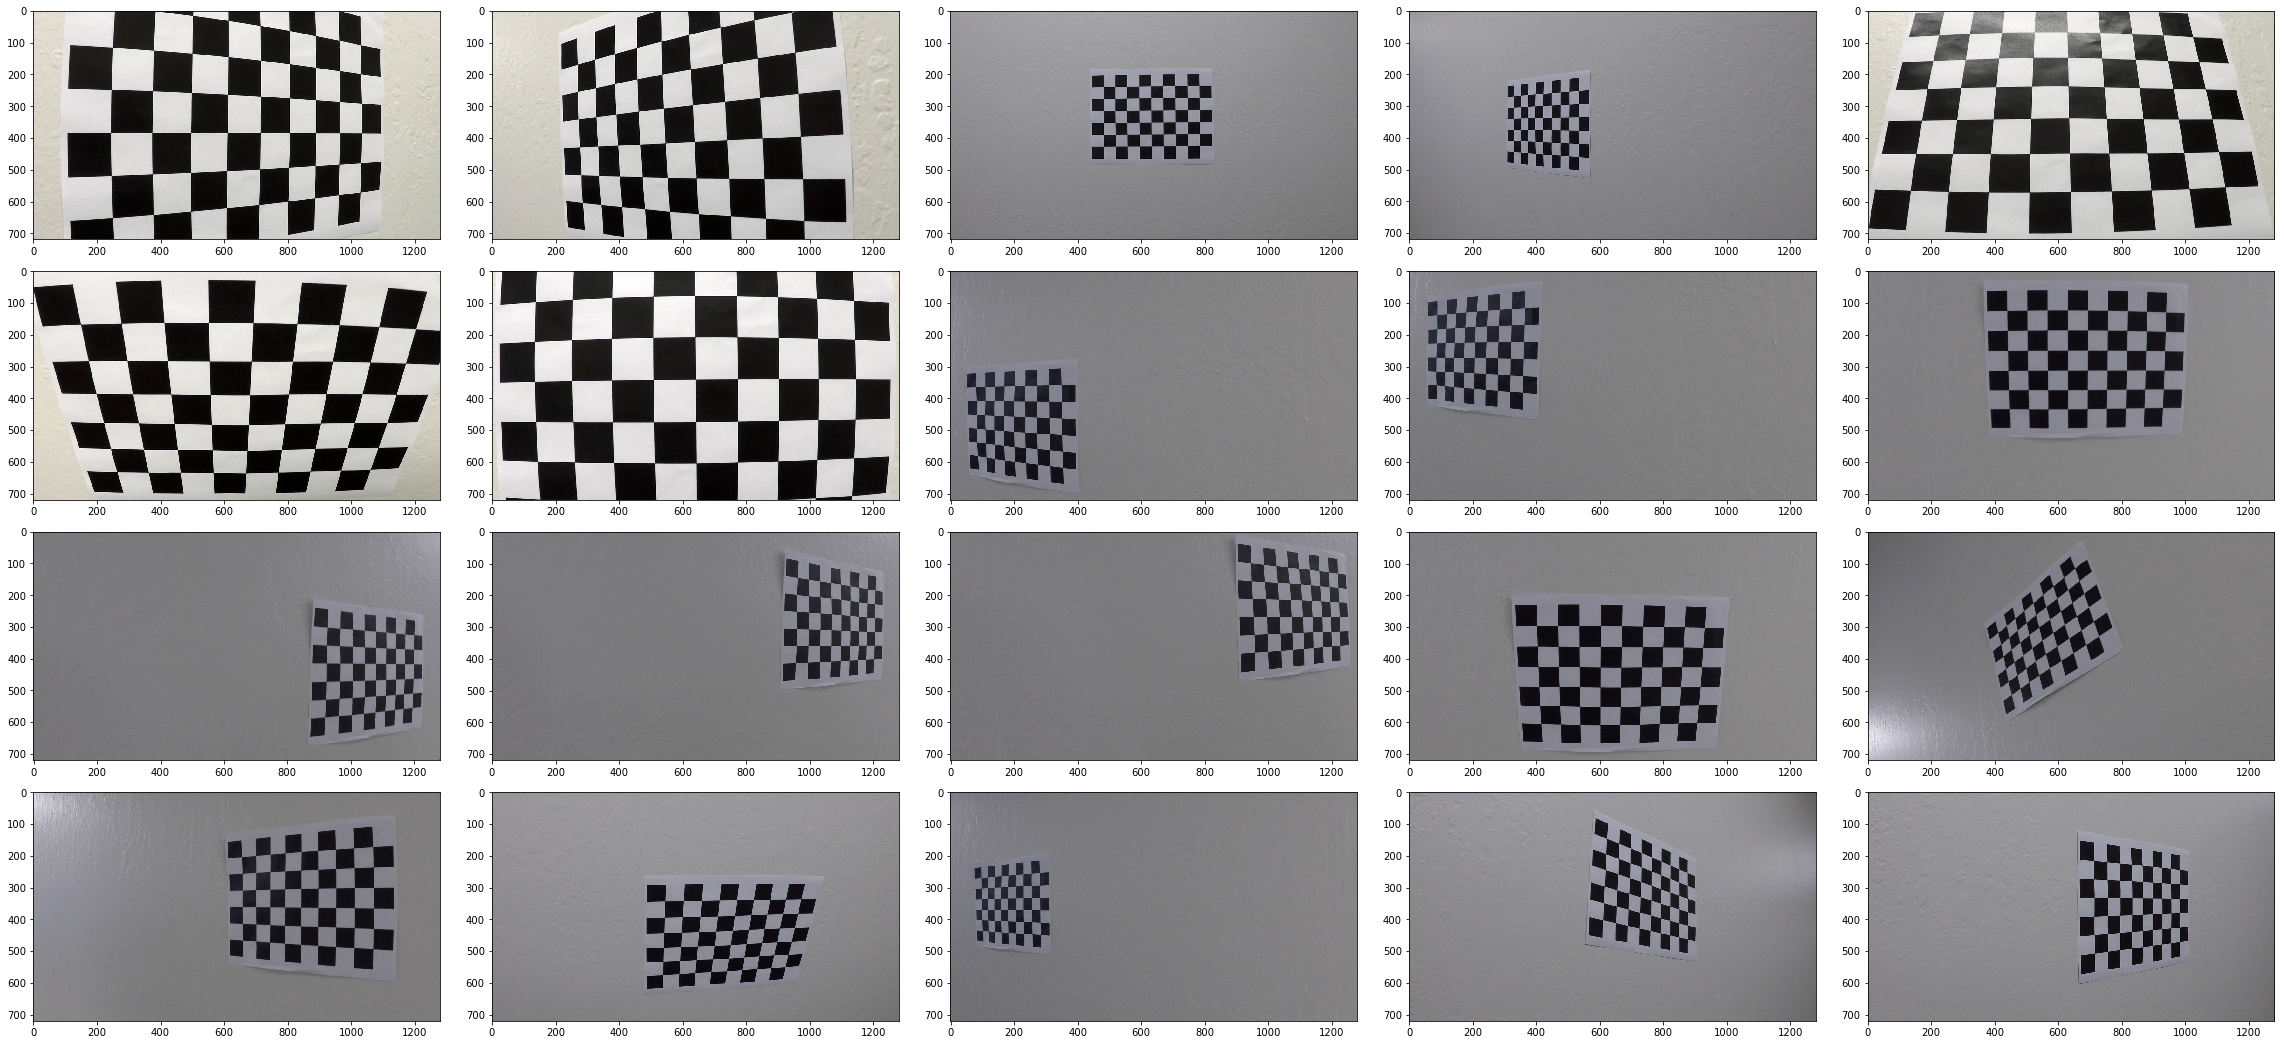

In [9]:
display_images(camera_cal_img_arr)

Save an image for testing.

In [10]:
test_img = camera_cal_img_arr[6]
camera_cal_img_arr = [camera_cal_img_arr[i] for i in range(len(camera_cal_img_arr)) if i != 6]
camera_cal_img_files = [camera_cal_img_files [i] for i in range(len(camera_cal_img_files)) if i != 6]

The objpoints and imgpoints will be used for unwarping video frames later .

In [11]:
objpoints = []
imgpoints = []

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
for img in tqdm(camera_cal_img_arr):
    x_cnt = 9
    y_cnt = 6

    objp = np.zeros((y_cnt*x_cnt,3), np.float32)
    objp[:,:2] = np.mgrid[0:x_cnt,0:y_cnt].T.reshape(-1,2)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (y_cnt, x_cnt), None)

    if ret:
        objpoints.append(objp)
        cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)   
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


100%|██████████| 19/19 [00:04<00:00,  3.95it/s]


In [12]:
def cal_undistort(img, objpoints, imgpoints):    
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                        gray.shape[::-1], 
                                                        None, None)
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)

    return undist

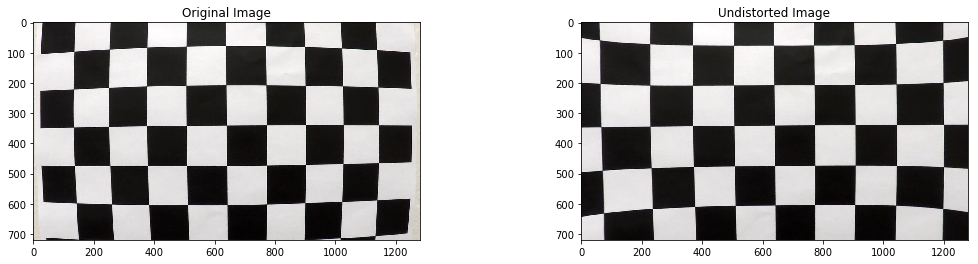

In [33]:
undistorted_img = cal_undistort(test_img, objpoints, imgpoints)

plt.figure(figsize=(18,4))

ax = plt.subplot(1,2,1)
ax.set_title('Original Image')
plt.imshow(test_img)
ax = plt.subplot(1,2,2)
ax.set_title('Undistorted Image')
plt.imshow(undistorted_img)
plt.show()

## Undistorting Video Frames

In [34]:
def load_test_images(test_img_dir):
    img_files = glob.glob('%s/*.jpg' % test_img_dir)
    return [imread(img_file) for img_file in img_files], img_files

In [35]:
test_image_arr, test_img_files = load_test_images('test_images')

Below are some test images with cal_undistort() applied to them.

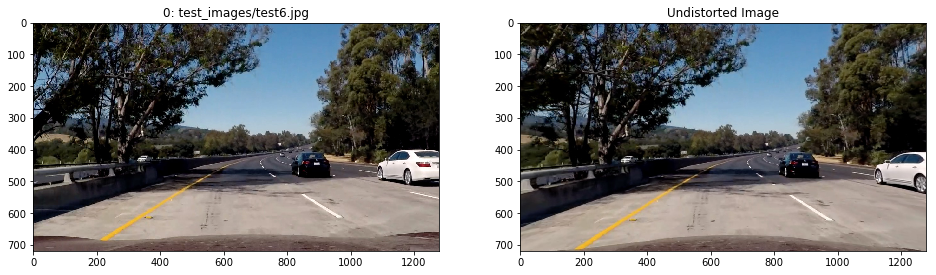

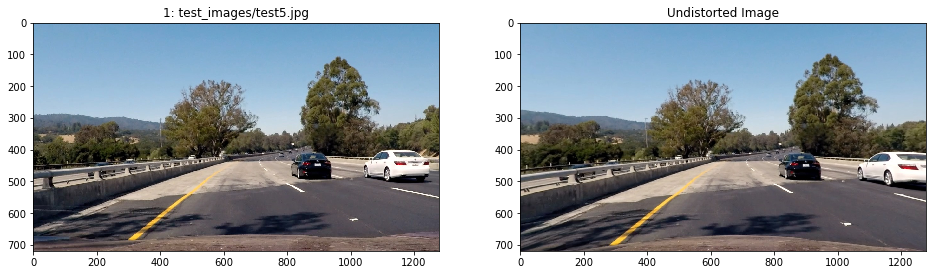

In [41]:
for i,img in enumerate(test_image_arr[1:3]):
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    
    plt.figure(figsize=(16,16))
    
    ax = plt.subplot(1,2,1)
    ax.set_title("%d: %s" % (i, test_img_files[i]))
    plt.imshow(img)
    ax = plt.subplot(1,2,2)
    ax.set_title('Undistorted Image')
    plt.imshow(undistorted_img)
    plt.show()

Two noticeable differences with the undistorted images are:

1. The dashboard on the bottom right has a similar curvature to the bottom left.
2. The white dashed lane lines on the right have a smoother curve.

## Binary Image

## HLS Thresholds

In [60]:
def make_S_threshold_img(img, thresh = (90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]

    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    return binary

def make_H_threshold_img(img, thresh = (15, 100)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]

    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1

    return binary

def make_SH_threshold_img(img, S_thresh = (90, 255), H_thresh = (15, 100)):
    S_threshold_img = make_S_threshold_img(img, thresh = S_thresh)
    H_threshold_img = make_H_threshold_img(img, thresh = H_thresh)
    
    combined_thresholds_img = np.logical_and(S_threshold_img, H_threshold_img)
    
    return 255*combined_thresholds_img.astype(np.uint8)

In [45]:
test_img = test_image_arr[0]

In [61]:
test_S_threshold_img = make_S_threshold_img(img, thresh = (90, 255))
test_H_threshold_img = make_H_threshold_img(img, thresh = (15, 100))
test_SH_threshold_img = make_SH_threshold_img(img, S_thresh = (90, 255), H_thresh = (15, 100))

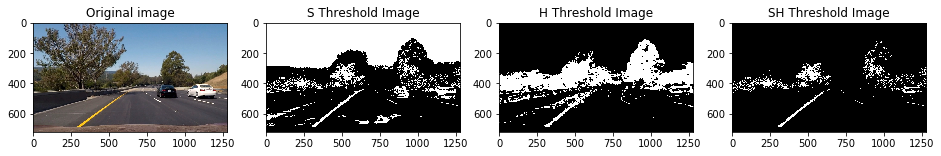

In [62]:
plt.figure(figsize=(16,16))
    
ax = plt.subplot(1,4,1)
ax.set_title('Original image')
plt.imshow(test_img)
ax = plt.subplot(1,4,2)
ax.set_title('S Threshold Image')
plt.imshow(test_S_threshold_img, cmap='gray')
ax = plt.subplot(1,4,3)
ax.set_title('H Threshold Image')
plt.imshow(test_H_threshold_img, cmap='gray')
ax = plt.subplot(1,4,4)
ax.set_title('SH Threshold Image')
plt.imshow(test_SH_threshold_img, cmap='gray')
plt.show()

## Sobel Threshold

In [42]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [ ]:
abs_sobel_thresh_x_sample_video_img = abs_sobel_thresh(test_img, orient='x', thresh_min=20, thresh_max=100)
abs_sobel_thresh_y_sample_video_img = abs_sobel_thresh(test_img, orient='y', thresh_min=20, thresh_max=100)

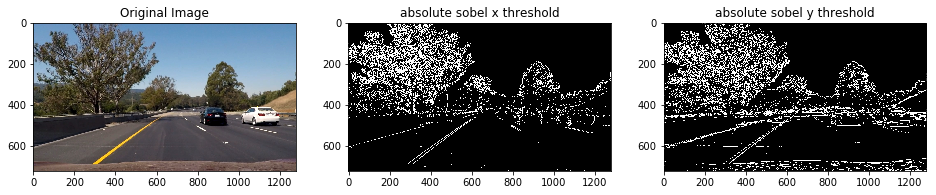

In [58]:
i = 1
cols = 3
rows = 1

plt.figure(figsize=(16,16))

ax = plt.subplot(rows,cols,i)
ax.set_title('Original Image')
plt.imshow(test_img, cmap='gray')

i += 1
ax = plt.subplot(rows,cols,i)
ax.set_title('absolute sobel x threshold')
plt.imshow(abs_sobel_thresh_x_sample_video_img, cmap='gray')

i += 1
ax = plt.subplot(rows,cols,i)
ax.set_title('absolute sobel y threshold')
plt.imshow(abs_sobel_thresh_y_sample_video_img, cmap='gray')

plt.show()

## Gradient Thresholds

In [50]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [53]:
mag_thresh_sample_video_img = mag_thresh(test_img, mag_thresh=(30, 100))

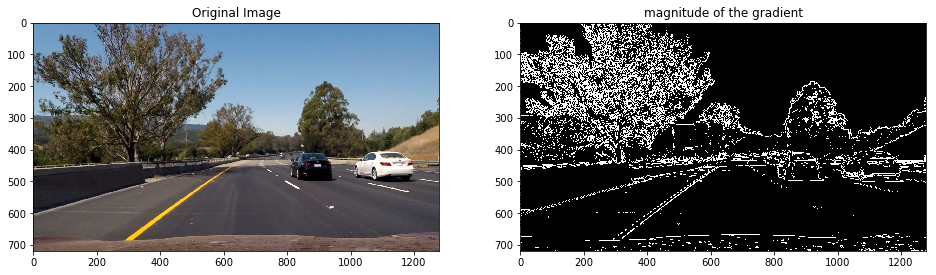

In [59]:
i = 1
cols = 2
rows = 1

plt.figure(figsize=(16,16))

ax = plt.subplot(rows,cols,i)
ax.set_title('Original Image')
plt.imshow(test_img, cmap='gray')

i += 1
ax = plt.subplot(rows,cols,i)
ax.set_title('magnitude of the gradient')
plt.imshow(mag_thresh_sample_video_img, cmap='gray')

plt.show()

## Combined Thresholds

In [64]:
def combine_thresholds(abs_sobel_x_thresh_img, abs_sobel_y_thresh_img, 
                      mag_thresh_img, SH_threshold_img):    
    combined_thresholds_img = np.logical_or(abs_sobel_x_thresh_img, abs_sobel_y_thresh_img)
    combined_thresholds_img = np.logical_or(combined_thresholds_img, mag_thresh_img)
    combined_thresholds_img = np.logical_or(combined_thresholds_img, SH_threshold_img)
    
    return 255*combined_thresholds_img.astype(np.uint8)

In [65]:
combine_thresholds_sample_video_img = combine_thresholds(abs_sobel_thresh_x_sample_video_img,
                                                        abs_sobel_thresh_y_sample_video_img,
                                                        mag_thresh_sample_video_img, 
                                                        test_SH_threshold_img)

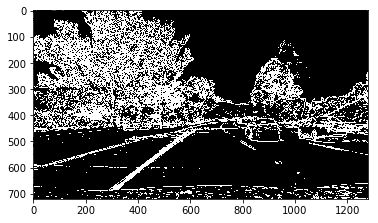

In [68]:
plt.imshow(combine_thresholds_sample_video_img, cmap='gray')
plt.show()

# Perspective Transform

In [101]:
sample_video_img = imread('data/project_video/frame_0000100.jpg')
undistorted_sample_video_img = cal_undistort(sample_video_img, objpoints, imgpoints)
lane_line_sample_video_img = weighted_img(find_lane3(undistorted_sample_video_img), undistorted_sample_video_img)

In [102]:
def warp(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
        
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv

In [133]:
img_size = (lane_line_sample_video_img.shape[1], lane_line_sample_video_img.shape[0])

src = np.float32(
     [[(img_size[0] / 2) - 85, img_size[1] / 2 + 120],
     [((img_size[0] / 6) + 45), img_size[1]],
     [(img_size[0] * 5 / 6) + 75, img_size[1]],
     [(img_size[0] / 2 + 90), img_size[1] / 2 + 120]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])    

In [134]:
warped_sample_video_img, Minv = warp(lane_line_sample_video_img, src, dst)

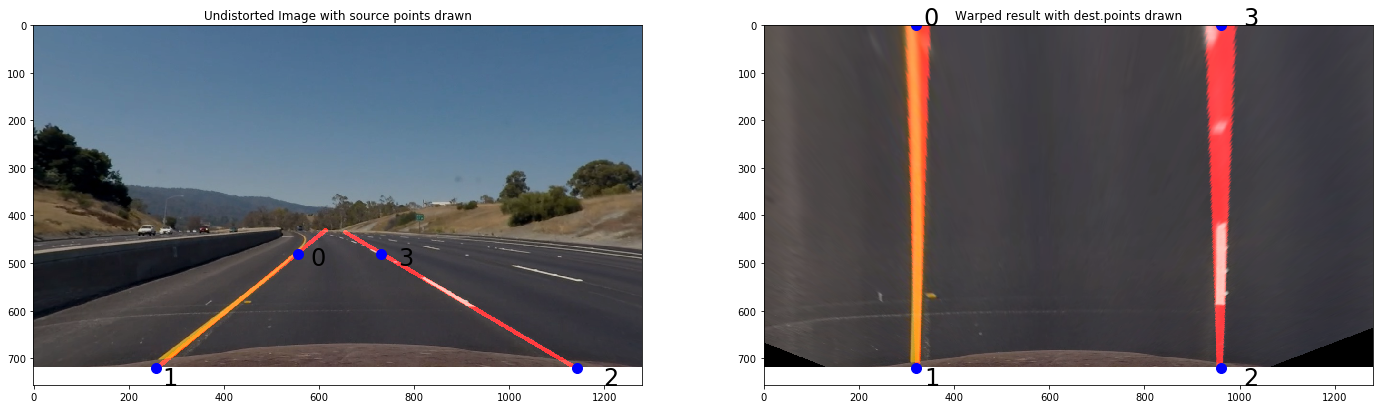

In [135]:
plt.figure(figsize=(24,32))

ax = plt.subplot(1,2,1)
ax.set_title('Undistorted Image with source points drawn')
plt.imshow(lane_line_sample_video_img)
for i in range(src.shape[0]):
    x,y = src[i]
    plt.plot(x,y, 'bo', markersize=10)
    plt.text(x * (1.05), y * (1.05) , i, fontsize=24)
    
ax = plt.subplot(1,2,2)
ax.set_title('Warped result with dest.points drawn')
plt.imshow(warped_sample_video_img)
for i in range(dst.shape[0]):
    x,y = dst[i]
    plt.plot(x,y, 'bo', markersize=10)
    plt.text(x * (1.05), y * (1.05) , i, fontsize=24)

plt.show()

In [148]:
def apply_img_pipeline(undistorted_img, objpoints, imgpoints):
    img_size = (undistorted_img.shape[1], undistorted_img.shape[0])

    src = np.float32(
         [[(img_size[0] / 2) - 85, img_size[1] / 2 + 120],
         [((img_size[0] / 6) + 45), img_size[1]],
         [(img_size[0] * 5 / 6) + 75, img_size[1]],
         [(img_size[0] / 2 + 90), img_size[1] / 2 + 120]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])    

    """
    plt.subplot(1,3,1)
    plt.imshow(undistorted_img)
    """
    
    warped_img, Minv = warp(undistorted_img, src, dst)

    """
    plt.subplot(1,3,2)
    plt.imshow(warped_img)
    """

    abs_sobel_thresh_x_img = abs_sobel_thresh(warped_img, orient='x', thresh_min=20, thresh_max=100)
    abs_sobel_thresh_y_img = abs_sobel_thresh(warped_img, orient='y', thresh_min=20, thresh_max=100)
    mag_thresh_img = mag_thresh(warped_img, mag_thresh=(30, 100))
    SH_threshold_img = make_SH_threshold_img(img, S_thresh = (90, 255), H_thresh = (15, 100))
    
    combine_thresholds_img = combine_thresholds(abs_sobel_thresh_x_img, abs_sobel_thresh_y_img,
                                                mag_thresh_img, SH_threshold_img)  
    
    """
    plt.subplot(1,3,3)
    plt.imshow(combine_thresholds_img)
    plt.show()
    """

    return combine_thresholds_img, Minv

# Lane Fitting

In [152]:
def get_basic_lane_lines(img, objpoints, imgpoints):
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
         [[(img_size[0] / 2) - 60, img_size[1] / 2 + 120],
         [((img_size[0] / 6) + 50), img_size[1]],
         [(img_size[0] * 5 / 6) + 75, img_size[1]],
         [(img_size[0] / 2 + 115), img_size[1] / 2 + 120]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])      
    
    undistorted_img = cal_undistort(img, objpoints, imgpoints)
    
    undistorted_lane_lines = find_lane3(undistorted_img)
    undistorted_lane_lines[:,:,1] = undistorted_lane_lines[:,:,0]
    undistorted_lane_lines[:,:,2] = undistorted_lane_lines[:,:,0]
    
    return undistorted_lane_lines

In [163]:
def fit_initial_lanes(binary_warped, objpoints, imgpoints):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img

In [157]:
def fit_lanes(binary_warped, left_fit, right_fit, margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create an output image to draw on and  visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)    

    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    print("###fit_lane - leftx", len(leftx))
    left_min_y = np.min(lefty)
    left_max_y = np.max(lefty)
    print("###fit_lane - left_min_y, left_max_y", left_min_y, left_max_y)  
    
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print("###fit_lane - rightx", len(rightx))
    right_min_y = np.min(righty)
    right_max_y = np.max(righty)
    print("###fit_lane - right_min_y, right_max_y", right_min_y, right_max_y) 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img

In [176]:
def plot_lanes(img, binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img):
    # Generate x and y values for plotting
    plt.figure(figsize=(18,4))
    
    ax = plt.subplot(1,3,1)
    ax.set_title('Original Image')
    plt.imshow(img)
    
    ax = plt.subplot(1,3,2)
    ax.set_title('Binary Warped Image')
    plt.imshow(binary_warped, cmap='gray')
    
    ax = plt.subplot(1,3,3)
    ax.set_title('Lane Lines')
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    plt.show()

In [177]:
video_image_files = sorted(glob.glob('%s/project_video/*.jpg' % data_dir))
sample_video_imgs_np = read_imgs(video_image_files[0:10])
sample_video_imgs_arr = [sample_video_imgs_np[i] for i in range(sample_video_imgs_np.shape[0])]  

In [167]:
binary_warped_img_arr = []
Minv_arr = []

for sample_video_img in tqdm(sample_video_imgs_arr):       
    undistorted_img = cal_undistort(sample_video_img, objpoints, imgpoints)   
    binary_warped_img, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
    
    binary_warped_img_arr.append(binary_warped_img)
    Minv_arr.append(Minv)

100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


### Fit Initial Lanes

In [168]:
left_fit, right_fit, left_lane_inds, \
right_lane_inds, nonzeroy, nonzerox, out_img = fit_initial_lanes(binary_warped_img_arr[0], objpoints, imgpoints)

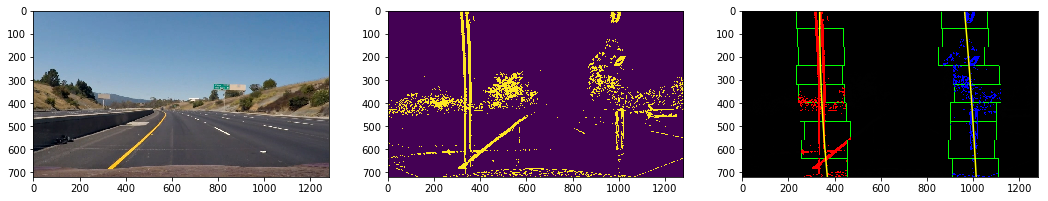

In [178]:
plot_lanes(sample_video_img, binary_warped_img_arr[0], left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, nonzerox, out_img)

### Fit Initial Lanes with Basic Lane Lines

In [186]:
basic_lane_lines_img = get_basic_lane_lines(sample_video_img, objpoints, imgpoints)
warped_img, Minv = apply_img_pipeline(basic_lane_lines_img, objpoints, imgpoints) 
left_fit, right_fit, left_lane_inds, right_lane_inds, \
nonzeroy, nonzerox, out_img = fit_initial_lanes(warped, objpoints, imgpoints)

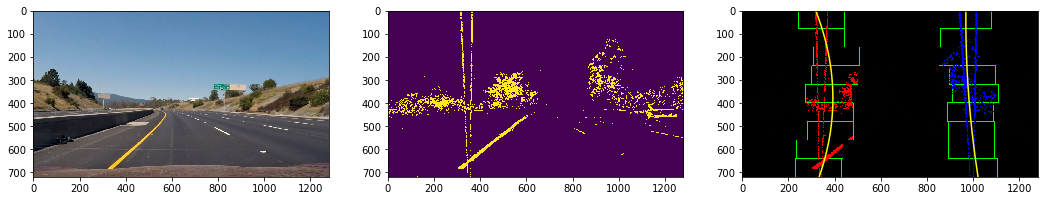

In [187]:
plot_lanes(sample_video_img, warped_img, left_fit, right_fit, left_lane_inds, right_lane_inds, nonzeroy, 
           nonzerox, out_img)

### Fit Lanes

In [188]:
left_fit, right_fit, left_lane_inds, right_lane_inds, \
nonzeroy, nonzerox, out_img = fit_lanes(binary_warped_img_arr[1], left_fit, right_fit)

###fit_lane - leftx 24068
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17819
###fit_lane - right_min_y, right_max_y 0 719


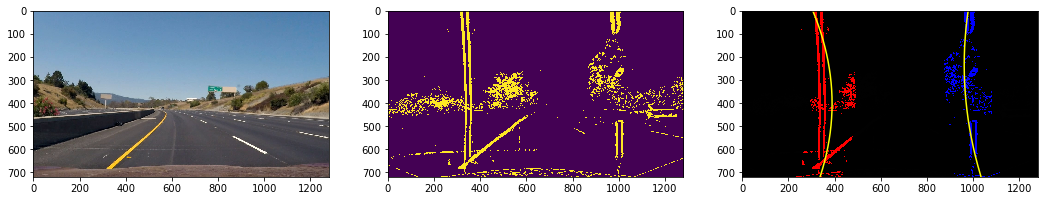

In [189]:
plot_lanes(sample_video_imgs_arr[1], binary_warped_img_arr[1], left_fit, right_fit, 
           left_lane_inds, right_lane_inds, nonzeroy,  nonzerox, out_img)

# Process Video Frames

In [191]:
class Line(object):
    def __init__(self, img_height, max_n_fits):
        self.img_height = img_height
        self.max_n_fits = max_n_fits
        
        self.fits = []
        
        self._y_vals = None
        
        self._last_mean_fit = None
        
    @property
    def mean_fit(self):
        if self.fits is None or len(self.fits) == 0:
            return None
        
        # Yah! Side effects! Cache the mean_fit value in last_mean_fit so you don't have to recalc.
        self._last_mean_fit = np.mean(self.fits, axis=0)
        
        return self._last_mean_fit
    
    @property
    def last_mean_fit(self):
        if self._last_mean_fit is None:
            self._last_mean_fit = self.mean_fit
            
        return self._last_mean_fit
    
    @property
    def y_vals(self):
        if self._y_vals is None:
            self._y_vals = np.linspace(0, self.img_height-1, num=self.img_height)
            
        return self._y_vals
    
    @property
    def x_vals(self):
        if self.mean_fit is None:
            return None
        
        return self.mean_fit[0] * self.y_vals**2 + self.mean_fit[1] * self.y_vals + self.mean_fit[2]
    
    @property
    def bottom_x(self):
        if self.mean_fit is None:
            return None
        
        return self.mean_fit[0] * self.img_height**2 + self.mean_fit[1] * self.img_height + self.mean_fit[2]
          
    @property
    def radius_of_curvature(self):
        """
        radius of curvature of the line in meters
        """
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension    

        fit = np.polyfit(self.y_vals*ym_per_pix, self.x_vals*xm_per_pix, 2)

        # Calculate the new radii of curvature
        radius_of_curvature = ((1 + (2*fit[0]*self.img_height*ym_per_pix + 
                                     fit[1])**2)**1.5) / np.absolute(2*fit[0])

        return radius_of_curvature 
    
    def add_fit(self, fit):
        self.fits.append(fit)
        
        if len(self.fits) > self.max_n_fits:
            self.fits = self.fits[-self.max_n_fits:]

In [192]:
def calc_lane_width(img_height, left_fit, right_fit):
    xm_per_pix = 3.7/700
    
    left_bottom_x = left_fit[0] * img_height**2 + left_fit[1] * img_height + left_fit[2]
    right_bottom_x = right_fit[0] * img_height**2 + right_fit[1] * img_height + right_fit[2]
    lane_width = (right_bottom_x - left_bottom_x) * xm_per_pix
    
    return lane_width

In [201]:
def draw_lanes_and_annotations(image, warped, Minv, ploty, left_fitx, right_fitx,
                                  curverad, offset, lane_width, frame_id=0):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))  
    
    # Combine the result with the original image
    #result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    output_img = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    frame_id_txt = 'Frame #%d' % frame_id
    curvature_txt = 'Curvature: %.2f' % curverad
    offset_txt = 'Offset: %.2f' % offset
    lane_width_txt = 'Lane Width: %.2f' % lane_width
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    text_color = (12, 12, 12)
    cv2.putText(output_img, frame_id_txt, (10,60), font, 2, text_color,2,cv2.LINE_AA)
    cv2.putText(output_img, curvature_txt, (10,120), font, 2, text_color,2,cv2.LINE_AA)
    cv2.putText(output_img, offset_txt, (10,180), font, 2, text_color,2,cv2.LINE_AA)
    cv2.putText(output_img, lane_width_txt, (10,240), font, 2, text_color,2,cv2.LINE_AA)

    return output_img

In [202]:
def make_lane_line_frames(img_files, output_dir, objpoints, imgpoints,
                          window_width = 50, window_height = 80, margin = 100, 
                          max_n_fits=10, reinit_cnt=40, start_idx=0, min_lane_width=None, max_lane_width=None):
    os.makedirs(output_dir, exist_ok=True)
    
    frame_files = []
    curvatures = []
    
    img_shape = imread(img_files[0]).shape
    img_height = img_shape[0]
    img_width = img_shape[1]
    
    left_line = Line(img_height, max_n_fits)
    right_line = Line(img_height, max_n_fits)
    ploty = left_line.y_vals

    init_fit_lanes = True
    xm_per_pix = 3.7/700
    offset = 0.0
    
    for i, img_file in enumerate(tqdm(img_files)):
        print("###", i)
        img = imread(img_file)
        print("###img min(), max()", img.min(), img.max())
        print("###img", img.shape, img.dtype)
        
        if init_fit_lanes:
            try:
                basic_lane_lines_img = get_basic_lane_lines(img, objpoints, imgpoints)
                print("###basic_lane_lines_img min(), max()", basic_lane_lines_img.min(), basic_lane_lines_img.max())
                print("###basic_lane_lines_img", basic_lane_lines_img.shape, basic_lane_lines_img.dtype)
                warped, Minv = apply_img_pipeline(basic_lane_lines_img, objpoints, imgpoints) 
                left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
                
                lane_width = calc_lane_width(img_height, left_fit, right_fit)
                if ((min_lane_width is not None and lane_width < min_lane_width) or 
                    (max_lane_width is not None and lane_width > max_lane_width)):
                    # If basic lane lines produces an invalid lane_width, revert back to fit_initial_lanes.
                    # (For curvy roads in Harder Challenge video.)
                    undistorted_img = cal_undistort(img, objpoints, imgpoints) 
                    warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
                    left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
            except:
                undistorted_img = cal_undistort(img, objpoints, imgpoints) 
                warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
                left_fit, right_fit, _, _, _, _, _ = fit_initial_lanes(warped, objpoints, imgpoints)
                
            init_fit_lanes = False
        else:
            undistorted_img = cal_undistort(img, objpoints, imgpoints) 
            warped, Minv = apply_img_pipeline(undistorted_img, objpoints, imgpoints) 
            left_fit, right_fit, _, _, _, _, _ = fit_lanes(warped, left_line.last_mean_fit, 
                                                           right_line.last_mean_fit, margin = margin)
            
            """
            if max_lane_width is not None:
                lane_width = calc_lane_width(img_height, left_fit, right_fit)
            
                if lane_width > max_lane_width:
                    # if the lane width is too wide, use centroid fit instead
                    print("###lane_width", lane_width)
                    centroid_left_fit, centroid_right_fit = get_window_centroid_fit(warped, window_width, 
                                                                                    window_height, margin)
                    centroid_lane_width = calc_lane_width(img_height, centroid_left_fit, centroid_right_fit)
                
                    if centroid_lane_width < lane_width:
                        # use the fits from the smaller lane width
                        print("using centroid fit")
                        left_fit, right_fit = centroid_left_fit, centroid_right_fit
            """
                
        left_line.add_fit(left_fit)
        right_line.add_fit(right_fit)

        frame_idx = i+start_idx

        offset = (img.shape[1]/2.0)-(left_line.bottom_x+right_line.bottom_x)/2.0
        
        lane_width = (right_line.bottom_x - left_line.bottom_x) * xm_per_pix
        print("###lane_width", lane_width)
        if ((min_lane_width is not None and lane_width < min_lane_width) or 
            (max_lane_width is not None and lane_width > max_lane_width)):
            # if the lane width is still too narrow or too wide, go back to find init lanes
            print(i, lane_width, "resetting find lanes")
            # the width of the lane seems too wide. reinit finding the lanes
            init_fit_lanes = True
        
        curverad = np.min([left_line.radius_of_curvature, right_line.radius_of_curvature])
        curvatures.append(curverad)
            
        road_with_lanes = draw_lanes_and_annotations(img, warped, Minv, ploty, 
                                                     left_line.x_vals, right_line.x_vals, 
                                                     curverad, offset, lane_width, frame_idx)

        """
        plt.imshow(road_with_lanes)
        plt.show()
        """
        
        frame_file = "%s/frame_%s.jpg" % (output_dir, pad_zeros(frame_idx))
        imsave(frame_file, road_with_lanes)
        
        frame_files.append(frame_file)
        
        if i % reinit_cnt == 0:
            # do an init after 10 times the number of cached fits
            init_fit_lanes = True 

    return frame_files, curvatures

In [ ]:
def make_video(img_dir, outfile):
    file_list = sorted(glob.glob('%s/*.jpg' % img_dir))
    img_clips = [ImageClip(file).set_duration(2) for file in file_list]
    
    video = concatenate_videoclips(img_clips, method='compose')
    video.write_videofile(outfile, fps=24)

In [209]:
def plot_curvature_histogram(curvatures, num_bins = 20):
    n, bins, patches = plt.hist(curvatures, num_bins, facecolor='blue', alpha=0.5)
    plt.xlabel('Radius of Curvature (meters)')
    plt.ylabel('Frequency')
    plt.title('Radius of Curvature Histogram')
    plt.show()

## Project Video

### Extract Frames 

In [194]:
video = 'project_video.mp4'
output_dir = '%s/project_video' % data_dir
extract_video_imgs(video, output_dir)

100%|██████████| 1259/1259 [01:15<00:00, 18.03it/s]


### Make Lane Line Images

In [195]:
lane_line_dir = '%s/lane_lines' % data_dir

In [203]:
video_image_files = sorted(glob.glob('%s/*.jpg' % output_dir))

frame_files, curvatures = make_lane_line_frames(video_image_files, lane_line_dir, objpoints, imgpoints,
                                                max_n_fits=12, reinit_cnt=48, start_idx=0,
                                                min_lane_width=2.6, max_lane_width=3.5)

  0%|          | 0/1259 [00:00<?, ?it/s]

### 0
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


  0%|          | 1/1259 [00:02<59:17,  2.83s/it]

###lane_width 3.40752158688
### 1
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


  0%|          | 2/1259 [00:05<59:26,  2.84s/it]

###lane_width 3.41139194002
### 2
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 3/1259 [00:07<52:24,  2.50s/it]

###fit_lane - leftx 21530
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17889
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42565027915
### 3
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 4/1259 [00:09<47:59,  2.29s/it]

###fit_lane - leftx 21251
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18287
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42594215555
### 4
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 5/1259 [00:11<45:42,  2.19s/it]

###fit_lane - leftx 21765
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17332
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.42345788954
### 5
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 6/1259 [00:14<50:50,  2.43s/it]

###fit_lane - leftx 21850
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16796
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.4181619603
### 6
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 7/1259 [00:16<48:17,  2.31s/it]

###fit_lane - leftx 23420
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16394
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40536016618
### 7
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 8/1259 [00:18<48:04,  2.31s/it]

###fit_lane - leftx 23344
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16008
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39770983768
### 8
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 9/1259 [00:20<43:58,  2.11s/it]

###fit_lane - leftx 22832
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15928
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.39529975372
### 9
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 10/1259 [00:22<42:24,  2.04s/it]

###fit_lane - leftx 22816
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15300
###fit_lane - right_min_y, right_max_y 58 719
###lane_width 3.39597948616
### 10
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 11/1259 [00:24<42:53,  2.06s/it]

###fit_lane - leftx 21619
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15259
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.39889989431
### 11
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 12/1259 [00:25<40:07,  1.93s/it]

###fit_lane - leftx 23141
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15617
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39592796348
### 12
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 13/1259 [00:28<42:23,  2.04s/it]

###fit_lane - leftx 22981
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15795
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39589395857
### 13
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 14/1259 [00:29<41:11,  1.98s/it]

###fit_lane - leftx 22429
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17770
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39732393708
### 14
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 15/1259 [00:32<43:23,  2.09s/it]

###fit_lane - leftx 22077
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18138
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39332856566
### 15
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|▏         | 16/1259 [00:34<42:27,  2.05s/it]

###fit_lane - leftx 21080
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18147
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3872206821
### 16
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|▏         | 17/1259 [00:35<39:15,  1.90s/it]

###fit_lane - leftx 21369
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17517
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.38114788365
### 17
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21186
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16810
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.37637315925


  1%|▏         | 18/1259 [00:37<40:41,  1.97s/it]

### 18
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 19/1259 [00:39<39:16,  1.90s/it]

###fit_lane - leftx 22098
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16258
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.37871500267
### 19
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 20/1259 [00:41<37:29,  1.82s/it]

###fit_lane - leftx 22694
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15610
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38415133085
### 20
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 21/1259 [00:43<37:58,  1.84s/it]

###fit_lane - leftx 22972
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15222
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38669006917
### 21
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 22/1259 [00:44<37:42,  1.83s/it]

###fit_lane - leftx 22974
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15362
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39067979637
### 22
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 23/1259 [00:46<37:34,  1.82s/it]

###fit_lane - leftx 22718
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14613
###fit_lane - right_min_y, right_max_y 53 719
###lane_width 3.39168599766
### 23
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 24/1259 [00:48<40:04,  1.95s/it]

###fit_lane - leftx 21659
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 14463
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.39449800731
### 24
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 25/1259 [00:50<37:33,  1.83s/it]

###fit_lane - leftx 23847
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14773
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39765187414
### 25
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 26/1259 [00:52<40:57,  1.99s/it]

###fit_lane - leftx 23594
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15169
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39431706107
### 26
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23100
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15933
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39837866046


  2%|▏         | 27/1259 [00:54<39:18,  1.91s/it]

### 27
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 28/1259 [00:56<39:28,  1.92s/it]

###fit_lane - leftx 21519
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16785
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4053536492
### 28
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21920
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17693
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40799158261


  2%|▏         | 29/1259 [00:58<38:49,  1.89s/it]

### 29
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 30/1259 [01:00<38:30,  1.88s/it]

###fit_lane - leftx 21959
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17369
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.41020453452
### 30
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22476
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16433
###fit_lane - right_min_y, right_max_y 81 719
###lane_width 3.41062840532


  2%|▏         | 31/1259 [01:03<44:20,  2.17s/it]

### 31
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 32/1259 [01:04<40:46,  1.99s/it]

###fit_lane - leftx 22525
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15937
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40926636471
### 32
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 33/1259 [01:07<43:20,  2.12s/it]

###fit_lane - leftx 24569
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15574
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40345139277
### 33
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 34/1259 [01:08<38:38,  1.89s/it]

###fit_lane - leftx 23985
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15729
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39825745303
### 34
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 35/1259 [01:10<37:09,  1.82s/it]

###fit_lane - leftx 22581
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14565
###fit_lane - right_min_y, right_max_y 54 719
###lane_width 3.39455556578
### 35
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 36/1259 [01:11<36:15,  1.78s/it]

###fit_lane - leftx 22498
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14523
###fit_lane - right_min_y, right_max_y 101 719
###lane_width 3.39351297513
### 36
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 37/1259 [01:13<36:04,  1.77s/it]

###fit_lane - leftx 24433
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15298
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38433129578
### 37
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 38/1259 [01:15<34:16,  1.68s/it]

###fit_lane - leftx 24332
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16121
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38200509204
### 38
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 39/1259 [01:16<35:33,  1.75s/it]

###fit_lane - leftx 22334
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16482
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37629755579
### 39
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 40/1259 [01:18<37:06,  1.83s/it]

###fit_lane - leftx 22059
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17108
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37121874685
### 40
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 41/1259 [01:20<34:21,  1.69s/it]

###fit_lane - leftx 21100
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17665
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37002011161
### 41
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 42/1259 [01:22<36:09,  1.78s/it]

###fit_lane - leftx 21137
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17466
###fit_lane - right_min_y, right_max_y 11 719
###lane_width 3.36849274166
### 42
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 43/1259 [01:23<34:30,  1.70s/it]

###fit_lane - leftx 21316
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17087
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.36552043283
### 43
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 44/1259 [01:25<34:45,  1.72s/it]

###fit_lane - leftx 21107
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16772
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.36037007655
### 44
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▎         | 45/1259 [01:27<33:06,  1.64s/it]

###fit_lane - leftx 23902
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16753
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.35358532576
### 45
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▎         | 46/1259 [01:28<33:12,  1.64s/it]

###fit_lane - leftx 23435
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15785
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34317308723
### 46
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▎         | 47/1259 [01:30<31:14,  1.55s/it]

###fit_lane - leftx 22454
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15441
###fit_lane - right_min_y, right_max_y 8 719
###lane_width 3.33735058429
### 47
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 48/1259 [01:31<32:20,  1.60s/it]

###fit_lane - leftx 21867
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14708
###fit_lane - right_min_y, right_max_y 47 719
###lane_width 3.33460897576
### 48
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 49/1259 [01:33<32:57,  1.63s/it]

###fit_lane - leftx 21590
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14597
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.33704928191
### 49
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


  4%|▍         | 50/1259 [01:37<45:21,  2.25s/it]

###lane_width 3.32918942725
### 50
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 51/1259 [01:38<41:55,  2.08s/it]

###fit_lane - leftx 23136
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16184
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32295277568
### 51
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 52/1259 [01:40<38:40,  1.92s/it]

###fit_lane - leftx 21452
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16797
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32012496125
### 52
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 53/1259 [01:41<36:50,  1.83s/it]

###fit_lane - leftx 21391
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17326
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31614807436
### 53
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 54/1259 [01:43<35:12,  1.75s/it]

###fit_lane - leftx 21135
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18207
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31024471284
### 54
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 55/1259 [01:45<35:33,  1.77s/it]

###fit_lane - leftx 21178
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17675
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.30332366383
### 55
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 56/1259 [01:46<34:11,  1.71s/it]

###fit_lane - leftx 21404
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16778
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.29903434946
### 56
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 57/1259 [01:48<32:42,  1.63s/it]

###fit_lane - leftx 21445
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15943
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.29924269767
### 57
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 58/1259 [01:50<33:05,  1.65s/it]

###fit_lane - leftx 23912
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15713
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29279501496
### 58
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 59/1259 [01:51<31:52,  1.59s/it]

###fit_lane - leftx 23851
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15342
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.28597725227
### 59
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 60/1259 [01:53<31:10,  1.56s/it]

###fit_lane - leftx 22373
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14447
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.27772754029
### 60
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 61/1259 [01:54<31:29,  1.58s/it]

###fit_lane - leftx 21909
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 14398
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.26873584639
### 61
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 62/1259 [01:56<31:21,  1.57s/it]

###fit_lane - leftx 24396
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15520
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26057102633
### 62
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 63/1259 [01:57<31:45,  1.59s/it]

###fit_lane - leftx 24084
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16550
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.24985015648
### 63
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 64/1259 [01:59<33:18,  1.67s/it]

###fit_lane - leftx 23552
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17312
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23940043962
### 64
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 65/1259 [02:01<33:37,  1.69s/it]

###fit_lane - leftx 22577
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17585
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23131293029
### 65
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 66/1259 [02:03<34:17,  1.72s/it]

###fit_lane - leftx 22042
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17916
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22506886256
### 66
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 67/1259 [02:04<33:52,  1.71s/it]

###fit_lane - leftx 22157
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17337
###fit_lane - right_min_y, right_max_y 29 719
###lane_width 3.21979972386
### 67
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 68/1259 [02:06<34:20,  1.73s/it]

###fit_lane - leftx 22107
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16103
###fit_lane - right_min_y, right_max_y 82 719
###lane_width 3.21236238029
### 68
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 69/1259 [02:08<33:07,  1.67s/it]

###fit_lane - leftx 21680
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15489
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.20812983533
### 69
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 70/1259 [02:10<33:53,  1.71s/it]

###fit_lane - leftx 25210
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15567
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.20482009231
### 70
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 71/1259 [02:11<33:27,  1.69s/it]

###fit_lane - leftx 24128
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15584
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19938866698
### 71
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 72/1259 [02:13<33:47,  1.71s/it]

###fit_lane - leftx 23423
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15243
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.19479147913
### 72
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 73/1259 [02:15<33:15,  1.68s/it]

###fit_lane - leftx 23247
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14643
###fit_lane - right_min_y, right_max_y 76 719
###lane_width 3.19047303239
### 73
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 74/1259 [02:16<32:52,  1.66s/it]

###fit_lane - leftx 22378
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14526
###fit_lane - right_min_y, right_max_y 114 719
###lane_width 3.1927913043
### 74
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 75/1259 [02:18<33:34,  1.70s/it]

###fit_lane - leftx 24576
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15356
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18769449626
### 75
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 76/1259 [02:20<33:12,  1.68s/it]

###fit_lane - leftx 24227
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15892
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18266065149
### 76
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 77/1259 [02:22<35:29,  1.80s/it]

###fit_lane - leftx 23812
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16866
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17988469919
### 77
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 78/1259 [02:23<33:49,  1.72s/it]

###fit_lane - leftx 22943
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16894
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17882588173
### 78
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▋         | 79/1259 [02:25<33:32,  1.71s/it]

###fit_lane - leftx 22346
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17440
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17616446829
### 79
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▋         | 80/1259 [02:26<32:23,  1.65s/it]

###fit_lane - leftx 22438
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17578
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.17307812258
### 80
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▋         | 81/1259 [02:28<33:39,  1.71s/it]

###fit_lane - leftx 21956
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16590
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.16792359928
### 81
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22255
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15874
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.16946462448


  7%|▋         | 82/1259 [02:31<39:31,  2.01s/it]

### 82
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 83/1259 [02:33<37:46,  1.93s/it]

###fit_lane - leftx 25387
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16559
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16509165544
### 83
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24155
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15356
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.160448868


  7%|▋         | 84/1259 [02:35<38:03,  1.94s/it]

### 84
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 85/1259 [02:36<35:03,  1.79s/it]

###fit_lane - leftx 23508
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15538
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15787562623
### 85
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 86/1259 [02:38<37:36,  1.92s/it]

###fit_lane - leftx 23182
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14305
###fit_lane - right_min_y, right_max_y 69 719
###lane_width 3.1573846804
### 86
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 87/1259 [02:40<35:09,  1.80s/it]

###fit_lane - leftx 25089
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15321
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.1549500152
### 87
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 88/1259 [02:42<35:23,  1.81s/it]

###fit_lane - leftx 24475
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15990
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15188318179
### 88
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 89/1259 [02:43<33:39,  1.73s/it]

###fit_lane - leftx 23295
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16924
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14908237793
### 89
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 90/1259 [02:45<32:54,  1.69s/it]

###fit_lane - leftx 22642
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17156
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14624329283
### 90
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 91/1259 [02:46<30:49,  1.58s/it]

###fit_lane - leftx 21552
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17039
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14990924372
### 91
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 92/1259 [02:48<31:51,  1.64s/it]

###fit_lane - leftx 22379
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17493
###fit_lane - right_min_y, right_max_y 13 719
###lane_width 3.14939812147
### 92
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 93/1259 [02:50<32:13,  1.66s/it]

###fit_lane - leftx 22122
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16607
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.14836719799
### 93
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 94/1259 [02:51<32:36,  1.68s/it]

###fit_lane - leftx 22683
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15984
###fit_lane - right_min_y, right_max_y 97 719
###lane_width 3.14579854241
### 94
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 95/1259 [02:53<33:10,  1.71s/it]

###fit_lane - leftx 26347
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15857
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14277015928
### 95
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 96/1259 [02:55<33:10,  1.71s/it]

###fit_lane - leftx 25849
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15749
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14069404298
### 96
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24366
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15226
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.13979122942


  8%|▊         | 97/1259 [02:56<32:27,  1.68s/it]

### 97
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.14392674218


  8%|▊         | 98/1259 [02:59<35:01,  1.81s/it]

### 98
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22319
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14318
###fit_lane - right_min_y, right_max_y 105 719
###lane_width 3.15046302715


  8%|▊         | 99/1259 [03:00<35:01,  1.81s/it]

### 99
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 100/1259 [03:02<34:43,  1.80s/it]

###fit_lane - leftx 25489
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15374
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14967652426
### 100
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25245
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16397
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1495049853


  8%|▊         | 101/1259 [03:04<35:50,  1.86s/it]

### 101
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 102/1259 [03:06<35:01,  1.82s/it]

###fit_lane - leftx 24194
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17191
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15175826283
### 102
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 103/1259 [03:08<37:56,  1.97s/it]

###fit_lane - leftx 23421
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17434
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14946034552
### 103
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 104/1259 [03:10<35:27,  1.84s/it]

###fit_lane - leftx 21719
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17396
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15251924458
### 104
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 105/1259 [03:12<35:58,  1.87s/it]

###fit_lane - leftx 21830
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17822
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15578841721
### 105
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 106/1259 [03:14<36:15,  1.89s/it]

###fit_lane - leftx 22326
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17318
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.15789883323
### 106
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 107/1259 [03:15<35:43,  1.86s/it]

###fit_lane - leftx 22269
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16269
###fit_lane - right_min_y, right_max_y 92 719
###lane_width 3.16383375246
### 107
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25373
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16245
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16412725106


  9%|▊         | 108/1259 [03:18<37:41,  1.96s/it]

### 108
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▊         | 109/1259 [03:20<38:49,  2.03s/it]

###fit_lane - leftx 25592
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15877
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15997988382
### 109
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▊         | 110/1259 [03:22<38:18,  2.00s/it]

###fit_lane - leftx 23915
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15606
###fit_lane - right_min_y, right_max_y 10 719
###lane_width 3.15210618476
### 110
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 111/1259 [03:24<37:14,  1.95s/it]

###fit_lane - leftx 22945
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14793
###fit_lane - right_min_y, right_max_y 40 719
###lane_width 3.15408961322
### 111
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 112/1259 [03:25<35:15,  1.84s/it]

###fit_lane - leftx 22305
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14437
###fit_lane - right_min_y, right_max_y 102 719
###lane_width 3.16189265032
### 112
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 113/1259 [03:27<33:08,  1.74s/it]

###fit_lane - leftx 25010
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15631
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16228933464
### 113
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 114/1259 [03:29<35:24,  1.86s/it]

###fit_lane - leftx 24856
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16021
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16411558852
### 114
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 115/1259 [03:30<33:01,  1.73s/it]

###fit_lane - leftx 23548
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16961
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16788364895
### 115
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 116/1259 [03:32<34:22,  1.80s/it]

###fit_lane - leftx 22573
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17142
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17177991346
### 116
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 117/1259 [03:34<34:10,  1.80s/it]

###fit_lane - leftx 22551
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17743
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17349852566
### 117
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 118/1259 [03:36<33:36,  1.77s/it]

###fit_lane - leftx 22413
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17265
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.17494651071
### 118
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 119/1259 [03:37<33:17,  1.75s/it]

###fit_lane - leftx 21809
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16372
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.17570436323
### 119
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 120/1259 [03:39<33:48,  1.78s/it]

###fit_lane - leftx 21487
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15745
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.17878933376
### 120
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 121/1259 [03:41<32:30,  1.71s/it]

###fit_lane - leftx 24312
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16104
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18132807577
### 121
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23114
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15664
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.18203541899


 10%|▉         | 122/1259 [03:43<33:45,  1.78s/it]

### 122
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 123/1259 [03:44<33:11,  1.75s/it]

###fit_lane - leftx 22753
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14816
###fit_lane - right_min_y, right_max_y 64 719
###lane_width 3.1799706813
### 123
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 124/1259 [03:46<32:21,  1.71s/it]

###fit_lane - leftx 21800
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14236
###fit_lane - right_min_y, right_max_y 110 719
###lane_width 3.17850376367
### 124
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 125/1259 [03:48<32:09,  1.70s/it]

###fit_lane - leftx 23848
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15394
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17832881872
### 125
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 126/1259 [03:49<32:04,  1.70s/it]

###fit_lane - leftx 23033
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16132
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17882308297
### 126
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 127/1259 [03:51<30:56,  1.64s/it]

###fit_lane - leftx 22955
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17224
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18055998874
### 127
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 128/1259 [03:53<34:43,  1.84s/it]

###fit_lane - leftx 22020
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17625
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18044921376
### 128
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21023
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17811
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18229460573


 10%|█         | 129/1259 [03:55<35:34,  1.89s/it]

### 129
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 130/1259 [03:57<34:29,  1.83s/it]

###fit_lane - leftx 21799
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17760
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.18026414655
### 130
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 131/1259 [03:59<36:23,  1.94s/it]

###fit_lane - leftx 22043
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17611
###fit_lane - right_min_y, right_max_y 81 719
###lane_width 3.1714816181
### 131
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 132/1259 [04:01<34:28,  1.84s/it]

###fit_lane - leftx 22203
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16594
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16434327732
### 132
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 133/1259 [04:03<35:02,  1.87s/it]

###fit_lane - leftx 24832
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16540
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1609189703
### 133
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 134/1259 [04:04<33:06,  1.77s/it]

###fit_lane - leftx 24570
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16548
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15812141737
### 134
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 135/1259 [04:06<32:37,  1.74s/it]

###fit_lane - leftx 24212
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16059
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.15502661701
### 135
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22759
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14962
###fit_lane - right_min_y, right_max_y 74 719
###lane_width 3.15177676749


 11%|█         | 136/1259 [04:07<32:05,  1.71s/it]

### 136
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 137/1259 [04:09<32:29,  1.74s/it]

###fit_lane - leftx 21460
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14611
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.15639240577
### 137
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 138/1259 [04:11<31:08,  1.67s/it]

###fit_lane - leftx 25162
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15574
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14867135373
### 138
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 139/1259 [04:13<33:48,  1.81s/it]

###fit_lane - leftx 24204
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15878
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1460844479
### 139
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 140/1259 [04:15<33:02,  1.77s/it]

###fit_lane - leftx 22764
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16901
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14679384593
### 140
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 141/1259 [04:16<32:29,  1.74s/it]

###fit_lane - leftx 21772
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17289
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1511522528
### 141
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█▏        | 142/1259 [04:18<31:32,  1.69s/it]

###fit_lane - leftx 21093
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17942
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15784592376
### 142
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█▏        | 143/1259 [04:20<32:41,  1.76s/it]

###fit_lane - leftx 21699
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17496
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.16875610443
### 143
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█▏        | 144/1259 [04:21<32:19,  1.74s/it]

###fit_lane - leftx 21642
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16833
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.17928183474
### 144
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 145/1259 [04:24<34:35,  1.86s/it]

###fit_lane - leftx 21991
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15777
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18698852502
### 145
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 12%|█▏        | 146/1259 [04:27<41:16,  2.22s/it]

###lane_width 3.25841358655
### 146
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 147/1259 [04:28<38:12,  2.06s/it]

###fit_lane - leftx 23880
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15916
###fit_lane - right_min_y, right_max_y 29 719
###lane_width 3.26647139497
### 147
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 148/1259 [04:30<36:46,  1.99s/it]

###fit_lane - leftx 22940
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14794
###fit_lane - right_min_y, right_max_y 72 719
###lane_width 3.27739211689
### 148
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22576
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14514
###fit_lane - right_min_y, right_max_y 105 719
###lane_width 3.28550801035


 12%|█▏        | 149/1259 [04:32<37:10,  2.01s/it]

### 149
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 150/1259 [04:34<36:37,  1.98s/it]

###fit_lane - leftx 22853
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14781
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30158717948
### 150
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 151/1259 [04:36<36:15,  1.96s/it]

###fit_lane - leftx 22746
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15670
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31824970136
### 151
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 152/1259 [04:38<34:40,  1.88s/it]

###fit_lane - leftx 22611
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17319
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33245625839
### 152
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 153/1259 [04:40<33:51,  1.84s/it]

###fit_lane - leftx 22124
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17788
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34298127608
### 153
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 154/1259 [04:41<32:17,  1.75s/it]

###fit_lane - leftx 21218
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18172
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35299458615
### 154
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21760
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18221
###fit_lane - right_min_y, right_max_y 9 719
###lane_width 3.36319117345


 12%|█▏        | 155/1259 [04:44<36:25,  1.98s/it]

### 155
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 156/1259 [04:45<34:15,  1.86s/it]

###fit_lane - leftx 21828
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17241
###fit_lane - right_min_y, right_max_y 56 719
###lane_width 3.37263307026
### 156
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 157/1259 [04:47<32:11,  1.75s/it]

###fit_lane - leftx 22474
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16361
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.38164313157
### 157
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 158/1259 [04:48<31:54,  1.74s/it]

###fit_lane - leftx 25023
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16458
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.32094470575
### 158
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 159/1259 [04:50<33:02,  1.80s/it]

###fit_lane - leftx 24233
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16314
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.3249009605
### 159
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 160/1259 [04:53<36:33,  2.00s/it]

###fit_lane - leftx 23652
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15677
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.3280074699
### 160
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 161/1259 [04:55<35:20,  1.93s/it]

###fit_lane - leftx 22754
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14875
###fit_lane - right_min_y, right_max_y 77 719
###lane_width 3.33140959863
### 161
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 162/1259 [04:56<34:04,  1.86s/it]

###fit_lane - leftx 21884
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14695
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.33546046623
### 162
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 163/1259 [04:58<32:36,  1.79s/it]

###fit_lane - leftx 25040
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15939
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3262980644
### 163
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 164/1259 [04:59<31:25,  1.72s/it]

###fit_lane - leftx 24558
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17198
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31483828428
### 164
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 165/1259 [05:02<33:42,  1.85s/it]

###fit_lane - leftx 23324
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17463
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30791962734
### 165
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 166/1259 [05:03<33:55,  1.86s/it]

###fit_lane - leftx 21989
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17637
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30197335368
### 166
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 167/1259 [05:05<32:18,  1.77s/it]

###fit_lane - leftx 22147
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18125
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29810310459
### 167
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 168/1259 [05:07<31:19,  1.72s/it]

###fit_lane - leftx 22408
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17474
###fit_lane - right_min_y, right_max_y 32 719
###lane_width 3.29516021042
### 168
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 169/1259 [05:08<30:10,  1.66s/it]

###fit_lane - leftx 22307
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16823
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.29301700548
### 169
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 170/1259 [05:10<28:34,  1.57s/it]

###fit_lane - leftx 23431
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16019
###fit_lane - right_min_y, right_max_y 113 719
###lane_width 3.29604058766
### 170
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 171/1259 [05:12<30:55,  1.71s/it]

###fit_lane - leftx 24368
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15633
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.2932283379
### 171
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 172/1259 [05:13<30:08,  1.66s/it]

###fit_lane - leftx 23937
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15586
###fit_lane - right_min_y, right_max_y 3 719
###lane_width 3.28854713149
### 172
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 173/1259 [05:15<30:25,  1.68s/it]

###fit_lane - leftx 24207
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14656
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.28084230242
### 173
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 174/1259 [05:17<30:31,  1.69s/it]

###fit_lane - leftx 22535
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14289
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.27296841433
### 174
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 175/1259 [05:19<33:39,  1.86s/it]

###fit_lane - leftx 25045
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15771
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26489231725
### 175
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 176/1259 [05:21<33:50,  1.87s/it]

###fit_lane - leftx 24320
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15945
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26024247019
### 176
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 177/1259 [05:23<34:31,  1.91s/it]

###fit_lane - leftx 23710
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17192
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25438155556
### 177
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 178/1259 [05:25<36:37,  2.03s/it]

###fit_lane - leftx 23323
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17566
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25335503539
### 178
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 179/1259 [05:27<35:28,  1.97s/it]

###fit_lane - leftx 22383
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17610
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25443082708
### 179
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 180/1259 [05:29<35:01,  1.95s/it]

###fit_lane - leftx 22302
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17283
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.25187630492
### 180
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22771
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16817
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.24966047997


 14%|█▍        | 181/1259 [05:31<34:11,  1.90s/it]

### 181
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 182/1259 [05:32<33:34,  1.87s/it]

###fit_lane - leftx 22585
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15669
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.2454975966
### 182
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▍        | 183/1259 [05:34<32:09,  1.79s/it]

###fit_lane - leftx 25523
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16190
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23991961297
### 183
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▍        | 184/1259 [05:36<31:34,  1.76s/it]

###fit_lane - leftx 24707
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15685
###fit_lane - right_min_y, right_max_y 26 719
###lane_width 3.23597097351
### 184
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▍        | 185/1259 [05:38<32:18,  1.81s/it]

###fit_lane - leftx 24147
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14257
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.23492534463
### 185
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▍        | 186/1259 [05:39<32:03,  1.79s/it]

###fit_lane - leftx 23198
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14505
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23552476384
### 186
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24919
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17013
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23457298261


 15%|█▍        | 187/1259 [05:42<34:44,  1.94s/it]

### 187
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24949
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17747
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23359075456


 15%|█▍        | 188/1259 [05:44<35:03,  1.96s/it]

### 188
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▌        | 189/1259 [05:46<35:17,  1.98s/it]

###fit_lane - leftx 23043
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18020
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23325308613
### 189
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23078
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18179
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22884430294


 15%|█▌        | 190/1259 [05:48<36:54,  2.07s/it]

### 190
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▌        | 191/1259 [05:50<35:02,  1.97s/it]

###fit_lane - leftx 22099
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17680
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.22281016739
### 191
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▌        | 192/1259 [05:52<35:37,  2.00s/it]

###fit_lane - leftx 22129
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16843
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.21889171375
### 192
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▌        | 193/1259 [05:54<34:33,  1.95s/it]

###fit_lane - leftx 22274
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16227
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.21354106524
### 193
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 15%|█▌        | 194/1259 [05:58<48:54,  2.76s/it]

###lane_width 3.27837539427
### 194
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 15%|█▌        | 195/1259 [06:00<43:36,  2.46s/it]

###fit_lane - leftx 23757
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15963
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28291449124
### 195
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 196/1259 [06:02<43:08,  2.44s/it]

###fit_lane - leftx 24037
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16038
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28643890066
### 196
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 197/1259 [06:04<38:10,  2.16s/it]

###fit_lane - leftx 24079
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16129
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29207537698
### 197
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 198/1259 [06:06<38:18,  2.17s/it]

###fit_lane - leftx 23138
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15647
###fit_lane - right_min_y, right_max_y 22 719
###lane_width 3.30079093556
### 198
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 199/1259 [06:08<36:23,  2.06s/it]

###fit_lane - leftx 22397
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15209
###fit_lane - right_min_y, right_max_y 77 719
###lane_width 3.31684773953
### 199
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 200/1259 [06:10<35:27,  2.01s/it]

###fit_lane - leftx 24472
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15419
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.32524259642
### 200
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 201/1259 [06:12<36:50,  2.09s/it]

###fit_lane - leftx 23284
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15164
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3321383894
### 201
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 202/1259 [06:13<33:13,  1.89s/it]

###fit_lane - leftx 22694
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16587
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34322370982
### 202
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 203/1259 [06:15<34:09,  1.94s/it]

###fit_lane - leftx 21835
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16984
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35498761998
### 203
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▌        | 204/1259 [06:17<31:37,  1.80s/it]

###fit_lane - leftx 22023
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17936
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.36357821098
### 204
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▋        | 205/1259 [06:18<30:05,  1.71s/it]

###fit_lane - leftx 22156
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17674
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.3719621455
### 205
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21687
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16363
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.31230312795


 16%|█▋        | 206/1259 [06:20<29:58,  1.71s/it]

### 206
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 16%|█▋        | 207/1259 [06:22<31:06,  1.77s/it]

###fit_lane - leftx 24484
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16168
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.3084146757
### 207
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 208/1259 [06:24<29:34,  1.69s/it]

###fit_lane - leftx 24384
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16243
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30511229918
### 208
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 209/1259 [06:25<29:14,  1.67s/it]

###fit_lane - leftx 24075
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15807
###fit_lane - right_min_y, right_max_y 10 719
###lane_width 3.30011654708
### 209
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 210/1259 [06:27<28:20,  1.62s/it]

###fit_lane - leftx 23873
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15635
###fit_lane - right_min_y, right_max_y 34 719
###lane_width 3.29038005355
### 210
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22157
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14802
###fit_lane - right_min_y, right_max_y 91 719
###lane_width 3.28330400944


 17%|█▋        | 211/1259 [06:28<28:50,  1.65s/it]

### 211
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24611
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15615
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.27488291354


 17%|█▋        | 212/1259 [06:30<29:45,  1.70s/it]

### 212
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 213/1259 [06:32<30:16,  1.74s/it]

###fit_lane - leftx 24410
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16170
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26889455141
### 213
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 214/1259 [06:34<29:42,  1.71s/it]

###fit_lane - leftx 24056
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17409
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26183662457
### 214
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 215/1259 [06:35<28:23,  1.63s/it]

###fit_lane - leftx 23106
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17740
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25429501378
### 215
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22711
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18436
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.24662361264


 17%|█▋        | 216/1259 [06:37<29:33,  1.70s/it]

### 216
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 217/1259 [06:39<28:38,  1.65s/it]

###fit_lane - leftx 22612
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17990
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.24156053168
### 217
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 218/1259 [06:40<27:53,  1.61s/it]

###fit_lane - leftx 22213
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16821
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.23248414304
### 218
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 219/1259 [06:42<28:21,  1.64s/it]

###fit_lane - leftx 22915
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16379
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.2347803241
### 219
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 17%|█▋        | 220/1259 [06:44<32:53,  1.90s/it]

###fit_lane - leftx 25109
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16872
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.22716963559
### 220
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 221/1259 [06:46<31:56,  1.85s/it]

###fit_lane - leftx 23914
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16421
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.21896769143
### 221
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 222/1259 [06:48<30:20,  1.76s/it]

###fit_lane - leftx 23308
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15448
###fit_lane - right_min_y, right_max_y 40 719
###lane_width 3.21235710766
### 222
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 223/1259 [06:49<31:02,  1.80s/it]

###fit_lane - leftx 22711
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15016
###fit_lane - right_min_y, right_max_y 101 719
###lane_width 3.20549819569
### 223
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 224/1259 [06:51<31:35,  1.83s/it]

###fit_lane - leftx 25461
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16121
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.19865596513
### 224
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24804
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16769
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18911628503


 18%|█▊        | 225/1259 [06:54<33:16,  1.93s/it]

### 225
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 226/1259 [06:55<31:32,  1.83s/it]

###fit_lane - leftx 24640
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17404
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17919725096
### 226
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 227/1259 [06:57<31:02,  1.80s/it]

###fit_lane - leftx 23368
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17343
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17130479958
### 227
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 228/1259 [06:59<30:21,  1.77s/it]

###fit_lane - leftx 22331
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17655
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16592899752
### 228
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 229/1259 [07:01<31:45,  1.85s/it]

###fit_lane - leftx 22412
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17645
###fit_lane - right_min_y, right_max_y 2 719
###lane_width 3.16070646999
### 229
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22324
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16520
###fit_lane - right_min_y, right_max_y 57 719
###lane_width 3.1558427091


 18%|█▊        | 230/1259 [07:03<33:05,  1.93s/it]

### 230
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 231/1259 [07:05<32:52,  1.92s/it]

###fit_lane - leftx 21871
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15781
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.15110173419
### 231
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 18%|█▊        | 232/1259 [07:06<31:48,  1.86s/it]

###fit_lane - leftx 24544
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15987
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14520466748
### 232
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▊        | 233/1259 [07:08<31:09,  1.82s/it]

###fit_lane - leftx 24053
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15541
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14156467586
### 233
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▊        | 234/1259 [07:10<30:34,  1.79s/it]

###fit_lane - leftx 24128
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15187
###fit_lane - right_min_y, right_max_y 27 719
###lane_width 3.13780196773
### 234
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▊        | 235/1259 [07:11<29:52,  1.75s/it]

###fit_lane - leftx 23742
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14649
###fit_lane - right_min_y, right_max_y 90 719
###lane_width 3.13227931944
### 235
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▊        | 236/1259 [07:13<31:17,  1.84s/it]

###fit_lane - leftx 25206
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15368
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.12725374472
### 236
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 237/1259 [07:15<29:00,  1.70s/it]

###fit_lane - leftx 24977
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16094
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.12072587989
### 237
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 238/1259 [07:17<33:30,  1.97s/it]

###fit_lane - leftx 23900
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16811
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.11294576024
### 238
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 239/1259 [07:20<34:46,  2.05s/it]

###fit_lane - leftx 23359
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17415
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.10622847471
### 239
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 240/1259 [07:21<33:39,  1.98s/it]

###fit_lane - leftx 21480
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17275
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.10257883451
### 240
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 241/1259 [07:23<32:41,  1.93s/it]

###fit_lane - leftx 22692
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17609
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.09684952402
### 241
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.09183910447


 19%|█▉        | 242/1259 [07:25<30:27,  1.80s/it]

### 242
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 243/1259 [07:27<32:02,  1.89s/it]

###fit_lane - leftx 22086
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15789
###fit_lane - right_min_y, right_max_y 104 719
###lane_width 3.0877244872
### 243
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 244/1259 [07:29<30:50,  1.82s/it]

###fit_lane - leftx 25935
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15853
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.08849494272
### 244
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 19%|█▉        | 245/1259 [07:30<29:39,  1.76s/it]

###fit_lane - leftx 24790
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15321
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.08866219844
### 245
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|█▉        | 246/1259 [07:32<28:58,  1.72s/it]

###fit_lane - leftx 23788
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14801
###fit_lane - right_min_y, right_max_y 58 719
###lane_width 3.08856241008
### 246
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|█▉        | 247/1259 [07:33<28:46,  1.71s/it]

###fit_lane - leftx 23291
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14635
###fit_lane - right_min_y, right_max_y 113 719
###lane_width 3.08637414477
### 247
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25733
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15833
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.08211336291


 20%|█▉        | 248/1259 [07:35<29:06,  1.73s/it]

### 248
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|█▉        | 249/1259 [07:37<28:35,  1.70s/it]

###fit_lane - leftx 25492
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16852
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.07861137353
### 249
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|█▉        | 250/1259 [07:39<28:27,  1.69s/it]

###fit_lane - leftx 24033
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16582
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.0774299143
### 250
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|█▉        | 251/1259 [07:40<27:24,  1.63s/it]

###fit_lane - leftx 23373
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17168
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.07685623965
### 251
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 252/1259 [07:42<27:41,  1.65s/it]

###fit_lane - leftx 22578
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17785
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.07771042635
### 252
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 253/1259 [07:43<27:37,  1.65s/it]

###fit_lane - leftx 22339
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18290
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.07766905643
### 253
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 254/1259 [07:45<27:12,  1.62s/it]

###fit_lane - leftx 22735
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18050
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.07778714607
### 254
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 255/1259 [07:47<27:27,  1.64s/it]

###fit_lane - leftx 22620
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17187
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.07418142408
### 255
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 256/1259 [07:48<26:28,  1.58s/it]

###fit_lane - leftx 25589
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17597
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.06910954483
### 256
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 257/1259 [07:49<25:23,  1.52s/it]

###fit_lane - leftx 24887
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17024
###fit_lane - right_min_y, right_max_y 12 719
###lane_width 3.06064368867
### 257
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 20%|██        | 258/1259 [07:51<24:58,  1.50s/it]

###fit_lane - leftx 24307
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16068
###fit_lane - right_min_y, right_max_y 53 719
###lane_width 3.05269541442
### 258
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 259/1259 [07:52<24:47,  1.49s/it]

###fit_lane - leftx 23537
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15186
###fit_lane - right_min_y, right_max_y 104 719
###lane_width 3.04871220768
### 259
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 260/1259 [07:54<26:06,  1.57s/it]

###fit_lane - leftx 23360
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14991
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.05266449643
### 260
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 261/1259 [07:56<26:41,  1.60s/it]

###fit_lane - leftx 25615
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16429
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.05503211984
### 261
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 262/1259 [07:58<28:12,  1.70s/it]

###fit_lane - leftx 24526
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17114
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.05905051797
### 262
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 263/1259 [07:59<26:59,  1.63s/it]

###fit_lane - leftx 23867
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17561
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.06344903056
### 263
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23266
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17993
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.06739497437


 21%|██        | 264/1259 [08:01<27:59,  1.69s/it]

### 264
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 265/1259 [08:03<27:56,  1.69s/it]

###fit_lane - leftx 22245
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17985
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.07382933858
### 265
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22666
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17509
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.07620417319


 21%|██        | 266/1259 [08:05<28:55,  1.75s/it]

### 266
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██        | 267/1259 [08:06<28:16,  1.71s/it]

###fit_lane - leftx 22645
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16568
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.0793828077
### 267
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██▏       | 268/1259 [08:08<28:18,  1.71s/it]

###fit_lane - leftx 22889
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15686
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.08633141205
### 268
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 21%|██▏       | 269/1259 [08:09<26:28,  1.60s/it]

###fit_lane - leftx 25966
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15968
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.09128839315
### 269
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25299
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15702
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.09629277686


 21%|██▏       | 270/1259 [08:12<31:49,  1.93s/it]

### 270
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 271/1259 [08:14<32:16,  1.96s/it]

###fit_lane - leftx 23572
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14530
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.10203776183
### 271
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 272/1259 [08:16<30:48,  1.87s/it]

###fit_lane - leftx 22330
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14428
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.11033422056
### 272
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 273/1259 [08:17<28:48,  1.75s/it]

###fit_lane - leftx 25821
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16929
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.11480119112
### 273
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 274/1259 [08:18<26:37,  1.62s/it]

###fit_lane - leftx 25662
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17824
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1174622917
### 274
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 275/1259 [08:20<25:04,  1.53s/it]

###fit_lane - leftx 23911
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17780
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.11864543935
### 275
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 276/1259 [08:21<25:13,  1.54s/it]

###fit_lane - leftx 23057
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18027
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1202857371
### 276
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 277/1259 [08:23<24:24,  1.49s/it]

###fit_lane - leftx 22604
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17879
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.11694636002
### 277
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 278/1259 [08:24<23:36,  1.44s/it]

###fit_lane - leftx 22819
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17030
###fit_lane - right_min_y, right_max_y 58 719
###lane_width 3.11729669969
### 278
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 279/1259 [08:26<24:34,  1.50s/it]

###fit_lane - leftx 22003
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16015
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.11940277042
### 279
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 280/1259 [08:27<23:52,  1.46s/it]

###fit_lane - leftx 26042
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16291
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.11929041502
### 280
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 281/1259 [08:28<23:44,  1.46s/it]

###fit_lane - leftx 25215
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16221
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.12274509495
### 281
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 282/1259 [08:30<24:38,  1.51s/it]

###fit_lane - leftx 24195
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15240
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.12546163251
### 282
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 22%|██▏       | 283/1259 [08:32<25:30,  1.57s/it]

###fit_lane - leftx 23355
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14517
###fit_lane - right_min_y, right_max_y 85 719
###lane_width 3.1277918227
### 283
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 284/1259 [08:33<24:23,  1.50s/it]

###fit_lane - leftx 22225
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14327
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.12947688301
### 284
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25453
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16641
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13206894422


 23%|██▎       | 285/1259 [08:35<25:18,  1.56s/it]

### 285
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 286/1259 [08:37<25:57,  1.60s/it]

###fit_lane - leftx 25134
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17715
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13677263494
### 286
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 287/1259 [08:39<27:57,  1.73s/it]

###fit_lane - leftx 23142
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17934
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14278175796
### 287
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 288/1259 [08:40<26:54,  1.66s/it]

###fit_lane - leftx 21925
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18299
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14653224577
### 288
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 289/1259 [08:42<27:27,  1.70s/it]

###fit_lane - leftx 22188
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18761
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15095715848
### 289
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.15475099695


 23%|██▎       | 290/1259 [08:43<26:17,  1.63s/it]

### 290
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 291/1259 [08:46<29:33,  1.83s/it]

###fit_lane - leftx 22371
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16893
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.15672388358
### 291
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 292/1259 [08:47<27:37,  1.71s/it]

###fit_lane - leftx 25507
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17121
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.15920964613
### 292
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 293/1259 [08:49<29:37,  1.84s/it]

###fit_lane - leftx 23689
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16165
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16230303506
### 293
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 294/1259 [08:51<28:16,  1.76s/it]

###fit_lane - leftx 23138
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15504
###fit_lane - right_min_y, right_max_y 36 719
###lane_width 3.16638117213
### 294
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 23%|██▎       | 295/1259 [08:52<27:40,  1.72s/it]

###fit_lane - leftx 23443
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14855
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.16988551051
### 295
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▎       | 296/1259 [08:54<25:37,  1.60s/it]

###fit_lane - leftx 22558
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14735
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.173051161
### 296
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▎       | 297/1259 [08:55<24:42,  1.54s/it]

###fit_lane - leftx 24981
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15911
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17705371116
### 297
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▎       | 298/1259 [08:57<24:38,  1.54s/it]

###fit_lane - leftx 24410
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17093
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18080124719
### 298
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▎       | 299/1259 [08:58<25:50,  1.61s/it]

###fit_lane - leftx 23283
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17662
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18444043351
### 299
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 300/1259 [09:00<24:28,  1.53s/it]

###fit_lane - leftx 21478
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17529
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18816223501
### 300
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 301/1259 [09:01<24:34,  1.54s/it]

###fit_lane - leftx 21662
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18112
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1922676249
### 301
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 302/1259 [09:03<23:26,  1.47s/it]

###fit_lane - leftx 22138
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17559
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.19848742171
### 302
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 303/1259 [09:04<22:45,  1.43s/it]

###fit_lane - leftx 22329
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16751
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.20390605056
### 303
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 304/1259 [09:05<21:56,  1.38s/it]

###fit_lane - leftx 25063
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16629
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.20836127739
### 304
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 305/1259 [09:07<22:19,  1.40s/it]

###fit_lane - leftx 24797
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15906
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.21255941048
### 305
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 306/1259 [09:08<22:09,  1.39s/it]

###fit_lane - leftx 24066
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15420
###fit_lane - right_min_y, right_max_y 11 719
###lane_width 3.21813723161
### 306
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 307/1259 [09:09<22:00,  1.39s/it]

###fit_lane - leftx 23066
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14613
###fit_lane - right_min_y, right_max_y 77 719
###lane_width 3.22296113204
### 307
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 24%|██▍       | 308/1259 [09:11<21:18,  1.34s/it]

###fit_lane - leftx 22284
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14620
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.22689286524
### 308
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▍       | 309/1259 [09:12<21:27,  1.36s/it]

###fit_lane - leftx 25687
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15622
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23146545099
### 309
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▍       | 310/1259 [09:13<21:27,  1.36s/it]

###fit_lane - leftx 24851
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17039
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23620333981
### 310
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▍       | 311/1259 [09:15<21:23,  1.35s/it]

###fit_lane - leftx 23425
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17611
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23838584167
### 311
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▍       | 312/1259 [09:16<21:19,  1.35s/it]

###fit_lane - leftx 21759
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17584
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23817026435
### 312
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▍       | 313/1259 [09:18<22:28,  1.43s/it]

###fit_lane - leftx 22280
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17307
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.2382904081
### 313
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▍       | 314/1259 [09:19<22:39,  1.44s/it]

###fit_lane - leftx 22180
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16661
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.23808939243
### 314
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 315/1259 [09:21<21:59,  1.40s/it]

###fit_lane - leftx 22381
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16114
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.23890749582
### 315
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 316/1259 [09:22<21:46,  1.39s/it]

###fit_lane - leftx 26487
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16858
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23882478787
### 316
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 317/1259 [09:23<21:31,  1.37s/it]

###fit_lane - leftx 24655
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16097
###fit_lane - right_min_y, right_max_y 10 719
###lane_width 3.23847869703
### 317
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 318/1259 [09:25<21:28,  1.37s/it]

###fit_lane - leftx 24054
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15636
###fit_lane - right_min_y, right_max_y 49 719
###lane_width 3.23455050507
### 318
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 319/1259 [09:26<20:59,  1.34s/it]

###fit_lane - leftx 23227
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14760
###fit_lane - right_min_y, right_max_y 101 719
###lane_width 3.22920583592
### 319
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 320/1259 [09:27<20:52,  1.33s/it]

###fit_lane - leftx 22587
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14872
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22523580773
### 320
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 25%|██▌       | 321/1259 [09:28<20:44,  1.33s/it]

###fit_lane - leftx 24128
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15898
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22752241943
### 321
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 322/1259 [09:30<20:59,  1.34s/it]

###fit_lane - leftx 23644
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16853
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22640117081
### 322
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 323/1259 [09:31<20:51,  1.34s/it]

###fit_lane - leftx 22304
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17251
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22559201097
### 323
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21062
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17301
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22605087492


 26%|██▌       | 324/1259 [09:33<22:27,  1.44s/it]

### 324
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 325/1259 [09:34<22:12,  1.43s/it]

###fit_lane - leftx 21119
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17290
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.22445736289
### 325
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 326/1259 [09:36<23:13,  1.49s/it]

###fit_lane - leftx 21609
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16816
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.22453696798
### 326
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 327/1259 [09:37<22:20,  1.44s/it]

###fit_lane - leftx 21348
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15893
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.22445437571
### 327
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 328/1259 [09:39<21:44,  1.40s/it]

###fit_lane - leftx 24538
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16587
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.22429851892
### 328
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 329/1259 [09:40<21:14,  1.37s/it]

###fit_lane - leftx 24807
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16287
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22292007977
### 329
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▌       | 330/1259 [09:41<21:08,  1.36s/it]

###fit_lane - leftx 23310
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15039
###fit_lane - right_min_y, right_max_y 34 719
###lane_width 3.2249584092
### 330
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▋       | 331/1259 [09:43<21:44,  1.41s/it]

###fit_lane - leftx 23041
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14305
###fit_lane - right_min_y, right_max_y 100 719
###lane_width 3.22797353505
### 331
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▋       | 332/1259 [09:45<24:21,  1.58s/it]

###fit_lane - leftx 22455
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14514
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23134303384
### 332
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 26%|██▋       | 333/1259 [09:46<23:22,  1.51s/it]

###fit_lane - leftx 25248
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16291
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22737953185
### 333
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 334/1259 [09:48<26:09,  1.70s/it]

###fit_lane - leftx 24269
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17095
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22686298861
### 334
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 335/1259 [09:50<25:58,  1.69s/it]

###fit_lane - leftx 22530
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17224
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22862724356
### 335
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 336/1259 [09:52<26:50,  1.74s/it]

###fit_lane - leftx 22070
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17784
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23238810517
### 336
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21770
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17720
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.23549459291


 27%|██▋       | 337/1259 [09:54<28:11,  1.83s/it]

### 337
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 27%|██▋       | 338/1259 [09:56<29:16,  1.91s/it]

###lane_width 3.25187349216
### 338
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21930
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15738
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.25351222616


 27%|██▋       | 339/1259 [09:58<29:12,  1.91s/it]

### 339
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 340/1259 [09:59<28:29,  1.86s/it]

###fit_lane - leftx 21904
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14851
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25837241335
### 340
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 341/1259 [10:02<30:01,  1.96s/it]

###fit_lane - leftx 24668
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15638
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.26500832921
### 341
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 342/1259 [10:03<27:03,  1.77s/it]

###fit_lane - leftx 23010
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14660
###fit_lane - right_min_y, right_max_y 49 719
###lane_width 3.26828841035
### 342
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 343/1259 [10:04<25:18,  1.66s/it]

###fit_lane - leftx 22452
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14334
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.27200848335
### 343
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 344/1259 [10:06<24:00,  1.57s/it]

###fit_lane - leftx 21612
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14280
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.274592388
### 344
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 345/1259 [10:07<23:25,  1.54s/it]

###fit_lane - leftx 23828
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15635
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27782140593
### 345
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 27%|██▋       | 346/1259 [10:09<22:12,  1.46s/it]

###fit_lane - leftx 23439
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16972
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28181855725
### 346
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 347/1259 [10:10<21:49,  1.44s/it]

###fit_lane - leftx 22399
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17421
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28615787309
### 347
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 348/1259 [10:11<21:18,  1.40s/it]

###fit_lane - leftx 21442
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18031
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28677371328
### 348
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 349/1259 [10:12<20:35,  1.36s/it]

###fit_lane - leftx 20764
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18310
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28947392367
### 349
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 350/1259 [10:14<20:33,  1.36s/it]

###fit_lane - leftx 20954
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17877
###fit_lane - right_min_y, right_max_y 34 719
###lane_width 3.27571437221
### 350
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 351/1259 [10:15<20:40,  1.37s/it]

###fit_lane - leftx 21416
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17224
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.27542473508
### 351
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 352/1259 [10:17<21:02,  1.39s/it]

###fit_lane - leftx 22081
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16547
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.27422578948
### 352
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 353/1259 [10:18<20:19,  1.35s/it]

###fit_lane - leftx 23585
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16016
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.2699764159
### 353
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 354/1259 [10:19<20:16,  1.34s/it]

###fit_lane - leftx 23661
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16093
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.26971578267
### 354
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 355/1259 [10:21<19:52,  1.32s/it]

###fit_lane - leftx 22965
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15236
###fit_lane - right_min_y, right_max_y 50 719
###lane_width 3.26962199354
### 355
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 356/1259 [10:22<20:00,  1.33s/it]

###fit_lane - leftx 22362
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14583
###fit_lane - right_min_y, right_max_y 112 719
###lane_width 3.27005275037
### 356
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 357/1259 [10:23<19:40,  1.31s/it]

###fit_lane - leftx 24944
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15096
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27257498907
### 357
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 28%|██▊       | 358/1259 [10:24<19:33,  1.30s/it]

###fit_lane - leftx 23286
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16407
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27505966914
### 358
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▊       | 359/1259 [10:26<19:44,  1.32s/it]

###fit_lane - leftx 23251
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17376
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27615545592
### 359
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▊       | 360/1259 [10:27<19:47,  1.32s/it]

###fit_lane - leftx 21020
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17578
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27732576409
### 360
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▊       | 361/1259 [10:28<19:46,  1.32s/it]

###fit_lane - leftx 20779
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17794
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.27708243255
### 361
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 362/1259 [10:30<19:54,  1.33s/it]

###fit_lane - leftx 21394
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17075
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.27922300321
### 362
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 363/1259 [10:31<20:21,  1.36s/it]

###fit_lane - leftx 21399
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15879
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.28119960516
### 363
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 364/1259 [10:33<20:30,  1.37s/it]

###fit_lane - leftx 24859
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16174
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.28103813277
### 364
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 365/1259 [10:34<20:07,  1.35s/it]

###fit_lane - leftx 24350
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16020
###fit_lane - right_min_y, right_max_y 2 719
###lane_width 3.28457177835
### 365
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 366/1259 [10:35<19:56,  1.34s/it]

###fit_lane - leftx 23476
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15260
###fit_lane - right_min_y, right_max_y 40 719
###lane_width 3.28544048097
### 366
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 367/1259 [10:37<20:11,  1.36s/it]

###fit_lane - leftx 23427
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15003
###fit_lane - right_min_y, right_max_y 79 719
###lane_width 3.2870307734
### 367
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 368/1259 [10:38<21:32,  1.45s/it]

###fit_lane - leftx 21667
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14213
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.28707154331
### 368
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 369/1259 [10:40<21:37,  1.46s/it]

###fit_lane - leftx 22313
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14950
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29315202667
### 369
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 370/1259 [10:41<21:05,  1.42s/it]

###fit_lane - leftx 22379
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16343
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29649805037
### 370
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 29%|██▉       | 371/1259 [10:42<20:48,  1.41s/it]

###fit_lane - leftx 21936
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17384
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29736458176
### 371
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|██▉       | 372/1259 [10:44<20:29,  1.39s/it]

###fit_lane - leftx 21509
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17910
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29867596364
### 372
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|██▉       | 373/1259 [10:45<20:45,  1.41s/it]

###fit_lane - leftx 21272
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17688
###fit_lane - right_min_y, right_max_y 12 719
###lane_width 3.29815517655
### 373
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|██▉       | 374/1259 [10:47<20:16,  1.38s/it]

###fit_lane - leftx 21787
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16736
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.29631777925
### 374
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|██▉       | 375/1259 [10:48<19:56,  1.35s/it]

###fit_lane - leftx 21646
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15855
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.2942862688
### 375
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|██▉       | 376/1259 [10:49<21:03,  1.43s/it]

###fit_lane - leftx 24738
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16024
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29589308536
### 376
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|██▉       | 377/1259 [10:51<23:33,  1.60s/it]

###fit_lane - leftx 23723
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15405
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.29823983404
### 377
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|███       | 378/1259 [10:53<23:49,  1.62s/it]

###fit_lane - leftx 23537
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14892
###fit_lane - right_min_y, right_max_y 56 719
###lane_width 3.29979661793
### 378
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|███       | 379/1259 [10:56<27:48,  1.90s/it]

###fit_lane - leftx 22713
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14484
###fit_lane - right_min_y, right_max_y 89 719
###lane_width 3.30175146333
### 379
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|███       | 380/1259 [10:58<28:39,  1.96s/it]

###fit_lane - leftx 22037
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14355
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.30395276288
### 380
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|███       | 381/1259 [10:59<27:17,  1.86s/it]

###fit_lane - leftx 23946
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15668
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30068441886
### 381
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|███       | 382/1259 [11:01<25:52,  1.77s/it]

###fit_lane - leftx 23555
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16853
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29702690995
### 382
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 30%|███       | 383/1259 [11:03<25:49,  1.77s/it]

###fit_lane - leftx 22972
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17792
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29382541935
### 383
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 384/1259 [11:04<23:58,  1.64s/it]

###fit_lane - leftx 22050
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18235
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29182307393
### 384
###img min(), max() 0 255
###img (720, 1280, 3) 

 31%|███       | 385/1259 [11:05<22:34,  1.55s/it]

uint8
###fit_lane - leftx 21360
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18140
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29577001435
### 385
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.30994213506


 31%|███       | 386/1259 [11:07<21:43,  1.49s/it]

### 386
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 387/1259 [11:08<21:03,  1.45s/it]

###fit_lane - leftx 21418
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16582
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.31523928653
### 387
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 388/1259 [11:10<20:41,  1.43s/it]

###fit_lane - leftx 21977
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15813
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.32032542399
### 388
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 389/1259 [11:11<20:31,  1.42s/it]

###fit_lane - leftx 23595
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15656
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31751734588
### 389
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 390/1259 [11:12<20:04,  1.39s/it]

###fit_lane - leftx 23637
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15602
###fit_lane - right_min_y, right_max_y 2 719
###lane_width 3.31813234579
### 390
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 391/1259 [11:14<19:59,  1.38s/it]

###fit_lane - leftx 22588
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14849
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.31901733538
### 391
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 392/1259 [11:15<19:49,  1.37s/it]

###fit_lane - leftx 21695
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14159
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.3192509725
### 392
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███       | 393/1259 [11:16<20:34,  1.43s/it]

###fit_lane - leftx 24141
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15013
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.31545376276
### 393
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███▏      | 394/1259 [11:18<20:43,  1.44s/it]

###fit_lane - leftx 23308
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15799
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31793069808
### 394
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███▏      | 395/1259 [11:19<20:19,  1.41s/it]

###fit_lane - leftx 22300
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16831
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32116823482
### 395
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 31%|███▏      | 396/1259 [11:21<19:59,  1.39s/it]

###fit_lane - leftx 22371
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17440
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32462019876
### 396
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 397/1259 [11:22<19:39,  1.37s/it]

###fit_lane - leftx 21520
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17897
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32284320017
### 397
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 398/1259 [11:23<19:02,  1.33s/it]

###fit_lane - leftx 21852
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17896
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.31197265943
### 398
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 399/1259 [11:25<19:05,  1.33s/it]

###fit_lane - leftx 21721
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16750
###fit_lane - right_min_y, right_max_y 66 719
###lane_width 3.3110227227
### 399
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 400/1259 [11:26<19:09,  1.34s/it]

###fit_lane - leftx 22052
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15672
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.31307075816
### 400
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 401/1259 [11:27<19:38,  1.37s/it]

###fit_lane - leftx 24144
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15660
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.31354536324
### 401
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 402/1259 [11:29<19:37,  1.37s/it]

###fit_lane - leftx 23623
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15724
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31435654739
### 402
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 403/1259 [11:30<19:58,  1.40s/it]

###fit_lane - leftx 22965
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15026
###fit_lane - right_min_y, right_max_y 39 719
###lane_width 3.31357192147
### 403
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 404/1259 [11:32<19:39,  1.38s/it]

###fit_lane - leftx 22307
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14564
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.31260065425
### 404
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 405/1259 [11:33<19:24,  1.36s/it]

###fit_lane - leftx 24923
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15228
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.31304360658
### 405
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 406/1259 [11:34<18:59,  1.34s/it]

###fit_lane - leftx 24007
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15279
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30780235605
### 406
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 407/1259 [11:35<19:10,  1.35s/it]

###fit_lane - leftx 23710
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16353
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30349030265
### 407
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 408/1259 [11:37<19:20,  1.36s/it]

###fit_lane - leftx 22742
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16730
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30059270873
### 408
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 32%|███▏      | 409/1259 [11:38<19:04,  1.35s/it]

###fit_lane - leftx 21645
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17528
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29597719599
### 409
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 410/1259 [11:40<19:08,  1.35s/it]

###fit_lane - leftx 21616
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17451
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.29104463999
### 410
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 411/1259 [11:41<19:02,  1.35s/it]

###fit_lane - leftx 21830
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16755
###fit_lane - right_min_y, right_max_y 57 719
###lane_width 3.28651251362
### 411
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 412/1259 [11:43<20:36,  1.46s/it]

###fit_lane - leftx 23682
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16016
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.28129453102
### 412
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 413/1259 [11:44<20:50,  1.48s/it]

###fit_lane - leftx 24514
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15275
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.27977071193
### 413
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 414/1259 [11:46<21:25,  1.52s/it]

###fit_lane - leftx 23916
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15315
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27679732418
### 414
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23511
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14805
###fit_lane - right_min_y, right_max_y 32 719
###lane_width 3.27437000638


 33%|███▎      | 415/1259 [11:48<25:15,  1.80s/it]

### 415
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 416/1259 [11:50<23:40,  1.69s/it]

###fit_lane - leftx 22761
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14425
###fit_lane - right_min_y, right_max_y 90 719
###lane_width 3.2718952062
### 416
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 417/1259 [11:51<23:20,  1.66s/it]

###fit_lane - leftx 24046
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15100
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.26806732141
### 417
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 418/1259 [11:53<22:26,  1.60s/it]

###fit_lane - leftx 24332
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15814
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26520758438
### 418
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 419/1259 [11:55<26:20,  1.88s/it]

###fit_lane - leftx 23250
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16681
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.2608506833
### 419
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 420/1259 [11:57<26:17,  1.88s/it]

###fit_lane - leftx 22409
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16606
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25553788747
### 420
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 33%|███▎      | 421/1259 [11:59<25:43,  1.84s/it]

###fit_lane - leftx 21993
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17275
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25316464721
### 421
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21990
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17321
###fit_lane - right_min_y, right_max_y 15 719
###lane_width 3.2504097877


 34%|███▎      | 422/1259 [12:01<25:49,  1.85s/it]

### 422
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▎      | 423/1259 [12:03<26:15,  1.88s/it]

###fit_lane - leftx 22185
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16680
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.24765258412
### 423
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▎      | 424/1259 [12:04<25:14,  1.81s/it]

###fit_lane - leftx 22693
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15659
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.24423526822
### 424
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 425/1259 [12:06<24:11,  1.74s/it]

###fit_lane - leftx 24755
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15681
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.24173017338
### 425
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 426/1259 [12:07<22:52,  1.65s/it]

###fit_lane - leftx 24239
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15351
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23679102463
### 426
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 427/1259 [12:09<22:29,  1.62s/it]

###fit_lane - leftx 24027
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14735
###fit_lane - right_min_y, right_max_y 36 719
###lane_width 3.23146973605
### 427
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 428/1259 [12:10<22:21,  1.61s/it]

###fit_lane - leftx 23062
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14274
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.2272470185
### 428
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 429/1259 [12:12<22:10,  1.60s/it]

###fit_lane - leftx 25280
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14944
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.22242334336
### 429
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 430/1259 [12:14<22:03,  1.60s/it]

###fit_lane - leftx 24028
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15027
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.21722414744
### 430
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 431/1259 [12:15<21:06,  1.53s/it]

###fit_lane - leftx 23407
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16002
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.21273680573
### 431
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 432/1259 [12:16<20:28,  1.49s/it]

###fit_lane - leftx 22060
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15967
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.21088620029
### 432
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 34%|███▍      | 433/1259 [12:18<20:06,  1.46s/it]

###fit_lane - leftx 21881
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16983
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.20836849946
### 433
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.21312519778


 34%|███▍      | 434/1259 [12:19<19:52,  1.45s/it]

### 434
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▍      | 435/1259 [12:21<19:45,  1.44s/it]

###fit_lane - leftx 21918
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16450
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.2117148957
### 435
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▍      | 436/1259 [12:22<19:05,  1.39s/it]

###fit_lane - leftx 25163
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16164
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.20616807453
### 436
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▍      | 437/1259 [12:23<18:40,  1.36s/it]

###fit_lane - leftx 25163
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15578
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.20053933402
### 437
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▍      | 438/1259 [12:25<18:31,  1.35s/it]

###fit_lane - leftx 23647
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14910
###fit_lane - right_min_y, right_max_y 14 719
###lane_width 3.19788940304
### 438
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▍      | 439/1259 [12:26<18:35,  1.36s/it]

###fit_lane - leftx 23077
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14183
###fit_lane - right_min_y, right_max_y 76 719
###lane_width 3.19214306477
### 439
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22240
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14102
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18617746718


 35%|███▍      | 440/1259 [12:28<20:26,  1.50s/it]

### 440
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▌      | 441/1259 [12:29<20:29,  1.50s/it]

###fit_lane - leftx 25332
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15604
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18150978448
### 441
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▌      | 442/1259 [12:31<21:08,  1.55s/it]

###fit_lane - leftx 24157
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15336
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1763431275
### 442
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▌      | 443/1259 [12:32<20:44,  1.53s/it]

###fit_lane - leftx 23409
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16229
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17307717346
### 443
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▌      | 444/1259 [12:34<22:44,  1.67s/it]

###fit_lane - leftx 22544
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16529
###fit_lane - right_min_y, right_max_y 0 718
###lane_width 3.16978876425
### 444
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▌      | 445/1259 [12:36<22:19,  1.65s/it]

###fit_lane - leftx 22177
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17453
###fit_lane - right_min_y, right_max_y 0 718
###lane_width 3.16535885235
### 445
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 35%|███▌      | 446/1259 [12:38<22:05,  1.63s/it]

###fit_lane - leftx 22401
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17048
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.15419215695
### 446
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 447/1259 [12:39<21:56,  1.62s/it]

###fit_lane - leftx 22646
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16336
###fit_lane - right_min_y, right_max_y 79 718
###lane_width 3.14992083141
### 447
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 448/1259 [12:41<22:22,  1.66s/it]

###fit_lane - leftx 25988
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16803
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14351664861
### 448
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 449/1259 [12:43<23:02,  1.71s/it]

###fit_lane - leftx 25520
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15841
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13951502465
### 449
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25160
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15636
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.13385435732


 36%|███▌      | 450/1259 [12:45<25:33,  1.90s/it]

### 450
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 451/1259 [12:47<27:13,  2.02s/it]

###fit_lane - leftx 24311
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14272
###fit_lane - right_min_y, right_max_y 67 719
###lane_width 3.13117381069
### 451
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 452/1259 [12:49<25:14,  1.88s/it]

###fit_lane - leftx 22885
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14045
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.13220722132
### 452
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 453/1259 [12:51<24:53,  1.85s/it]

###fit_lane - leftx 25668
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15031
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13158646693
### 453
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 454/1259 [12:52<23:11,  1.73s/it]

###fit_lane - leftx 25462
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15833
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13443807816
### 454
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 455/1259 [12:54<23:39,  1.77s/it]

###fit_lane - leftx 24327
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16471
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13562352288
### 455
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▌      | 456/1259 [12:55<22:17,  1.67s/it]

###fit_lane - leftx 22746
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16626
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13430984726
### 456
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22536
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17513
###fit_lane - right_min_y, right_max_y 0 718
###lane_width 3.13521286717


 36%|███▋      | 457/1259 [12:58<24:14,  1.81s/it]

### 457
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▋      | 458/1259 [13:00<24:29,  1.84s/it]

###fit_lane - leftx 22366
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16642
###fit_lane - right_min_y, right_max_y 56 719
###lane_width 3.13450552052
### 458
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 36%|███▋      | 459/1259 [13:02<25:39,  1.92s/it]

###fit_lane - leftx 22365
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15896
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.13324771602
### 459
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 460/1259 [13:04<25:25,  1.91s/it]

###fit_lane - leftx 26102
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15524
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.13573032387
### 460
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 461/1259 [13:05<24:20,  1.83s/it]

###fit_lane - leftx 25410
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14991
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.13892724102
### 461
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 462/1259 [13:07<23:11,  1.75s/it]

###fit_lane - leftx 24196
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14886
###fit_lane - right_min_y, right_max_y 5 719
###lane_width 3.14323049739
### 462
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 463/1259 [13:08<22:21,  1.68s/it]

###fit_lane - leftx 24458
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14133
###fit_lane - right_min_y, right_max_y 67 719
###lane_width 3.14599794125
### 463
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 464/1259 [13:10<20:52,  1.58s/it]

###fit_lane - leftx 22819
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 13908
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14655746413
### 464
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 465/1259 [13:11<20:12,  1.53s/it]

###fit_lane - leftx 26600
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15181
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14924343414
### 465
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25658
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15948
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14958397224


 37%|███▋      | 466/1259 [13:13<21:53,  1.66s/it]

### 466
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 467/1259 [13:15<21:33,  1.63s/it]

###fit_lane - leftx 23607
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16302
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14919077114
### 467
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 468/1259 [13:16<20:56,  1.59s/it]

###fit_lane - leftx 22406
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16723
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14995945241
### 468
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 469/1259 [13:18<21:07,  1.60s/it]

###fit_lane - leftx 22450
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17380
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15200348501
### 469
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22632
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16725
###fit_lane - right_min_y, right_max_y 45 719
###lane_width 3.15405029949


 37%|███▋      | 470/1259 [13:20<23:12,  1.76s/it]

### 470
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 471/1259 [13:22<26:21,  2.01s/it]

###fit_lane - leftx 22778
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16078
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.15632215073
### 471
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 37%|███▋      | 472/1259 [13:24<25:34,  1.95s/it]

###fit_lane - leftx 26183
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15740
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.1569418242
### 472
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25640
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14949
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15874265046


 38%|███▊      | 473/1259 [13:26<26:10,  2.00s/it]

### 473
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 474/1259 [13:28<24:29,  1.87s/it]

###fit_lane - leftx 24423
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14774
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.15839325127
### 474
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 475/1259 [13:30<23:39,  1.81s/it]

###fit_lane - leftx 23882
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14064
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.15904999767
### 475
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 476/1259 [13:31<23:48,  1.82s/it]

###fit_lane - leftx 22842
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14128
###fit_lane - right_min_y, right_max_y 99 718
###lane_width 3.15723574328
### 476
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 477/1259 [13:33<21:55,  1.68s/it]

###fit_lane - leftx 25467
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14662
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.15519863686
### 477
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 478/1259 [13:34<20:35,  1.58s/it]

###fit_lane - leftx 24373
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14685
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15562677243
### 478
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 479/1259 [13:36<20:01,  1.54s/it]

###fit_lane - leftx 23452
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15580
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1577815498
### 479
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 480/1259 [13:37<20:29,  1.58s/it]

###fit_lane - leftx 22141
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15988
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15825026741
### 480
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 481/1259 [13:40<24:20,  1.88s/it]

###fit_lane - leftx 22756
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17334
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15795306815
### 481
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.17058133071


 38%|███▊      | 482/1259 [13:41<22:50,  1.76s/it]

### 482
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 483/1259 [13:43<21:17,  1.65s/it]

###fit_lane - leftx 22339
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16369
###fit_lane - right_min_y, right_max_y 59 718
###lane_width 3.17099514678
### 483
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 38%|███▊      | 484/1259 [13:44<19:55,  1.54s/it]

###fit_lane - leftx 26787
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16800
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.17210015137
### 484
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▊      | 485/1259 [13:45<19:38,  1.52s/it]

###fit_lane - leftx 25766
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15333
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16847535087
### 485
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▊      | 486/1259 [13:47<19:09,  1.49s/it]

###fit_lane - leftx 24469
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15440
###fit_lane - right_min_y, right_max_y 3 719
###lane_width 3.16869572598
### 486
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▊      | 487/1259 [13:48<18:34,  1.44s/it]

###fit_lane - leftx 24372
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14695
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.16861730705
### 487
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 488/1259 [13:49<18:02,  1.40s/it]

###fit_lane - leftx 25047
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14982
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16930906956
### 488
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 489/1259 [13:51<18:06,  1.41s/it]

###fit_lane - leftx 25358
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15619
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17179631591
### 489
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 490/1259 [13:52<17:33,  1.37s/it]

###fit_lane - leftx 25362
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17021
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17251349048
### 490
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 491/1259 [13:53<17:18,  1.35s/it]

###fit_lane - leftx 23970
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17117
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17149036201
### 491
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 492/1259 [13:55<17:38,  1.38s/it]

###fit_lane - leftx 22461
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17480
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17013460594
### 492
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 493/1259 [13:57<18:20,  1.44s/it]

###fit_lane - leftx 22816
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17930
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1703182366
### 493
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 494/1259 [13:58<17:55,  1.41s/it]

###fit_lane - leftx 22702
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17002
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.15958439484
### 494
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 495/1259 [13:59<17:45,  1.39s/it]

###fit_lane - leftx 23113
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15982
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.15919066112
### 495
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 496/1259 [14:01<18:22,  1.44s/it]

###fit_lane - leftx 26389
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16064
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.15797612926
### 496
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 39%|███▉      | 497/1259 [14:02<18:01,  1.42s/it]

###fit_lane - leftx 25922
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15450
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16110930613
### 497
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|███▉      | 498/1259 [14:04<18:32,  1.46s/it]

###fit_lane - leftx 24614
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15100
###fit_lane - right_min_y, right_max_y 15 719
###lane_width 3.16152595229
### 498
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|███▉      | 499/1259 [14:05<17:55,  1.41s/it]

###fit_lane - leftx 24331
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14522
###fit_lane - right_min_y, right_max_y 50 719
###lane_width 3.16337537755
### 499
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|███▉      | 500/1259 [14:06<17:24,  1.38s/it]

###fit_lane - leftx 26646
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15948
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.161301165
### 500
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|███▉      | 501/1259 [14:08<17:05,  1.35s/it]

###fit_lane - leftx 25994
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15545
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16173626122
### 501
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|███▉      | 502/1259 [14:09<17:12,  1.36s/it]

###fit_lane - leftx 24805
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14810
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1639144963
### 502
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|███▉      | 503/1259 [14:10<16:58,  1.35s/it]

###fit_lane - leftx 23478
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15735
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16879768185
### 503
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|████      | 504/1259 [14:12<17:00,  1.35s/it]

###fit_lane - leftx 22262
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16388
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1769278574
### 504
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|████      | 505/1259 [14:13<16:48,  1.34s/it]

###fit_lane - leftx 22854
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17370
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18207716865
### 505
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|████      | 506/1259 [14:14<17:02,  1.36s/it]

###fit_lane - leftx 23070
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18059
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18407537702
### 506
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|████      | 507/1259 [14:16<16:48,  1.34s/it]

###fit_lane - leftx 23105
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17313
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.18691372377
### 507
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|████      | 508/1259 [14:17<17:03,  1.36s/it]

###fit_lane - leftx 26280
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17334
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.19185856582
### 508
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 40%|████      | 509/1259 [14:18<17:15,  1.38s/it]

###fit_lane - leftx 26093
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15682
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.19440048764
### 509
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 510/1259 [14:20<17:14,  1.38s/it]

###fit_lane - leftx 24869
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15442
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19440716871
### 510
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 511/1259 [14:21<17:06,  1.37s/it]

###fit_lane - leftx 24385
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14888
###fit_lane - right_min_y, right_max_y 28 719
###lane_width 3.19524636847
### 511
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 512/1259 [14:23<17:03,  1.37s/it]

###fit_lane - leftx 25568
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15348
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.19742043398
### 512
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 513/1259 [14:24<17:17,  1.39s/it]

###fit_lane - leftx 25800
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15052
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.19725977561
### 513
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 514/1259 [14:25<16:56,  1.36s/it]

###fit_lane - leftx 25294
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15373
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19674250196
### 514
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 515/1259 [14:27<16:52,  1.36s/it]

###fit_lane - leftx 23709
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15718
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19672729292
### 515
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 516/1259 [14:28<17:04,  1.38s/it]

###fit_lane - leftx 22937
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16143
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19487855207
### 516
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 517/1259 [14:30<17:08,  1.39s/it]

###fit_lane - leftx 22945
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17281
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19226353615
### 517
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 518/1259 [14:31<18:12,  1.47s/it]

###fit_lane - leftx 23695
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17970
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19237459416
### 518
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████      | 519/1259 [14:33<19:46,  1.60s/it]

###fit_lane - leftx 23397
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16954
###fit_lane - right_min_y, right_max_y 46 718
###lane_width 3.1920617101
### 519
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████▏     | 520/1259 [14:35<20:16,  1.65s/it]

###fit_lane - leftx 26663
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16985
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.18978061424
### 520
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████▏     | 521/1259 [14:37<21:03,  1.71s/it]

###fit_lane - leftx 26163
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15565
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18657447291
### 521
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 41%|████▏     | 522/1259 [14:39<23:19,  1.90s/it]

###fit_lane - leftx 24596
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15344
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18700182911
### 522
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 523/1259 [14:41<23:45,  1.94s/it]

###fit_lane - leftx 23141
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14893
###fit_lane - right_min_y, right_max_y 36 718
###lane_width 3.18408837579
### 523
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 524/1259 [14:43<25:01,  2.04s/it]

###fit_lane - leftx 21536
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14630
###fit_lane - right_min_y, right_max_y 99 718
###lane_width 3.1792387862
### 524
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24852
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15170
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18058347367


 42%|████▏     | 525/1259 [14:45<23:56,  1.96s/it]

### 525
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 526/1259 [14:47<23:24,  1.92s/it]

###fit_lane - leftx 24425
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15055
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17742441817
### 526
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 527/1259 [14:48<21:41,  1.78s/it]

###fit_lane - leftx 22890
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15363
###fit_lane - right_min_y, right_max_y 0 718
###lane_width 3.17859671515
### 527
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 528/1259 [14:50<21:28,  1.76s/it]

###fit_lane - leftx 21174
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16587
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17866139196
### 528
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 529/1259 [14:52<21:06,  1.74s/it]

###fit_lane - leftx 21009
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17704
###fit_lane - right_min_y, right_max_y 0 718
###lane_width 3.17899927193
### 529
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.184610322


 42%|████▏     | 530/1259 [14:53<20:13,  1.67s/it]

### 530
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 531/1259 [14:55<20:26,  1.68s/it]

###fit_lane - leftx 22210
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17576
###fit_lane - right_min_y, right_max_y 41 718
###lane_width 3.18262219239
### 531
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 532/1259 [14:57<19:53,  1.64s/it]

###fit_lane - leftx 28787
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17732
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.18224092128
### 532
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 533/1259 [14:58<20:08,  1.66s/it]

###fit_lane - leftx 27422
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16475
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18246904913
### 533
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 534/1259 [15:00<20:23,  1.69s/it]

###fit_lane - leftx 25530
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15648
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18041762836
### 534
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 42%|████▏     | 535/1259 [15:02<20:41,  1.71s/it]

###fit_lane - leftx 24966
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15502
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1852198703
### 535
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 536/1259 [15:03<18:56,  1.57s/it]

###fit_lane - leftx 22351
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15456
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.20112971025
### 536
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 537/1259 [15:05<18:43,  1.56s/it]

###fit_lane - leftx 31963
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18074
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.21315353903
### 537
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 538/1259 [15:06<17:57,  1.49s/it]

###fit_lane - leftx 28611
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 19413
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22650266011
### 538
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 539/1259 [15:07<17:20,  1.45s/it]

###fit_lane - leftx 25862
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18954
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23343653815
### 539
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 540/1259 [15:09<16:48,  1.40s/it]

###fit_lane - leftx 23681
###fit_lane - left_min_y, left_max_y 20 719
###fit_lane - rightx 18024
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23561658493
### 540
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 541/1259 [15:10<17:31,  1.46s/it]

###fit_lane - leftx 22717
###fit_lane - left_min_y, left_max_y 72 719
###fit_lane - rightx 16701
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.2358839426
### 541
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 542/1259 [15:11<16:59,  1.42s/it]

###fit_lane - leftx 21230
###fit_lane - left_min_y, left_max_y 108 719
###fit_lane - rightx 15874
###fit_lane - right_min_y, right_max_y 41 719
###lane_width 3.2284162774
### 542
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 543/1259 [15:13<17:07,  1.43s/it]

###fit_lane - leftx 19727
###fit_lane - left_min_y, left_max_y 152 719
###fit_lane - rightx 15232
###fit_lane - right_min_y, right_max_y 94 719
###lane_width 3.22587778739
### 543
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 544/1259 [15:14<17:04,  1.43s/it]

###fit_lane - leftx 20556
###fit_lane - left_min_y, left_max_y 173 719
###fit_lane - rightx 15735
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.22620874356
### 544
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 545/1259 [15:16<18:01,  1.51s/it]

###fit_lane - leftx 19615
###fit_lane - left_min_y, left_max_y 93 719
###fit_lane - rightx 15112
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.22841116099
### 545
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 546/1259 [15:18<18:43,  1.58s/it]

###fit_lane - leftx 27961
###fit_lane - left_min_y, left_max_y 47 719
###fit_lane - rightx 18647
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.24069927038
### 546
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 43%|████▎     | 547/1259 [15:20<19:42,  1.66s/it]

###fit_lane - leftx 23783
###fit_lane - left_min_y, left_max_y 66 719
###fit_lane - rightx 18826
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.25416364179
### 547
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▎     | 548/1259 [15:22<20:38,  1.74s/it]

###fit_lane - leftx 19988
###fit_lane - left_min_y, left_max_y 283 719
###fit_lane - rightx 18695
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27177048262
### 548
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▎     | 549/1259 [15:23<20:15,  1.71s/it]

###fit_lane - leftx 16259
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 18585
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29369792297
### 549
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▎     | 550/1259 [15:25<19:56,  1.69s/it]

###fit_lane - leftx 15175
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 17981
###fit_lane - right_min_y, right_max_y 7 719
###lane_width 3.31175687671
### 550
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 551/1259 [15:27<20:19,  1.72s/it]

###fit_lane - leftx 13702
###fit_lane - left_min_y, left_max_y 317 719
###fit_lane - rightx 18837
###fit_lane - right_min_y, right_max_y 48 719
###lane_width 3.32985097895
### 551
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 552/1259 [15:28<20:24,  1.73s/it]

###fit_lane - leftx 13944
###fit_lane - left_min_y, left_max_y 128 719
###fit_lane - rightx 21827
###fit_lane - right_min_y, right_max_y 97 719
###lane_width 3.33647362683
### 552
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 553/1259 [15:30<20:25,  1.74s/it]

###fit_lane - leftx 12901
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 18450
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.35443565752
### 553
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 554/1259 [15:32<19:52,  1.69s/it]

###fit_lane - leftx 13810
###fit_lane - left_min_y, left_max_y 225 719
###fit_lane - rightx 18392
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.36386644885
### 554
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 555/1259 [15:33<18:56,  1.61s/it]

###fit_lane - leftx 13719
###fit_lane - left_min_y, left_max_y 27 719
###fit_lane - rightx 18360
###fit_lane - right_min_y, right_max_y 6 719
###lane_width 3.3940986963
### 555
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 556/1259 [15:35<18:21,  1.57s/it]

###fit_lane - leftx 12290
###fit_lane - left_min_y, left_max_y 10 719
###fit_lane - rightx 17223
###fit_lane - right_min_y, right_max_y 52 719
###lane_width 3.41309435206
### 556
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 557/1259 [15:36<17:30,  1.50s/it]

###fit_lane - leftx 14017
###fit_lane - left_min_y, left_max_y 51 719
###fit_lane - rightx 18597
###fit_lane - right_min_y, right_max_y 89 719
###lane_width 3.42746002871
### 557
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 558/1259 [15:37<17:19,  1.48s/it]

###fit_lane - leftx 13272
###fit_lane - left_min_y, left_max_y 61 719
###fit_lane - rightx 17853
###fit_lane - right_min_y, right_max_y 104 719
###lane_width 3.42274542682
### 558
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 559/1259 [15:39<16:58,  1.46s/it]

###fit_lane - leftx 13823
###fit_lane - left_min_y, left_max_y 56 719
###fit_lane - rightx 15949
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41403922247
### 559
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 44%|████▍     | 560/1259 [15:40<16:55,  1.45s/it]

###fit_lane - leftx 13911
###fit_lane - left_min_y, left_max_y 87 719
###fit_lane - rightx 15452
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39625271074
### 560
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▍     | 561/1259 [15:42<17:18,  1.49s/it]

###fit_lane - leftx 13187
###fit_lane - left_min_y, left_max_y 144 719
###fit_lane - rightx 15238
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38448254787
### 561
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▍     | 562/1259 [15:43<17:27,  1.50s/it]

###fit_lane - leftx 11949
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 16649
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39086959322
### 562
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▍     | 563/1259 [15:45<17:49,  1.54s/it]

###fit_lane - leftx 11360
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 19596
###fit_lane - right_min_y, right_max_y 26 719
###lane_width 3.39398524751
### 563
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▍     | 564/1259 [15:47<18:28,  1.59s/it]

###fit_lane - leftx 10788
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 20228
###fit_lane - right_min_y, right_max_y 39 719
###lane_width 3.41161921038
### 564
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▍     | 565/1259 [15:48<18:03,  1.56s/it]

###fit_lane - leftx 10596
###fit_lane - left_min_y, left_max_y 75 719
###fit_lane - rightx 18045
###fit_lane - right_min_y, right_max_y 13 719
###lane_width 3.40634875642
### 565
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▍     | 566/1259 [15:50<19:06,  1.65s/it]

###fit_lane - leftx 11709
###fit_lane - left_min_y, left_max_y 87 719
###fit_lane - rightx 16335
###fit_lane - right_min_y, right_max_y 79 719
###lane_width 3.39933097053
### 566
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▌     | 567/1259 [15:52<18:31,  1.61s/it]

###fit_lane - leftx 11793
###fit_lane - left_min_y, left_max_y 97 719
###fit_lane - rightx 15689
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37673774214
### 567
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▌     | 568/1259 [15:53<18:07,  1.57s/it]

###fit_lane - leftx 11707
###fit_lane - left_min_y, left_max_y 99 719
###fit_lane - rightx 16287
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37454735675
### 568
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▌     | 569/1259 [15:55<17:41,  1.54s/it]

###fit_lane - leftx 10741
###fit_lane - left_min_y, left_max_y 104 719
###fit_lane - rightx 15570
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38395917143
### 569
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▌     | 570/1259 [15:56<17:26,  1.52s/it]

###fit_lane - leftx 12002
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 16708
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41140550748
### 570
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▌     | 571/1259 [15:58<17:28,  1.52s/it]

###fit_lane - leftx 11793
###fit_lane - left_min_y, left_max_y 172 719
###fit_lane - rightx 17417
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43814659192
### 571
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 45%|████▌     | 572/1259 [15:59<17:45,  1.55s/it]

###fit_lane - leftx 10921
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 15693
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.46894433812
### 572
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 46%|████▌     | 573/1259 [16:01<18:23,  1.61s/it]

###fit_lane - leftx 10991
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 16108
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49071256507
### 573
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 46%|████▌     | 574/1259 [16:03<19:24,  1.70s/it]

###fit_lane - leftx 11254
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 15911
###fit_lane - right_min_y, right_max_y 27 719
###lane_width 3.50278425806
573 3.50278425806 resetting find lanes
### 574
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 46%|████▌     | 575/1259 [16:06<25:49,  2.26s/it]

###lane_width 3.58347031027
574 3.58347031027 resetting find lanes
### 575
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 46%|████▌     | 576/1259 [16:10<32:01,  2.81s/it]

###lane_width 3.69344163419
575 3.69344163419 resetting find lanes
### 576
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.68713004631
576 3.68713004631 resetting find lanes


 46%|████▌     | 577/1259 [16:12<27:41,  2.44s/it]

### 577
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.69906147104
577 3.69906147104 resetting find lanes


 46%|████▌     | 578/1259 [16:14<24:30,  2.16s/it]

### 578
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.71031087675
578 3.71031087675 resetting find lanes


 46%|████▌     | 579/1259 [16:15<22:25,  1.98s/it]

### 579
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.71551074631
579 3.71551074631 resetting find lanes


 46%|████▌     | 580/1259 [16:17<21:29,  1.90s/it]

### 580
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.70940957227
580 3.70940957227 resetting find lanes


 46%|████▌     | 581/1259 [16:18<20:07,  1.78s/it]

### 581
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.6908425101
581 3.6908425101 resetting find lanes


 46%|████▌     | 582/1259 [16:20<19:22,  1.72s/it]

### 582
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.67102698082
582 3.67102698082 resetting find lanes


 46%|████▋     | 583/1259 [16:22<20:53,  1.85s/it]

### 583
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.64538425344
583 3.64538425344 resetting find lanes


 46%|████▋     | 584/1259 [16:23<19:24,  1.73s/it]

### 584
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.61712335046
584 3.61712335046 resetting find lanes


 46%|████▋     | 585/1259 [16:25<18:56,  1.69s/it]

### 585
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 586/1259 [16:26<17:43,  1.58s/it]

###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.56248786848
585 3.56248786848 resetting find lanes
### 586
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.45410178729


 47%|████▋     | 587/1259 [16:28<17:22,  1.55s/it]

### 587
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 588/1259 [16:29<17:00,  1.52s/it]

###fit_lane - leftx 17598
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16866
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.35008339761
### 588
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 589/1259 [16:32<19:45,  1.77s/it]

###fit_lane - leftx 18621
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16925
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38050005598
### 589
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 590/1259 [16:33<18:19,  1.64s/it]

###fit_lane - leftx 18489
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16868
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39948998284
### 590
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 591/1259 [16:35<17:47,  1.60s/it]

###fit_lane - leftx 18943
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16007
###fit_lane - right_min_y, right_max_y 82 719
###lane_width 3.41462127563
### 591
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 19795
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16957
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.42944792857


 47%|████▋     | 592/1259 [16:36<17:47,  1.60s/it]

### 592
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 593/1259 [16:38<18:43,  1.69s/it]

###fit_lane - leftx 19721
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 17445
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43863452484
### 593
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 594/1259 [16:39<17:45,  1.60s/it]

###fit_lane - leftx 18632
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 17433
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.45470952685
### 594
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 595/1259 [16:42<20:28,  1.85s/it]

###fit_lane - leftx 19399
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 17444
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.46829030234
### 595
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 596/1259 [16:43<18:52,  1.71s/it]

###fit_lane - leftx 18762
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 18015
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.48120922463
### 596
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 597/1259 [16:45<18:36,  1.69s/it]

###fit_lane - leftx 18689
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 18128
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49746846859
### 597
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 47%|████▋     | 598/1259 [16:47<20:08,  1.83s/it]

###fit_lane - leftx 18484
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 18030
###fit_lane - right_min_y, right_max_y 26 719
###lane_width 3.53885231826
597 3.53885231826 resetting find lanes
### 598
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 48%|████▊     | 599/1259 [16:51<26:36,  2.42s/it]

###lane_width 3.51043010206
598 3.51043010206 resetting find lanes
### 599
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 48%|████▊     | 600/1259 [16:54<28:37,  2.61s/it]

###lane_width 3.44165620926
### 600
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 601/1259 [16:55<24:23,  2.22s/it]

###fit_lane - leftx 18562
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15393
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43522709791
### 601
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 602/1259 [16:57<22:24,  2.05s/it]

###fit_lane - leftx 17809
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14424
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.42980505422
### 602
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 603/1259 [16:58<20:19,  1.86s/it]

###fit_lane - leftx 17667
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14121
###fit_lane - right_min_y, right_max_y 23 719
###lane_width 3.43565219989
### 603
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 604/1259 [17:00<19:17,  1.77s/it]

###fit_lane - leftx 18131
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15458
###fit_lane - right_min_y, right_max_y 104 719
###lane_width 3.43759743204
### 604
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 605/1259 [17:01<18:55,  1.74s/it]

###fit_lane - leftx 18145
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15839
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.44631761036
### 605
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 606/1259 [17:03<18:22,  1.69s/it]

###fit_lane - leftx 17980
###fit_lane - left_min_y, left_max_y 100 719
###fit_lane - rightx 16852
###fit_lane - right_min_y, right_max_y 22 719
###lane_width 3.4559437595
### 606
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 48%|████▊     | 607/1259 [17:04<17:07,  1.58s/it]

###fit_lane - leftx 17970
###fit_lane - left_min_y, left_max_y 129 719
###fit_lane - rightx 17410
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.46560656518
### 607
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 17466
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16007
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.46871160753


 48%|████▊     | 608/1259 [17:06<17:58,  1.66s/it]

### 608
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 17760
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16288
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46434615679


 48%|████▊     | 609/1259 [17:08<17:55,  1.66s/it]

### 609
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 17889
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16183
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.45983391888


 48%|████▊     | 610/1259 [17:10<18:22,  1.70s/it]

### 610
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 49%|████▊     | 611/1259 [17:11<17:36,  1.63s/it]

###fit_lane - leftx 17942
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 17812
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.51666575931
610 3.51666575931 resetting find lanes
### 611
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▊     | 612/1259 [17:14<22:17,  2.07s/it]

###lane_width 3.58749652349
611 3.58749652349 resetting find lanes
### 612
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.6916831106
612 3.6916831106 resetting find lanes


 49%|████▊     | 613/1259 [17:18<26:14,  2.44s/it]

### 613
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 614/1259 [17:21<29:06,  2.71s/it]

###lane_width 3.76475433449
613 3.76475433449 resetting find lanes
### 614
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 615/1259 [17:24<32:00,  2.98s/it]

###lane_width 3.84140259722
614 3.84140259722 resetting find lanes
### 615
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 616/1259 [17:28<32:48,  3.06s/it]

###lane_width 3.90800727625
615 3.90800727625 resetting find lanes
### 616
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 617/1259 [17:31<32:27,  3.03s/it]

###lane_width 3.96045155578
616 3.96045155578 resetting find lanes
### 617
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 618/1259 [17:34<33:48,  3.16s/it]

###lane_width 3.95282547912
617 3.95282547912 resetting find lanes
### 618
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 619/1259 [17:37<33:41,  3.16s/it]

###lane_width 3.95723114817
618 3.95723114817 resetting find lanes
### 619
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.93520737888
619 3.93520737888 resetting find lanes


 49%|████▉     | 620/1259 [17:39<29:06,  2.73s/it]

### 620
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.91406340681
620 3.91406340681 resetting find lanes


 49%|████▉     | 621/1259 [17:41<25:27,  2.39s/it]

### 621
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.89050294595
621 3.89050294595 resetting find lanes


 49%|████▉     | 622/1259 [17:42<22:41,  2.14s/it]

### 622
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 49%|████▉     | 623/1259 [17:44<22:14,  2.10s/it]

###lane_width 3.86372774741
622 3.86372774741 resetting find lanes
### 623
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.8277301856
623 3.8277301856 resetting find lanes


 50%|████▉     | 624/1259 [17:46<21:03,  1.99s/it]

### 624
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.69682109196
624 3.69682109196 resetting find lanes


 50%|████▉     | 625/1259 [17:48<20:55,  1.98s/it]

### 625
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.60115696531
625 3.60115696531 resetting find lanes


 50%|████▉     | 626/1259 [17:49<19:07,  1.81s/it]

### 626
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.49288443401


 50%|████▉     | 627/1259 [17:51<18:27,  1.75s/it]

### 627
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|████▉     | 628/1259 [17:53<18:28,  1.76s/it]

###fit_lane - leftx 27310
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14604
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40969168199
### 628
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|████▉     | 629/1259 [17:55<18:38,  1.78s/it]

###fit_lane - leftx 26737
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15599
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33982195155
### 629
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|█████     | 630/1259 [17:57<19:30,  1.86s/it]

###fit_lane - leftx 25966
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15401
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31969457682
### 630
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|█████     | 631/1259 [17:58<18:27,  1.76s/it]

###fit_lane - leftx 24232
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15623
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29344277666
### 631
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|█████     | 632/1259 [18:00<19:01,  1.82s/it]

###fit_lane - leftx 22524
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14836
###fit_lane - right_min_y, right_max_y 52 719
###lane_width 3.30193149693
### 632
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|█████     | 633/1259 [18:02<18:30,  1.77s/it]

###fit_lane - leftx 28165
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15449
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.30777601399
### 633
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25936
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16082
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31531356773


 50%|█████     | 634/1259 [18:04<20:04,  1.93s/it]

### 634
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 50%|█████     | 635/1259 [18:06<20:44,  2.00s/it]

###fit_lane - leftx 24452
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17391
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32177312972
### 635
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 636/1259 [18:08<20:01,  1.93s/it]

###fit_lane - leftx 22728
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17106
###fit_lane - right_min_y, right_max_y 28 719
###lane_width 3.32703486653
### 636
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 637/1259 [18:09<18:40,  1.80s/it]

###fit_lane - leftx 21654
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16262
###fit_lane - right_min_y, right_max_y 67 719
###lane_width 3.32863968721
### 637
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 638/1259 [18:11<17:32,  1.70s/it]

###fit_lane - leftx 21317
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15895
###fit_lane - right_min_y, right_max_y 85 719
###lane_width 3.33354372888
### 638
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 639/1259 [18:13<17:54,  1.73s/it]

###fit_lane - leftx 21774
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15863
###fit_lane - right_min_y, right_max_y 87 719
###lane_width 3.34057068143
### 639
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 640/1259 [18:14<16:55,  1.64s/it]

###fit_lane - leftx 21783
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15937
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.33433359257
### 640
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 641/1259 [18:16<18:00,  1.75s/it]

###fit_lane - leftx 27565
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16531
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.32730730585
### 641
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 642/1259 [18:18<17:19,  1.69s/it]

###fit_lane - leftx 27363
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15738
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32425954079
### 642
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 643/1259 [18:20<18:12,  1.77s/it]

###fit_lane - leftx 26286
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15316
###fit_lane - right_min_y, right_max_y 28 719
###lane_width 3.3207905482
### 643
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 644/1259 [18:21<17:16,  1.69s/it]

###fit_lane - leftx 24987
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14525
###fit_lane - right_min_y, right_max_y 85 719
###lane_width 3.31753041464
### 644
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████     | 645/1259 [18:23<17:53,  1.75s/it]

###fit_lane - leftx 23150
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 13914
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.32062139285
### 645
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████▏    | 646/1259 [18:25<17:51,  1.75s/it]

###fit_lane - leftx 28214
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15752
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32552067179
### 646
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 51%|█████▏    | 647/1259 [18:27<17:58,  1.76s/it]

###fit_lane - leftx 24916
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16001
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33772252224
### 647
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24192
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17049
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34403264864


 51%|█████▏    | 648/1259 [18:29<18:26,  1.81s/it]

### 648
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 649/1259 [18:31<19:32,  1.92s/it]

###fit_lane - leftx 22538
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17245
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35439968241
### 649
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 650/1259 [18:33<19:44,  1.95s/it]

###fit_lane - leftx 22667
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17149
###fit_lane - right_min_y, right_max_y 14 719
###lane_width 3.3592079497
### 650
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 651/1259 [18:34<17:56,  1.77s/it]

###fit_lane - leftx 22503
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16526
###fit_lane - right_min_y, right_max_y 57 719
###lane_width 3.35968677713
### 651
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 652/1259 [18:36<17:02,  1.69s/it]

###fit_lane - leftx 22311
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15640
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.3572377601
### 652
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 653/1259 [18:37<16:04,  1.59s/it]

###fit_lane - leftx 25435
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15369
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.35869248379
### 653
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 654/1259 [18:39<17:12,  1.71s/it]

###fit_lane - leftx 25914
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16131
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.36095459225
### 654
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 655/1259 [18:40<16:29,  1.64s/it]

###fit_lane - leftx 24368
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15191
###fit_lane - right_min_y, right_max_y 35 719
###lane_width 3.35992291077
### 655
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 656/1259 [18:42<17:13,  1.71s/it]

###fit_lane - leftx 23843
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14731
###fit_lane - right_min_y, right_max_y 78 719
###lane_width 3.35856537308
### 656
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 657/1259 [18:44<16:59,  1.69s/it]

###fit_lane - leftx 22797
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14148
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.35577533921
### 657
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 658/1259 [18:46<18:09,  1.81s/it]

###fit_lane - leftx 25086
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14961
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35011432188
### 658
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 659/1259 [18:48<17:38,  1.76s/it]

###fit_lane - leftx 24961
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15954
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33939817886
### 659
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 52%|█████▏    | 660/1259 [18:49<17:46,  1.78s/it]

###fit_lane - leftx 24267
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16942
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33837273017
### 660
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 661/1259 [18:51<17:46,  1.78s/it]

###fit_lane - leftx 23487
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17332
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33796430181
### 661
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 662/1259 [18:53<17:32,  1.76s/it]

###fit_lane - leftx 21684
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17526
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33886932726
### 662
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 663/1259 [18:55<17:38,  1.78s/it]

###fit_lane - leftx 21898
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16742
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.34233423669
### 663
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 664/1259 [18:56<16:24,  1.65s/it]

###fit_lane - leftx 21628
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16145
###fit_lane - right_min_y, right_max_y 78 719
###lane_width 3.3443062917
### 664
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 665/1259 [18:58<16:33,  1.67s/it]

###fit_lane - leftx 21646
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15357
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.34515063579
### 665
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25206
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16211
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34755098424


 53%|█████▎    | 666/1259 [18:59<16:09,  1.63s/it]

### 666
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 667/1259 [19:01<17:04,  1.73s/it]

###fit_lane - leftx 25134
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16214
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.35120310364
### 667
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 668/1259 [19:03<16:22,  1.66s/it]

###fit_lane - leftx 23890
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15492
###fit_lane - right_min_y, right_max_y 47 719
###lane_width 3.35668911999
### 668
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 669/1259 [19:05<17:10,  1.75s/it]

###fit_lane - leftx 22932
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14792
###fit_lane - right_min_y, right_max_y 91 719
###lane_width 3.36152807259
### 669
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 670/1259 [19:06<16:21,  1.67s/it]

###fit_lane - leftx 25899
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15203
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.3615700125
### 670
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 671/1259 [19:08<17:02,  1.74s/it]

###fit_lane - leftx 24886
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15419
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.36499802294
### 671
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 672/1259 [19:10<17:33,  1.79s/it]

###fit_lane - leftx 24330
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16699
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37328354984
### 672
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 53%|█████▎    | 673/1259 [19:12<17:15,  1.77s/it]

###fit_lane - leftx 23963
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17457
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38105616609
### 673
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.38536029231


 54%|█████▎    | 674/1259 [19:14<18:05,  1.85s/it]

### 674
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▎    | 675/1259 [19:15<17:08,  1.76s/it]

###fit_lane - leftx 21713
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17284
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.38917641298
### 675
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▎    | 676/1259 [19:17<17:06,  1.76s/it]

###fit_lane - leftx 21906
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16492
###fit_lane - right_min_y, right_max_y 69 719
###lane_width 3.3931343389
### 676
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 677/1259 [19:19<16:38,  1.71s/it]

###fit_lane - leftx 21623
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16099
###fit_lane - right_min_y, right_max_y 106 719
###lane_width 3.39774271948
### 677
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 678/1259 [19:21<17:41,  1.83s/it]

###fit_lane - leftx 25288
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15941
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39796142751
### 678
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 679/1259 [19:22<17:04,  1.77s/it]

###fit_lane - leftx 24853
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16086
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39894564031
### 679
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 680/1259 [19:24<17:23,  1.80s/it]

###fit_lane - leftx 23572
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15103
###fit_lane - right_min_y, right_max_y 41 719
###lane_width 3.40044187733
### 680
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 681/1259 [19:26<16:48,  1.74s/it]

###fit_lane - leftx 23678
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14711
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.40618607801
### 681
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21191
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14231
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41125196549


 54%|█████▍    | 682/1259 [19:28<17:37,  1.83s/it]

### 682
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25134
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15447
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41413450517


 54%|█████▍    | 683/1259 [19:30<19:25,  2.02s/it]

### 683
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 684/1259 [19:32<18:31,  1.93s/it]

###fit_lane - leftx 24596
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16706
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41581117508
### 684
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 685/1259 [19:34<19:14,  2.01s/it]

###fit_lane - leftx 24028
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17557
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41889115538
### 685
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 54%|█████▍    | 686/1259 [19:36<18:32,  1.94s/it]

###fit_lane - leftx 20609
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 17383
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42774468564
### 686
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▍    | 687/1259 [19:38<18:56,  1.99s/it]

###fit_lane - leftx 21362
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17852
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43398340455
### 687
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▍    | 688/1259 [19:40<18:07,  1.90s/it]

###fit_lane - leftx 20773
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16904
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.44285570207
### 688
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▍    | 689/1259 [19:42<17:59,  1.89s/it]

###fit_lane - leftx 21847
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16357
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.44855805018
### 689
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▍    | 690/1259 [19:44<17:18,  1.83s/it]

###fit_lane - leftx 21009
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15248
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45764736502
### 690
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▍    | 691/1259 [19:45<16:35,  1.75s/it]

###fit_lane - leftx 23693
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15384
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.46559145933
### 691
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▍    | 692/1259 [19:47<16:20,  1.73s/it]

###fit_lane - leftx 23692
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15164
###fit_lane - right_min_y, right_max_y 19 719
###lane_width 3.47228492097
### 692
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▌    | 693/1259 [19:48<15:26,  1.64s/it]

###fit_lane - leftx 23431
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14868
###fit_lane - right_min_y, right_max_y 61 719
###lane_width 3.47912313176
### 693
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▌    | 694/1259 [19:50<15:21,  1.63s/it]

###fit_lane - leftx 22509
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14494
###fit_lane - right_min_y, right_max_y 110 719
###lane_width 3.48373465269
### 694
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▌    | 695/1259 [19:51<14:59,  1.60s/it]

###fit_lane - leftx 24059
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14614
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49256507866
### 695
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▌    | 696/1259 [19:53<15:13,  1.62s/it]

###fit_lane - leftx 24458
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16214
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50386264559
695 3.50386264559 resetting find lanes
### 696
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.49489055935


 55%|█████▌    | 697/1259 [19:55<15:21,  1.64s/it]

### 697
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 55%|█████▌    | 698/1259 [19:56<15:14,  1.63s/it]

###fit_lane - leftx 21949
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17817
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4942671727
### 698
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 699/1259 [19:58<16:04,  1.72s/it]

###fit_lane - leftx 21534
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17579
###fit_lane - right_min_y, right_max_y 15 719
###lane_width 3.49251364799
### 699
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 700/1259 [20:01<17:32,  1.88s/it]

###fit_lane - leftx 21523
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16695
###fit_lane - right_min_y, right_max_y 62 719
###lane_width 3.49048313836
### 700
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 701/1259 [20:02<17:13,  1.85s/it]

###fit_lane - leftx 21648
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16146
###fit_lane - right_min_y, right_max_y 98 719
###lane_width 3.48952064946
### 701
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 702/1259 [20:04<16:51,  1.82s/it]

###fit_lane - leftx 21321
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15047
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.48818511603
### 702
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 703/1259 [20:06<17:16,  1.86s/it]

###fit_lane - leftx 23974
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15632
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.48745167359
### 703
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 704/1259 [20:08<16:51,  1.82s/it]

###fit_lane - leftx 24200
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15052
###fit_lane - right_min_y, right_max_y 34 719
###lane_width 3.48855677787
### 704
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 705/1259 [20:10<17:33,  1.90s/it]

###fit_lane - leftx 23571
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14774
###fit_lane - right_min_y, right_max_y 74 719
###lane_width 3.48564794875
### 705
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 706/1259 [20:12<17:11,  1.87s/it]

###fit_lane - leftx 22868
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14541
###fit_lane - right_min_y, right_max_y 113 719
###lane_width 3.48644049239
### 706
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 707/1259 [20:14<17:52,  1.94s/it]

###fit_lane - leftx 23988
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14681
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.48864349969
### 707
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▌    | 708/1259 [20:16<17:42,  1.93s/it]

###fit_lane - leftx 24285
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16281
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.48460943845
### 708
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▋    | 709/1259 [20:18<17:48,  1.94s/it]

###fit_lane - leftx 23623
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17131
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49606528696
### 709
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▋    | 710/1259 [20:20<18:35,  2.03s/it]

###fit_lane - leftx 22926
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17724
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49441609446
### 710
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 56%|█████▋    | 711/1259 [20:22<18:05,  1.98s/it]

###fit_lane - leftx 21992
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17497
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49528918927
### 711
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 712/1259 [20:24<18:51,  2.07s/it]

###fit_lane - leftx 22195
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16750
###fit_lane - right_min_y, right_max_y 34 719
###lane_width 3.49498071896
### 712
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 713/1259 [20:26<18:16,  2.01s/it]

###fit_lane - leftx 21578
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15586
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.49519628745
### 713
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 714/1259 [20:28<18:21,  2.02s/it]

###fit_lane - leftx 21416
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14771
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.49290360669
### 714
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 715/1259 [20:30<18:46,  2.07s/it]

###fit_lane - leftx 22173
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14629
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49608814092
### 715
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 716/1259 [20:32<17:45,  1.96s/it]

###fit_lane - leftx 21663
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14458
###fit_lane - right_min_y, right_max_y 18 719
###lane_width 3.49840245795
### 716
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 717/1259 [20:34<18:10,  2.01s/it]

###fit_lane - leftx 23898
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14841
###fit_lane - right_min_y, right_max_y 51 719
###lane_width 3.49828843148
### 717
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 718/1259 [20:36<17:53,  1.98s/it]

###fit_lane - leftx 22584
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14243
###fit_lane - right_min_y, right_max_y 98 719
###lane_width 3.49828787078
### 718
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 719/1259 [20:38<17:48,  1.98s/it]

###fit_lane - leftx 23664
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14223
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.48796805535
### 719
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 720/1259 [20:40<17:55,  2.00s/it]

###fit_lane - leftx 24182
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14874
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49152528365
### 720
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 721/1259 [20:42<17:56,  2.00s/it]

###fit_lane - leftx 24389
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16221
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50056853356
720 3.50056853356 resetting find lanes
### 721
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.49816901805


 57%|█████▋    | 722/1259 [20:44<18:42,  2.09s/it]

### 722
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 57%|█████▋    | 723/1259 [20:46<19:18,  2.16s/it]

###fit_lane - leftx 22640
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17835
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50525602584
722 3.50525602584 resetting find lanes
### 723
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 724/1259 [20:48<18:38,  2.09s/it]

###lane_width 3.50406648527
723 3.50406648527 resetting find lanes
### 724
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 725/1259 [20:53<24:29,  2.75s/it]

###lane_width 3.57999812046
724 3.57999812046 resetting find lanes
### 725
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 726/1259 [20:56<26:06,  2.94s/it]

###lane_width 3.65913985628
725 3.65913985628 resetting find lanes
### 726
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 727/1259 [21:02<34:15,  3.86s/it]

###lane_width 3.72795502214
726 3.72795502214 resetting find lanes
### 727
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 728/1259 [21:07<36:31,  4.13s/it]

###lane_width 3.79459876553
727 3.79459876553 resetting find lanes
### 728
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 729/1259 [21:10<35:12,  3.99s/it]

###lane_width 3.87104928549
728 3.87104928549 resetting find lanes
### 729
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 730/1259 [21:14<33:59,  3.85s/it]

###lane_width 3.94546026132
729 3.94546026132 resetting find lanes
### 730
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.92840108491
730 3.92840108491 resetting find lanes


 58%|█████▊    | 731/1259 [21:20<39:33,  4.50s/it]

### 731
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 732/1259 [21:25<41:43,  4.75s/it]

###lane_width 3.91780682281
731 3.91780682281 resetting find lanes
### 732
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 733/1259 [21:29<40:00,  4.56s/it]

###lane_width 3.90213168547
732 3.90213168547 resetting find lanes
### 733
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 734/1259 [21:35<41:39,  4.76s/it]

###lane_width 3.8985325137
733 3.8985325137 resetting find lanes
### 734
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 735/1259 [21:37<34:58,  4.01s/it]

###lane_width 3.88344070694
734 3.88344070694 resetting find lanes
### 735
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 58%|█████▊    | 736/1259 [21:40<33:21,  3.83s/it]

###lane_width 3.96944453068
735 3.96944453068 resetting find lanes
### 736
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.88984009184
736 3.88984009184 resetting find lanes


 59%|█████▊    | 737/1259 [21:42<28:49,  3.31s/it]

### 737
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▊    | 738/1259 [21:46<28:58,  3.34s/it]

###lane_width 3.89761556548
737 3.89761556548 resetting find lanes
### 738
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.90789457662
738 3.90789457662 resetting find lanes


 59%|█████▊    | 739/1259 [21:50<30:01,  3.46s/it]

### 739
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 740/1259 [21:55<34:40,  4.01s/it]

###lane_width 3.91961972181
739 3.91961972181 resetting find lanes
### 740
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 741/1259 [21:59<34:48,  4.03s/it]

###lane_width 3.92582979933
740 3.92582979933 resetting find lanes
### 741
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 742/1259 [22:03<34:58,  4.06s/it]

###lane_width 3.83327723435
741 3.83327723435 resetting find lanes
### 742
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 743/1259 [22:07<33:52,  3.94s/it]

###lane_width 3.83849225266
742 3.83849225266 resetting find lanes
### 743
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 744/1259 [22:10<31:05,  3.62s/it]

###lane_width 3.82674632682
743 3.82674632682 resetting find lanes
### 744
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 745/1259 [22:13<29:58,  3.50s/it]

###lane_width 3.82355500643
744 3.82355500643 resetting find lanes
### 745
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.8256110683
745 3.8256110683 resetting find lanes


 59%|█████▉    | 746/1259 [22:17<31:36,  3.70s/it]

### 746
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 747/1259 [22:23<36:38,  4.29s/it]

###lane_width 3.8300738302
746 3.8300738302 resetting find lanes
### 747
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 748/1259 [22:27<37:24,  4.39s/it]

###lane_width 3.74559609878
747 3.74559609878 resetting find lanes
### 748
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 59%|█████▉    | 749/1259 [22:31<35:25,  4.17s/it]

###lane_width 3.74903002683
748 3.74903002683 resetting find lanes
### 749
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|█████▉    | 750/1259 [22:35<34:59,  4.13s/it]

###lane_width 3.65772762847
749 3.65772762847 resetting find lanes
### 750
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|█████▉    | 751/1259 [22:38<32:20,  3.82s/it]

###lane_width 3.67425698502
750 3.67425698502 resetting find lanes
### 751
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|█████▉    | 752/1259 [22:41<30:45,  3.64s/it]

###lane_width 3.68463384411
751 3.68463384411 resetting find lanes
### 752
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|█████▉    | 753/1259 [22:45<31:37,  3.75s/it]

###lane_width 3.69420919041
752 3.69420919041 resetting find lanes
### 753
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|█████▉    | 754/1259 [22:49<30:59,  3.68s/it]

###lane_width 3.70048668903
753 3.70048668903 resetting find lanes
### 754
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|█████▉    | 755/1259 [22:52<30:21,  3.61s/it]

###lane_width 3.70091116585
754 3.70091116585 resetting find lanes
### 755
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|██████    | 756/1259 [22:54<26:06,  3.12s/it]

###lane_width 3.70760564876
755 3.70760564876 resetting find lanes
### 756
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|██████    | 757/1259 [22:58<26:46,  3.20s/it]

###lane_width 3.69971790256
756 3.69971790256 resetting find lanes
### 757
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|██████    | 758/1259 [23:01<27:25,  3.28s/it]

###lane_width 3.68492154771
757 3.68492154771 resetting find lanes
### 758
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|██████    | 759/1259 [23:05<27:44,  3.33s/it]

###lane_width 3.67156841988
758 3.67156841988 resetting find lanes
### 759
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|██████    | 760/1259 [23:08<27:51,  3.35s/it]

###lane_width 3.65821731479
759 3.65821731479 resetting find lanes
### 760
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 60%|██████    | 761/1259 [23:12<28:47,  3.47s/it]

###lane_width 3.64679572246
760 3.64679572246 resetting find lanes
### 761
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 762/1259 [23:16<29:31,  3.56s/it]

###lane_width 3.71076865863
761 3.71076865863 resetting find lanes
### 762
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 763/1259 [23:20<31:22,  3.80s/it]

###lane_width 3.71056203658
762 3.71056203658 resetting find lanes
### 763
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 764/1259 [23:24<32:57,  3.99s/it]

###lane_width 3.71663768849
763 3.71663768849 resetting find lanes
### 764
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 765/1259 [23:29<33:59,  4.13s/it]

###lane_width 3.72251155035
764 3.72251155035 resetting find lanes
### 765
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 766/1259 [23:32<32:39,  3.97s/it]

###lane_width 3.72713262811
765 3.72713262811 resetting find lanes
### 766
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.73797748143
766 3.73797748143 resetting find lanes


 61%|██████    | 767/1259 [23:36<32:59,  4.02s/it]

### 767
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 768/1259 [23:40<32:15,  3.94s/it]

###lane_width 3.74125327815
767 3.74125327815 resetting find lanes
### 768
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 769/1259 [23:44<30:55,  3.79s/it]

###lane_width 3.74309034185
768 3.74309034185 resetting find lanes
### 769
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 770/1259 [23:46<27:48,  3.41s/it]

###lane_width 3.74233045437
769 3.74233045437 resetting find lanes
### 770
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████    | 771/1259 [23:49<26:03,  3.20s/it]

###lane_width 3.74323376911
770 3.74323376911 resetting find lanes
### 771
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████▏   | 772/1259 [23:52<25:44,  3.17s/it]

###lane_width 3.76311136694
771 3.76311136694 resetting find lanes
### 772
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████▏   | 773/1259 [23:56<27:11,  3.36s/it]

###lane_width 3.779609587
772 3.779609587 resetting find lanes
### 773
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 61%|██████▏   | 774/1259 [23:59<26:14,  3.25s/it]

###lane_width 3.83205851128
773 3.83205851128 resetting find lanes
### 774
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 775/1259 [24:02<26:44,  3.32s/it]

###lane_width 3.83506575805
774 3.83506575805 resetting find lanes
### 775
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 776/1259 [24:06<27:02,  3.36s/it]

###lane_width 3.83610119678
775 3.83610119678 resetting find lanes
### 776
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 777/1259 [24:09<26:13,  3.26s/it]

###lane_width 3.73654485803
776 3.73654485803 resetting find lanes
### 777
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 778/1259 [24:11<24:46,  3.09s/it]

###lane_width 3.73653811449
777 3.73653811449 resetting find lanes
### 778
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 779/1259 [24:14<24:00,  3.00s/it]

###lane_width 3.73187882561
778 3.73187882561 resetting find lanes
### 779
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 780/1259 [24:17<22:59,  2.88s/it]

###lane_width 3.72579768156
779 3.72579768156 resetting find lanes
### 780
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 781/1259 [24:20<22:29,  2.82s/it]

###lane_width 3.72626486134
780 3.72626486134 resetting find lanes
### 781
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 782/1259 [24:22<21:51,  2.75s/it]

###lane_width 3.75051474891
781 3.75051474891 resetting find lanes
### 782
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 783/1259 [24:25<21:52,  2.76s/it]

###lane_width 3.75067052378
782 3.75067052378 resetting find lanes
### 783
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 784/1259 [24:28<23:22,  2.95s/it]

###lane_width 3.75790688384
783 3.75790688384 resetting find lanes
### 784
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 785/1259 [24:31<23:32,  2.98s/it]

###lane_width 3.76452144688
784 3.76452144688 resetting find lanes
### 785
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 62%|██████▏   | 786/1259 [24:35<24:27,  3.10s/it]

###lane_width 3.66101518208
785 3.66101518208 resetting find lanes
### 786
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 787/1259 [24:38<24:35,  3.13s/it]

###lane_width 3.66702592363
786 3.66702592363 resetting find lanes
### 787
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 788/1259 [24:41<24:57,  3.18s/it]

###lane_width 3.67018434103
787 3.67018434103 resetting find lanes
### 788
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 789/1259 [24:44<23:48,  3.04s/it]

###lane_width 3.66834511416
788 3.66834511416 resetting find lanes
### 789
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 790/1259 [24:47<22:41,  2.90s/it]

###lane_width 3.66832523218
789 3.66832523218 resetting find lanes
### 790
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 791/1259 [24:49<22:31,  2.89s/it]

###lane_width 3.66286120546
790 3.66286120546 resetting find lanes
### 791
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 792/1259 [24:52<21:57,  2.82s/it]

###lane_width 3.66361711274
791 3.66361711274 resetting find lanes
### 792
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 793/1259 [24:55<21:29,  2.77s/it]

###lane_width 3.67427282764
792 3.67427282764 resetting find lanes
### 793
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 794/1259 [24:57<20:59,  2.71s/it]

###lane_width 3.67365702226
793 3.67365702226 resetting find lanes
### 794
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 795/1259 [25:01<22:16,  2.88s/it]

###lane_width 3.69480135814
794 3.69480135814 resetting find lanes
### 795
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 796/1259 [25:04<22:54,  2.97s/it]

###lane_width 3.68609095684
795 3.68609095684 resetting find lanes
### 796
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 797/1259 [25:08<25:29,  3.31s/it]

###lane_width 3.67891166798
796 3.67891166798 resetting find lanes
### 797
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 798/1259 [25:11<24:04,  3.13s/it]

###lane_width 3.67222871475
797 3.67222871475 resetting find lanes
### 798
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 63%|██████▎   | 799/1259 [25:13<23:33,  3.07s/it]

###lane_width 3.55699350046
798 3.55699350046 resetting find lanes
### 799
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▎   | 800/1259 [25:19<29:12,  3.82s/it]

###lane_width 3.44490768944
### 800
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 64%|██████▎   | 801/1259 [25:21<25:18,  3.32s/it]

###fit_lane - leftx 27388
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14136
###fit_lane - right_min_y, right_max_y 36 719
###lane_width 3.45399088233
### 801
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 64%|██████▎   | 802/1259 [25:24<23:31,  3.09s/it]

###fit_lane - leftx 26716
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 13697
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.47000865101
### 802
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 64%|██████▍   | 803/1259 [25:26<21:26,  2.82s/it]

###fit_lane - leftx 28367
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 13783
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.48444747879
### 803
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 64%|██████▍   | 804/1259 [25:28<18:58,  2.50s/it]

###fit_lane - leftx 28295
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15163
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50194661047
803 3.50194661047 resetting find lanes
### 804
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.4991470751


 64%|██████▍   | 805/1259 [25:29<16:45,  2.22s/it]

### 805
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 64%|██████▍   | 806/1259 [25:31<15:32,  2.06s/it]

###fit_lane - leftx 27537
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17128
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50754949065
805 3.50754949065 resetting find lanes
### 806
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▍   | 807/1259 [25:34<17:26,  2.31s/it]

###lane_width 3.50696814497
806 3.50696814497 resetting find lanes
### 807
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▍   | 808/1259 [25:36<18:03,  2.40s/it]

###lane_width 3.5074511972
807 3.5074511972 resetting find lanes
### 808
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▍   | 809/1259 [25:39<18:29,  2.47s/it]

###lane_width 3.50957284502
808 3.50957284502 resetting find lanes
### 809
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▍   | 810/1259 [25:42<18:51,  2.52s/it]

###lane_width 3.56396956321
809 3.56396956321 resetting find lanes
### 810
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▍   | 811/1259 [25:45<20:49,  2.79s/it]

###lane_width 3.61425576791
810 3.61425576791 resetting find lanes
### 811
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 64%|██████▍   | 812/1259 [25:49<22:34,  3.03s/it]

###lane_width 3.68511910814
811 3.68511910814 resetting find lanes
### 812
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▍   | 813/1259 [25:52<23:26,  3.15s/it]

###lane_width 3.68010703224
812 3.68010703224 resetting find lanes
### 813
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▍   | 814/1259 [25:56<24:18,  3.28s/it]

###lane_width 3.66927565929
813 3.66927565929 resetting find lanes
### 814
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▍   | 815/1259 [25:59<24:26,  3.30s/it]

###lane_width 3.65305940086
814 3.65305940086 resetting find lanes
### 815
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▍   | 816/1259 [26:02<23:05,  3.13s/it]

###lane_width 3.63473174706
815 3.63473174706 resetting find lanes
### 816
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▍   | 817/1259 [26:05<23:22,  3.17s/it]

###lane_width 3.6291937035
816 3.6291937035 resetting find lanes
### 817
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▍   | 818/1259 [26:08<23:37,  3.22s/it]

###lane_width 3.61260104606
817 3.61260104606 resetting find lanes
### 818
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▌   | 819/1259 [26:11<22:21,  3.05s/it]

###lane_width 3.60391018114
818 3.60391018114 resetting find lanes
### 819
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▌   | 820/1259 [26:14<21:17,  2.91s/it]

###lane_width 3.60166289707
819 3.60166289707 resetting find lanes
### 820
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▌   | 821/1259 [26:17<21:15,  2.91s/it]

###lane_width 3.59869352116
820 3.59869352116 resetting find lanes
### 821
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▌   | 822/1259 [26:19<20:44,  2.85s/it]

###lane_width 3.53668095559
821 3.53668095559 resetting find lanes
### 822
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 65%|██████▌   | 823/1259 [26:22<20:42,  2.85s/it]

###lane_width 3.47762874615
### 823
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 65%|██████▌   | 824/1259 [26:24<17:43,  2.45s/it]

###fit_lane - leftx 26885
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15627
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41504159516
### 824
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 825/1259 [26:25<15:13,  2.10s/it]

###fit_lane - leftx 25687
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14739
###fit_lane - right_min_y, right_max_y 54 719
###lane_width 3.41193522039
### 825
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 826/1259 [26:26<13:35,  1.88s/it]

###fit_lane - leftx 22924
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 13880
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.4112583334
### 826
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 827/1259 [26:28<12:26,  1.73s/it]

###fit_lane - leftx 28332
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14602
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41543353099
### 827
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 828/1259 [26:29<11:44,  1.63s/it]

###fit_lane - leftx 27349
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15620
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42077551806
### 828
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 829/1259 [26:31<12:18,  1.72s/it]

###fit_lane - leftx 25948
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16422
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42792149468
### 829
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 830/1259 [26:33<12:10,  1.70s/it]

###fit_lane - leftx 23970
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16728
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43137838599
### 830
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 831/1259 [26:34<12:23,  1.74s/it]

###fit_lane - leftx 23731
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17107
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43418927853
### 831
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 832/1259 [26:36<11:51,  1.67s/it]

###fit_lane - leftx 23368
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16469
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.43002041782
### 832
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 833/1259 [26:38<12:40,  1.79s/it]

###fit_lane - leftx 23429
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15807
###fit_lane - right_min_y, right_max_y 74 719
###lane_width 3.42787530296
### 833
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▌   | 834/1259 [26:40<12:24,  1.75s/it]

###fit_lane - leftx 27256
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16118
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43146734888
### 834
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▋   | 835/1259 [26:42<12:29,  1.77s/it]

###fit_lane - leftx 25698
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15310
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.44012730177
### 835
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▋   | 836/1259 [26:44<13:20,  1.89s/it]

###fit_lane - leftx 25610
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15593
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43913515853
### 836
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 66%|██████▋   | 837/1259 [26:45<12:29,  1.78s/it]

###fit_lane - leftx 25126
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15124
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.44364161503
### 837
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 838/1259 [26:47<12:20,  1.76s/it]

###fit_lane - leftx 22848
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14260
###fit_lane - right_min_y, right_max_y 102 719
###lane_width 3.44782103269
### 838
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 839/1259 [26:49<12:13,  1.75s/it]

###fit_lane - leftx 26554
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14972
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.44849175838
### 839
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 840/1259 [26:50<11:59,  1.72s/it]

###fit_lane - leftx 25298
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15505
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44929664055
### 840
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 841/1259 [26:52<12:03,  1.73s/it]

###fit_lane - leftx 24496
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15966
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.45253477871
### 841
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 842/1259 [26:54<11:51,  1.71s/it]

###fit_lane - leftx 22611
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16485
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4533366127
### 842
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 843/1259 [26:57<14:07,  2.04s/it]

###fit_lane - leftx 23079
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17519
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.45179128488
### 843
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 844/1259 [26:59<14:35,  2.11s/it]

###fit_lane - leftx 22401
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17651
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.45034869022
### 844
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22121
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16794
###fit_lane - right_min_y, right_max_y 66 719
###lane_width 3.44794805346


 67%|██████▋   | 845/1259 [27:01<14:52,  2.16s/it]

### 845
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 846/1259 [27:03<14:49,  2.15s/it]

###fit_lane - leftx 25367
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16745
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.44896556368
### 846
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 847/1259 [27:05<14:59,  2.18s/it]

###fit_lane - leftx 24514
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15877
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.4492982773
### 847
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23251
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15547
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44691408341


 67%|██████▋   | 848/1259 [27:08<15:06,  2.20s/it]

### 848
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 67%|██████▋   | 849/1259 [27:09<13:43,  2.01s/it]

###fit_lane - leftx 21452
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14972
###fit_lane - right_min_y, right_max_y 38 719
###lane_width 3.44221782218
### 849
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 850/1259 [27:11<13:13,  1.94s/it]

###fit_lane - leftx 26539
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16003
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.43124187444
### 850
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 851/1259 [27:13<12:14,  1.80s/it]

###fit_lane - leftx 26048
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15403
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.4294653551
### 851
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 852/1259 [27:14<11:58,  1.77s/it]

###fit_lane - leftx 25223
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15554
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42746061186
### 852
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 853/1259 [27:16<11:35,  1.71s/it]

###fit_lane - leftx 23590
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15992
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4253351934
### 853
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 854/1259 [27:18<12:24,  1.84s/it]

###fit_lane - leftx 22247
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17104
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41971166661
### 854
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 855/1259 [27:21<15:31,  2.31s/it]

###fit_lane - leftx 21957
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17528
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41849921512
### 855
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 856/1259 [27:24<16:56,  2.52s/it]

###fit_lane - leftx 21708
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17704
###fit_lane - right_min_y, right_max_y 5 719
###lane_width 3.41728021399
### 856
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 857/1259 [27:28<18:17,  2.73s/it]

###fit_lane - leftx 21066
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16511
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.41570891248
### 857
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 858/1259 [27:30<18:30,  2.77s/it]

###fit_lane - leftx 26182
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16575
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41688071017
### 858
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 859/1259 [27:32<16:45,  2.51s/it]

###fit_lane - leftx 25634
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15737
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41583941409
### 859
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 860/1259 [27:35<17:03,  2.56s/it]

###fit_lane - leftx 23804
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15379
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.41565081424
### 860
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 861/1259 [27:37<16:30,  2.49s/it]

###fit_lane - leftx 22278
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14715
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.4142587395
### 861
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 68%|██████▊   | 862/1259 [27:39<15:27,  2.34s/it]

###fit_lane - leftx 26212
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15561
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41737407405
### 862
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▊   | 863/1259 [27:41<14:40,  2.22s/it]

###fit_lane - leftx 25712
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15171
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41919765848
### 863
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▊   | 864/1259 [27:43<14:04,  2.14s/it]

###fit_lane - leftx 24072
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15557
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41982927377
### 864
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▊   | 865/1259 [27:45<13:08,  2.00s/it]

###fit_lane - leftx 22263
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16302
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41849522481
### 865
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.41688428399


 69%|██████▉   | 866/1259 [27:47<12:52,  1.96s/it]

### 866
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 867/1259 [27:48<11:59,  1.83s/it]

###fit_lane - leftx 21950
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17260
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41584907916
### 867
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 868/1259 [27:50<11:23,  1.75s/it]

###fit_lane - leftx 21732
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16949
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.41647260899
### 868
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 869/1259 [27:52<12:02,  1.85s/it]

###fit_lane - leftx 22283
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16339
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.41714320714
### 869
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 870/1259 [27:53<11:18,  1.74s/it]

###fit_lane - leftx 26280
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16337
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41053727686
### 870
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 871/1259 [27:55<10:54,  1.69s/it]

###fit_lane - leftx 24659
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15409
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40897684774
### 871
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 872/1259 [27:56<10:17,  1.60s/it]

###fit_lane - leftx 24954
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15564
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41169656188
### 872
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 873/1259 [27:58<10:01,  1.56s/it]

###fit_lane - leftx 23391
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15091
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.41553456878
### 873
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 874/1259 [27:59<09:51,  1.54s/it]

###fit_lane - leftx 27082
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15744
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.41977687438
### 874
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 69%|██████▉   | 875/1259 [28:01<09:41,  1.51s/it]

###fit_lane - leftx 25491
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14823
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.42128798865
### 875
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|██████▉   | 876/1259 [28:02<09:28,  1.48s/it]

###fit_lane - leftx 24416
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14937
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42410332906
### 876
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|██████▉   | 877/1259 [28:04<09:31,  1.50s/it]

###fit_lane - leftx 22639
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15689
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42607339263
### 877
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|██████▉   | 878/1259 [28:05<09:25,  1.49s/it]

###fit_lane - leftx 22750
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16782
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42936231218
### 878
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|██████▉   | 879/1259 [28:07<09:24,  1.49s/it]

###fit_lane - leftx 22548
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17518
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43074366463
### 879
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|██████▉   | 880/1259 [28:09<10:02,  1.59s/it]

###fit_lane - leftx 22531
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17394
###fit_lane - right_min_y, right_max_y 24 719
###lane_width 3.43161630592
### 880
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|██████▉   | 881/1259 [28:10<09:34,  1.52s/it]

###fit_lane - leftx 26816
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18315
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.42939690124
### 881
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|███████   | 882/1259 [28:11<09:39,  1.54s/it]

###fit_lane - leftx 26131
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16887
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43192529323
### 882
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|███████   | 883/1259 [28:13<09:28,  1.51s/it]

###fit_lane - leftx 24867
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15464
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43165230762
### 883
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|███████   | 884/1259 [28:14<09:31,  1.52s/it]

###fit_lane - leftx 24621
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15657
###fit_lane - right_min_y, right_max_y 13 719
###lane_width 3.43157817708
### 884
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22800
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14715
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.42824569511


 70%|███████   | 885/1259 [28:18<12:36,  2.02s/it]

### 885
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|███████   | 886/1259 [28:20<12:31,  2.01s/it]

###fit_lane - leftx 26775
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15588
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.42312236018
### 886
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 70%|███████   | 887/1259 [28:22<12:50,  2.07s/it]

###fit_lane - leftx 24462
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15326
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4276266458
### 887
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 888/1259 [28:24<12:16,  1.98s/it]

###fit_lane - leftx 24074
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15964
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42611247893
### 888
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 889/1259 [28:25<11:09,  1.81s/it]

###fit_lane - leftx 23201
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16511
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42315962957
### 889
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 890/1259 [28:27<10:43,  1.74s/it]

###fit_lane - leftx 23169
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17174
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42290980931
### 890
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 891/1259 [28:28<09:58,  1.63s/it]

###fit_lane - leftx 22642
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17322
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4237352136
### 891
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 892/1259 [28:30<09:54,  1.62s/it]

###fit_lane - leftx 22070
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16387
###fit_lane - right_min_y, right_max_y 47 719
###lane_width 3.42656139349
### 892
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 893/1259 [28:31<09:42,  1.59s/it]

###fit_lane - leftx 26823
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16440
###fit_lane - right_min_y, right_max_y 102 719
###lane_width 3.42877648509
### 893
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 894/1259 [28:33<09:28,  1.56s/it]

###fit_lane - leftx 25030
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15299
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.4290607453
### 894
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 895/1259 [28:34<09:13,  1.52s/it]

###fit_lane - leftx 24954
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15351
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43719949066
### 895
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 896/1259 [28:35<09:03,  1.50s/it]

###fit_lane - leftx 24066
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15224
###fit_lane - right_min_y, right_max_y 27 719
###lane_width 3.43837466998
### 896
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████   | 897/1259 [28:37<08:48,  1.46s/it]

###fit_lane - leftx 26004
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15554
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.4360749784
### 897
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████▏  | 898/1259 [28:38<08:38,  1.44s/it]

###fit_lane - leftx 26128
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15227
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43925211364
### 898
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████▏  | 899/1259 [28:40<08:51,  1.48s/it]

###fit_lane - leftx 25291
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14903
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44098040759
### 899
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 71%|███████▏  | 900/1259 [28:41<08:40,  1.45s/it]

###fit_lane - leftx 23787
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16040
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44368733915
### 900
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 901/1259 [28:43<09:07,  1.53s/it]

###fit_lane - leftx 22341
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16470
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44611771983
### 901
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 902/1259 [28:44<08:58,  1.51s/it]

###fit_lane - leftx 23042
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17125
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44666052788
### 902
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 903/1259 [28:46<09:05,  1.53s/it]

###fit_lane - leftx 22919
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17614
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44730287601
### 903
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22445
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16964
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.44387061828


 72%|███████▏  | 904/1259 [28:48<09:22,  1.58s/it]

### 904
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 905/1259 [28:49<09:03,  1.53s/it]

###fit_lane - leftx 24931
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16414
###fit_lane - right_min_y, right_max_y 103 719
###lane_width 3.44330822486
### 905
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 906/1259 [28:51<08:58,  1.52s/it]

###fit_lane - leftx 25247
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15903
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.44454331412
### 906
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 907/1259 [28:52<09:32,  1.63s/it]

###fit_lane - leftx 23883
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15643
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44347293942
### 907
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 908/1259 [28:54<09:25,  1.61s/it]

###fit_lane - leftx 22764
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15116
###fit_lane - right_min_y, right_max_y 43 719
###lane_width 3.44063502713
### 908
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 909/1259 [28:56<09:31,  1.63s/it]

###fit_lane - leftx 25308
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15495
###fit_lane - right_min_y, right_max_y 99 719
###lane_width 3.43847854876
### 909
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 910/1259 [28:58<10:28,  1.80s/it]

###fit_lane - leftx 23952
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14816
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.435388912
### 910
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 911/1259 [29:00<11:47,  2.03s/it]

###fit_lane - leftx 23071
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15231
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43629675667
### 911
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 72%|███████▏  | 912/1259 [29:03<11:54,  2.06s/it]

###fit_lane - leftx 22261
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16360
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43305231128
### 912
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 913/1259 [29:04<11:20,  1.97s/it]

###fit_lane - leftx 21842
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17096
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42521928062
### 913
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 73%|███████▎  | 914/1259 [29:08<14:42,  2.56s/it]

###lane_width 3.41343489893
### 914
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 915/1259 [29:10<13:21,  2.33s/it]

###fit_lane - leftx 21060
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16924
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.40651356127
### 915
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 916/1259 [29:12<11:57,  2.09s/it]

###fit_lane - leftx 20540
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16056
###fit_lane - right_min_y, right_max_y 72 719
###lane_width 3.40154377307
### 916
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 917/1259 [29:13<10:44,  1.88s/it]

###fit_lane - leftx 25134
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15940
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39806730885
### 917
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 918/1259 [29:15<10:18,  1.81s/it]

###fit_lane - leftx 24725
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15174
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39539064205
### 918
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 919/1259 [29:16<09:45,  1.72s/it]

###fit_lane - leftx 24081
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15283
###fit_lane - right_min_y, right_max_y 12 719
###lane_width 3.39442672618
### 919
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 920/1259 [29:18<09:52,  1.75s/it]

###fit_lane - leftx 24197
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14854
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.39284824427
### 920
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 921/1259 [29:19<09:30,  1.69s/it]

###fit_lane - leftx 27022
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15450
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39178810068
### 921
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 922/1259 [29:21<09:11,  1.64s/it]

###fit_lane - leftx 26022
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14941
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38968480773
### 922
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 26338
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16193
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38552091998


 73%|███████▎  | 923/1259 [29:23<09:00,  1.61s/it]

### 923
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 924/1259 [29:24<08:40,  1.55s/it]

###fit_lane - leftx 24378
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17053
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38161120072
### 924
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 73%|███████▎  | 925/1259 [29:25<08:28,  1.52s/it]

###fit_lane - leftx 23799
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17529
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37992517901
### 925
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▎  | 926/1259 [29:27<08:14,  1.49s/it]

###fit_lane - leftx 23710
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17737
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.3839064122
### 926
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▎  | 927/1259 [29:28<08:22,  1.51s/it]

###fit_lane - leftx 22939
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16916
###fit_lane - right_min_y, right_max_y 54 719
###lane_width 3.3845284271
### 927
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▎  | 928/1259 [29:30<08:02,  1.46s/it]

###fit_lane - leftx 22568
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16006
###fit_lane - right_min_y, right_max_y 99 719
###lane_width 3.38582321245
### 928
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 929/1259 [29:31<08:16,  1.50s/it]

###fit_lane - leftx 26515
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16040
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38191438655
### 929
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 930/1259 [29:33<08:08,  1.48s/it]

###fit_lane - leftx 25052
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15504
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38640906487
### 930
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 931/1259 [29:34<08:11,  1.50s/it]

###fit_lane - leftx 24011
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15110
###fit_lane - right_min_y, right_max_y 31 719
###lane_width 3.38733264109
### 931
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 932/1259 [29:36<07:59,  1.47s/it]

###fit_lane - leftx 22792
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14455
###fit_lane - right_min_y, right_max_y 87 719
###lane_width 3.38829972679
### 932
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 933/1259 [29:37<08:04,  1.49s/it]

###fit_lane - leftx 26062
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14812
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38960320002
### 933
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 934/1259 [29:39<07:51,  1.45s/it]

###fit_lane - leftx 25050
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15041
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39903534982
### 934
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 935/1259 [29:40<08:07,  1.50s/it]

###fit_lane - leftx 24181
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16042
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4050975132
### 935
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 936/1259 [29:42<07:57,  1.48s/it]

###fit_lane - leftx 23686
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17030
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40930574503
### 936
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 74%|███████▍  | 937/1259 [29:43<08:03,  1.50s/it]

###fit_lane - leftx 23433
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17600
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41273236613
### 937
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 938/1259 [29:45<08:14,  1.54s/it]

###fit_lane - leftx 22336
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17141
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.41644007199
### 938
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 939/1259 [29:46<08:09,  1.53s/it]

###fit_lane - leftx 22529
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16441
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.41773746196
### 939
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 940/1259 [29:48<08:12,  1.54s/it]

###fit_lane - leftx 26304
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16680
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41574907645
### 940
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 941/1259 [29:49<07:51,  1.48s/it]

###fit_lane - leftx 25024
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15402
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41936422738
### 941
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 942/1259 [29:51<08:03,  1.52s/it]

###fit_lane - leftx 24995
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15664
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42142130318
### 942
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 943/1259 [29:52<08:03,  1.53s/it]

###fit_lane - leftx 24073
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15381
###fit_lane - right_min_y, right_max_y 36 719
###lane_width 3.42256975041
### 943
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▍  | 944/1259 [29:54<08:30,  1.62s/it]

###fit_lane - leftx 22154
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14511
###fit_lane - right_min_y, right_max_y 102 719
###lane_width 3.42241256261
### 944
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▌  | 945/1259 [29:56<08:13,  1.57s/it]

###fit_lane - leftx 25351
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15365
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41888806473
### 945
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▌  | 946/1259 [29:57<08:22,  1.61s/it]

###fit_lane - leftx 25078
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15967
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4121630432
### 946
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▌  | 947/1259 [29:59<08:23,  1.61s/it]

###fit_lane - leftx 23982
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17112
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40067502007
### 947
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▌  | 948/1259 [30:01<08:22,  1.62s/it]

###fit_lane - leftx 22856
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17043
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39799055323
### 948
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▌  | 949/1259 [30:02<08:34,  1.66s/it]

###fit_lane - leftx 22959
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17674
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39974007766
### 949
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 75%|███████▌  | 950/1259 [30:04<08:18,  1.61s/it]

###fit_lane - leftx 22302
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17372
###fit_lane - right_min_y, right_max_y 15 719
###lane_width 3.40023965166
### 950
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 951/1259 [30:06<08:16,  1.61s/it]

###fit_lane - leftx 22601
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16934
###fit_lane - right_min_y, right_max_y 53 719
###lane_width 3.40213268547
### 951
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 952/1259 [30:07<08:01,  1.57s/it]

###fit_lane - leftx 27701
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16951
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40198494989
### 952
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 953/1259 [30:08<07:53,  1.55s/it]

###fit_lane - leftx 25757
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15974
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40067140213
### 953
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 954/1259 [30:10<07:57,  1.56s/it]

###fit_lane - leftx 25174
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15608
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40074033183
### 954
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 955/1259 [30:12<07:44,  1.53s/it]

###fit_lane - leftx 24286
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14963
###fit_lane - right_min_y, right_max_y 54 719
###lane_width 3.40315611385
### 955
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 956/1259 [30:13<07:49,  1.55s/it]

###fit_lane - leftx 26280
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15085
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.40698779699
### 956
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 957/1259 [30:15<07:46,  1.54s/it]

###fit_lane - leftx 25758
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14653
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41279911019
### 957
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 958/1259 [30:16<08:05,  1.61s/it]

###fit_lane - leftx 24364
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15337
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42627560965
### 958
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▌  | 959/1259 [30:18<07:51,  1.57s/it]

###fit_lane - leftx 23850
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17012
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43914208481
### 959
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▋  | 960/1259 [30:20<08:07,  1.63s/it]

###fit_lane - leftx 22419
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17546
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44192710188
### 960
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▋  | 961/1259 [30:21<08:11,  1.65s/it]

###fit_lane - leftx 22170
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17819
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44356526041
### 961
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.4466317929


 76%|███████▋  | 962/1259 [30:23<08:11,  1.65s/it]

### 962
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 76%|███████▋  | 963/1259 [30:25<08:07,  1.65s/it]

###fit_lane - leftx 21773
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16217
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.45053675514
### 963
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 964/1259 [30:26<07:34,  1.54s/it]

###fit_lane - leftx 25472
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16254
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45425300639
### 964
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 965/1259 [30:28<07:39,  1.56s/it]

###fit_lane - leftx 24291
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16372
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.46454721837
### 965
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 966/1259 [30:29<07:36,  1.56s/it]

###fit_lane - leftx 24354
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15792
###fit_lane - right_min_y, right_max_y 36 719
###lane_width 3.47235809077
### 966
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 967/1259 [30:31<08:00,  1.65s/it]

###fit_lane - leftx 23006
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15090
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.47625582469
### 967
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 968/1259 [30:33<07:57,  1.64s/it]

###fit_lane - leftx 25830
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14994
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.47612906195
### 968
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 969/1259 [30:34<07:58,  1.65s/it]

###fit_lane - leftx 24359
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15337
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.48788496713
### 969
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 970/1259 [30:36<07:47,  1.62s/it]

###fit_lane - leftx 24077
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16306
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49463763728
### 970
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 77%|███████▋  | 971/1259 [30:37<07:35,  1.58s/it]

###fit_lane - leftx 23885
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17150
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50225044222
970 3.50225044222 resetting find lanes
### 971
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 77%|███████▋  | 972/1259 [30:41<10:10,  2.13s/it]

###lane_width 3.50279323313
971 3.50279323313 resetting find lanes
### 972
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 77%|███████▋  | 973/1259 [30:44<11:55,  2.50s/it]

###lane_width 3.50536071303
972 3.50536071303 resetting find lanes
### 973
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 77%|███████▋  | 974/1259 [30:47<12:13,  2.57s/it]

###lane_width 3.50662657742
973 3.50662657742 resetting find lanes
### 974
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 77%|███████▋  | 975/1259 [30:50<12:55,  2.73s/it]

###lane_width 3.5674615426
974 3.5674615426 resetting find lanes
### 975
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 976/1259 [30:53<13:48,  2.93s/it]

###lane_width 3.61917571814
975 3.61917571814 resetting find lanes
### 976
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 977/1259 [30:56<13:50,  2.95s/it]

###lane_width 3.61099298637
976 3.61099298637 resetting find lanes
### 977
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 978/1259 [31:00<14:35,  3.12s/it]

###lane_width 3.60872442373
977 3.60872442373 resetting find lanes
### 978
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 979/1259 [31:03<14:22,  3.08s/it]

###lane_width 3.60470644877
978 3.60470644877 resetting find lanes
### 979
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 980/1259 [31:06<14:32,  3.13s/it]

###lane_width 3.59484311929
979 3.59484311929 resetting find lanes
### 980
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 981/1259 [31:10<15:02,  3.25s/it]

###lane_width 3.59126490397
980 3.59126490397 resetting find lanes
### 981
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 982/1259 [31:13<15:16,  3.31s/it]

###lane_width 3.58919625865
981 3.58919625865 resetting find lanes
### 982
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 983/1259 [31:17<16:26,  3.57s/it]

###lane_width 3.58264581244
982 3.58264581244 resetting find lanes
### 983
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 984/1259 [31:21<16:52,  3.68s/it]

###lane_width 3.59237999352
983 3.59237999352 resetting find lanes
### 984
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 985/1259 [31:24<16:13,  3.55s/it]

###lane_width 3.59197835123
984 3.59197835123 resetting find lanes
### 985
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 986/1259 [31:27<15:05,  3.32s/it]

###lane_width 3.59328438391
985 3.59328438391 resetting find lanes
### 986
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.53016013495
986 3.53016013495 resetting find lanes


 78%|███████▊  | 987/1259 [31:31<15:08,  3.34s/it]

### 987
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 78%|███████▊  | 988/1259 [31:35<15:58,  3.54s/it]

###lane_width 3.47632598057
### 988
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▊  | 989/1259 [31:37<13:49,  3.07s/it]

###fit_lane - leftx 23478
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 16715
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.47710582787
### 989
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▊  | 990/1259 [31:38<12:13,  2.73s/it]

###fit_lane - leftx 19392
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14493
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46279247414
### 990
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▊  | 991/1259 [31:41<11:40,  2.62s/it]

###fit_lane - leftx 15859
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 13959
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45883377932
### 991
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 992/1259 [31:43<11:27,  2.57s/it]

###fit_lane - leftx 13128
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 13556
###fit_lane - right_min_y, right_max_y 49 719
###lane_width 3.46283418578
### 992
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 993/1259 [31:45<10:33,  2.38s/it]

###fit_lane - leftx 11902
###fit_lane - left_min_y, left_max_y 271 719
###fit_lane - rightx 14148
###fit_lane - right_min_y, right_max_y 97 719
###lane_width 3.46724560119
### 993
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 994/1259 [31:47<10:14,  2.32s/it]

###fit_lane - leftx 10644
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14457
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45484713807
### 994
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 995/1259 [31:49<08:56,  2.03s/it]

###fit_lane - leftx 9857
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14001
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45649526302
### 995
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 996/1259 [31:50<08:15,  1.88s/it]

###fit_lane - leftx 10093
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14855
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43063395819
### 996
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 997/1259 [31:52<07:36,  1.74s/it]

###fit_lane - leftx 8784
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14174
###fit_lane - right_min_y, right_max_y 37 719
###lane_width 3.41218058146
### 997
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 998/1259 [31:53<07:07,  1.64s/it]

###fit_lane - leftx 8278
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14177
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39834397272
### 998
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 999/1259 [31:54<06:39,  1.54s/it]

###fit_lane - leftx 8543
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14352
###fit_lane - right_min_y, right_max_y 103 719
###lane_width 3.3973111692
### 999
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 79%|███████▉  | 1000/1259 [31:56<06:25,  1.49s/it]

###fit_lane - leftx 9001
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14171
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40767280297
### 1000
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1001/1259 [31:58<07:08,  1.66s/it]

###fit_lane - leftx 9123
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 13570
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.42275535742
### 1001
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1002/1259 [31:59<06:43,  1.57s/it]

###fit_lane - leftx 9344
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 13396
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43694255092
### 1002
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1003/1259 [32:01<06:38,  1.56s/it]

###fit_lane - leftx 9448
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 13451
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45188556367
### 1003
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1004/1259 [32:02<06:24,  1.51s/it]

###fit_lane - leftx 9678
###fit_lane - left_min_y, left_max_y 294 719
###fit_lane - rightx 14138
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.47461064907
### 1004
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1005/1259 [32:04<06:46,  1.60s/it]

###fit_lane - leftx 10892
###fit_lane - left_min_y, left_max_y 45 719
###fit_lane - rightx 14507
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46197920567
### 1005
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1006/1259 [32:05<06:24,  1.52s/it]

###fit_lane - leftx 12564
###fit_lane - left_min_y, left_max_y 60 719
###fit_lane - rightx 15535
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46213608285
### 1006
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|███████▉  | 1007/1259 [32:07<06:28,  1.54s/it]

###fit_lane - leftx 12075
###fit_lane - left_min_y, left_max_y 87 719
###fit_lane - rightx 14577
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45551769731
### 1007
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|████████  | 1008/1259 [32:08<06:09,  1.47s/it]

###fit_lane - leftx 12201
###fit_lane - left_min_y, left_max_y 92 719
###fit_lane - rightx 15080
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46651267512
### 1008
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|████████  | 1009/1259 [32:10<06:06,  1.47s/it]

###fit_lane - leftx 11953
###fit_lane - left_min_y, left_max_y 90 719
###fit_lane - rightx 15197
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.47409880296
### 1009
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.47720072335


 80%|████████  | 1010/1259 [32:11<06:00,  1.45s/it]

### 1010
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|████████  | 1011/1259 [32:12<05:52,  1.42s/it]

###fit_lane - leftx 9178
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 14206
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.49059335202
### 1011
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 80%|████████  | 1012/1259 [32:14<06:02,  1.47s/it]

###fit_lane - leftx 9869
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 13858
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.5011495689
1011 3.5011495689 resetting find lanes
### 1012
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 80%|████████  | 1013/1259 [32:17<07:42,  1.88s/it]

###lane_width 3.43282189246
### 1013
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 81%|████████  | 1014/1259 [32:18<06:59,  1.71s/it]

###fit_lane - leftx 9418
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 14656
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.44669183741
### 1014
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 81%|████████  | 1015/1259 [32:20<07:00,  1.73s/it]

###fit_lane - leftx 9668
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 15217
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46051901539
### 1015
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 81%|████████  | 1016/1259 [32:21<06:33,  1.62s/it]

###fit_lane - leftx 9461
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 14461
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46184168577
### 1016
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 9030
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 13451
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.48338496633


 81%|████████  | 1017/1259 [32:23<06:40,  1.65s/it]

### 1017
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 81%|████████  | 1018/1259 [32:25<06:35,  1.64s/it]

###fit_lane - leftx 8650
###fit_lane - left_min_y, left_max_y 285 719
###fit_lane - rightx 13054
###fit_lane - right_min_y, right_max_y 98 719
###lane_width 3.5015944275
1017 3.5015944275 resetting find lanes
### 1018
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.48537502072


 81%|████████  | 1019/1259 [32:27<07:01,  1.76s/it]

### 1019
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 10180
###fit_lane - left_min_y, left_max_y 136 719
###fit_lane - rightx 14031
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.50234825602
1019 3.50234825602 resetting find lanes


 81%|████████  | 1020/1259 [32:28<07:00,  1.76s/it]

### 1020
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 81%|████████  | 1021/1259 [32:31<08:23,  2.11s/it]

###lane_width 3.53770708473
1020 3.53770708473 resetting find lanes
### 1021
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 81%|████████  | 1022/1259 [32:34<09:17,  2.35s/it]

###lane_width 3.56883744725
1021 3.56883744725 resetting find lanes
### 1022
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 81%|████████▏ | 1023/1259 [32:37<09:41,  2.46s/it]

###lane_width 3.58165020341
1022 3.58165020341 resetting find lanes
### 1023
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 81%|████████▏ | 1024/1259 [32:40<09:54,  2.53s/it]

###lane_width 3.59937461818
1023 3.59937461818 resetting find lanes
### 1024
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 81%|████████▏ | 1025/1259 [32:42<09:55,  2.55s/it]

###lane_width 3.74556083837
1024 3.74556083837 resetting find lanes
### 1025
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 81%|████████▏ | 1026/1259 [32:45<10:15,  2.64s/it]

###lane_width 3.78387375082
1025 3.78387375082 resetting find lanes
### 1026
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1027/1259 [32:48<10:18,  2.67s/it]

###lane_width 3.80893232464
1026 3.80893232464 resetting find lanes
### 1027
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1028/1259 [32:51<11:01,  2.86s/it]

###lane_width 3.80331926454
1027 3.80331926454 resetting find lanes
### 1028
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1029/1259 [32:54<11:04,  2.89s/it]

###lane_width 3.78759678709
1028 3.78759678709 resetting find lanes
### 1029
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1030/1259 [32:57<11:21,  2.98s/it]

###lane_width 3.70428746419
1029 3.70428746419 resetting find lanes
### 1030
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1031/1259 [33:00<11:07,  2.93s/it]

###lane_width 3.65644238416
1030 3.65644238416 resetting find lanes
### 1031
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1032/1259 [33:03<10:50,  2.86s/it]

###lane_width 3.57595450513
1031 3.57595450513 resetting find lanes
### 1032
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1033/1259 [33:06<10:34,  2.81s/it]

###lane_width 3.55917499104
1032 3.55917499104 resetting find lanes
### 1033
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1034/1259 [33:08<10:23,  2.77s/it]

###lane_width 3.53152091796
1033 3.53152091796 resetting find lanes
### 1034
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 82%|████████▏ | 1035/1259 [33:11<10:09,  2.72s/it]

###lane_width 3.49421563034
### 1035
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 82%|████████▏ | 1036/1259 [33:12<08:39,  2.33s/it]

###fit_lane - leftx 21644
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16610
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45408563497
### 1036
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 82%|████████▏ | 1037/1259 [33:14<07:53,  2.13s/it]

###fit_lane - leftx 21202
###fit_lane - left_min_y, left_max_y 269 719
###fit_lane - rightx 16211
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35353560647
### 1037
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 82%|████████▏ | 1038/1259 [33:15<07:12,  1.96s/it]

###fit_lane - leftx 19750
###fit_lane - left_min_y, left_max_y 269 719
###fit_lane - rightx 16387
###fit_lane - right_min_y, right_max_y 43 719
###lane_width 3.29479954879
### 1038
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1039/1259 [33:17<07:12,  1.96s/it]

###fit_lane - leftx 17406
###fit_lane - left_min_y, left_max_y 269 719
###fit_lane - rightx 17902
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.22796924604
### 1039
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1040/1259 [33:19<06:36,  1.81s/it]

###fit_lane - leftx 16019
###fit_lane - left_min_y, left_max_y 269 719
###fit_lane - rightx 18164
###fit_lane - right_min_y, right_max_y 113 719
###lane_width 3.18669101018
### 1040
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1041/1259 [33:21<06:33,  1.80s/it]

###fit_lane - leftx 16651
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15488
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16295551592
### 1041
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1042/1259 [33:23<06:45,  1.87s/it]

###fit_lane - leftx 17896
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16420
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.20397713465
### 1042
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1043/1259 [33:24<06:06,  1.70s/it]

###fit_lane - leftx 18825
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 17516
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.24224710886
### 1043
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1044/1259 [33:25<05:46,  1.61s/it]

###fit_lane - leftx 17904
###fit_lane - left_min_y, left_max_y 258 718
###fit_lane - rightx 16827
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.2936225118
### 1044
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1045/1259 [33:27<05:25,  1.52s/it]

###fit_lane - leftx 17634
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 18067
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26455158057
### 1045
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1046/1259 [33:28<05:17,  1.49s/it]

###fit_lane - leftx 20476
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 19787
###fit_lane - right_min_y, right_max_y 17 719
###lane_width 3.24738646331
### 1046
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1047/1259 [33:29<05:04,  1.44s/it]

###fit_lane - leftx 17795
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 17913
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.25011715481
### 1047
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1048/1259 [33:31<05:04,  1.45s/it]

###fit_lane - leftx 20045
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 19467
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.25879253895
### 1048
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1049/1259 [33:32<05:09,  1.48s/it]

###fit_lane - leftx 19573
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 18351
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.26336162447
### 1049
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1050/1259 [33:34<05:14,  1.50s/it]

###fit_lane - leftx 19227
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16340
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.27094266389
### 1050
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 83%|████████▎ | 1051/1259 [33:36<05:14,  1.51s/it]

###fit_lane - leftx 18119
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15832
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.28555549915
### 1051
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▎ | 1052/1259 [33:37<05:22,  1.56s/it]

###fit_lane - leftx 19546
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16533
###fit_lane - right_min_y, right_max_y 76 719
###lane_width 3.31460111805
### 1052
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▎ | 1053/1259 [33:39<05:14,  1.53s/it]

###fit_lane - leftx 18644
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14411
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35871374648
### 1053
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▎ | 1054/1259 [33:40<05:05,  1.49s/it]

###fit_lane - leftx 19268
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 16048
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4057598289
### 1054
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1055/1259 [33:42<05:01,  1.48s/it]

###fit_lane - leftx 20062
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 16920
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44588580789
### 1055
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1056/1259 [33:43<05:07,  1.52s/it]

###fit_lane - leftx 20641
###fit_lane - left_min_y, left_max_y 13 719
###fit_lane - rightx 17141
###fit_lane - right_min_y, right_max_y 13 719
###lane_width 3.46247323798
### 1056
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1057/1259 [33:45<05:33,  1.65s/it]

###fit_lane - leftx 20245
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16315
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.47866528084
### 1057
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.49399643594


 84%|████████▍ | 1058/1259 [33:47<05:21,  1.60s/it]

### 1058
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1059/1259 [33:48<05:38,  1.69s/it]

###fit_lane - leftx 23075
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15896
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.50545104918
1058 3.50545104918 resetting find lanes
### 1059
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 84%|████████▍ | 1060/1259 [33:51<06:46,  2.04s/it]

###lane_width 3.48800365841
### 1060
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1061/1259 [33:53<06:24,  1.94s/it]

###fit_lane - leftx 21212
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14197
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.49085340264
### 1061
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1062/1259 [33:54<05:50,  1.78s/it]

###fit_lane - leftx 20305
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14397
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.48191200017
### 1062
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 84%|████████▍ | 1063/1259 [33:56<05:30,  1.69s/it]

###fit_lane - leftx 19830
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14254
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.47870075459
### 1063
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1064/1259 [33:57<05:16,  1.62s/it]

###fit_lane - leftx 20970
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14892
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46837057614
### 1064
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1065/1259 [33:59<05:06,  1.58s/it]

###fit_lane - leftx 20393
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14596
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4395853395
### 1065
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1066/1259 [34:01<05:54,  1.84s/it]

###fit_lane - leftx 21204
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15975
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42151937616
### 1066
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1067/1259 [34:03<05:23,  1.69s/it]

###fit_lane - leftx 20503
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16500
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40845819984
### 1067
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1068/1259 [34:04<05:02,  1.59s/it]

###fit_lane - leftx 20452
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17323
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4034634639
### 1068
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1069/1259 [34:05<04:45,  1.50s/it]

###fit_lane - leftx 19683
###fit_lane - left_min_y, left_max_y 16 719
###fit_lane - rightx 17568
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.39787938931
### 1069
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▍ | 1070/1259 [34:07<04:47,  1.52s/it]

###fit_lane - leftx 19106
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16669
###fit_lane - right_min_y, right_max_y 57 719
###lane_width 3.3944538665
### 1070
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▌ | 1071/1259 [34:08<04:33,  1.46s/it]

###fit_lane - leftx 20689
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 16702
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37872370641
### 1071
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▌ | 1072/1259 [34:09<04:22,  1.41s/it]

###fit_lane - leftx 20769
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15861
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37964728806
### 1072
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▌ | 1073/1259 [34:11<04:16,  1.38s/it]

###fit_lane - leftx 21530
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15716
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38556560117
### 1073
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▌ | 1074/1259 [34:12<04:23,  1.42s/it]

###fit_lane - leftx 20922
###fit_lane - left_min_y, left_max_y 54 719
###fit_lane - rightx 15041
###fit_lane - right_min_y, right_max_y 54 719
###lane_width 3.38429288721
### 1074
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 85%|████████▌ | 1075/1259 [34:14<04:36,  1.50s/it]

###fit_lane - leftx 21903
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15850
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.37830490479
### 1075
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22020
###fit_lane - left_min_y, left_max_y 11 719
###fit_lane - rightx 15376
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37779426123


 85%|████████▌ | 1076/1259 [34:16<04:59,  1.63s/it]

### 1076
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1077/1259 [34:18<05:11,  1.71s/it]

###fit_lane - leftx 22624
###fit_lane - left_min_y, left_max_y 4 719
###fit_lane - rightx 16209
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38658485216
### 1077
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1078/1259 [34:19<04:59,  1.65s/it]

###fit_lane - leftx 23358
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16819
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38240826565
### 1078
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1079/1259 [34:21<05:00,  1.67s/it]

###fit_lane - leftx 22854
###fit_lane - left_min_y, left_max_y 2 719
###fit_lane - rightx 17339
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37646407584
### 1079
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1080/1259 [34:24<05:42,  1.91s/it]

###fit_lane - leftx 22153
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17199
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37583333846
### 1080
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1081/1259 [34:25<05:18,  1.79s/it]

###fit_lane - leftx 21527
###fit_lane - left_min_y, left_max_y 22 719
###fit_lane - rightx 17035
###fit_lane - right_min_y, right_max_y 22 719
###lane_width 3.37478714494
### 1081
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1082/1259 [34:27<05:05,  1.72s/it]

###fit_lane - leftx 20060
###fit_lane - left_min_y, left_max_y 78 719
###fit_lane - rightx 16127
###fit_lane - right_min_y, right_max_y 78 719
###lane_width 3.37735801953
### 1082
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1083/1259 [34:28<04:58,  1.70s/it]

###fit_lane - leftx 21037
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16644
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37958765446
### 1083
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1084/1259 [34:30<04:46,  1.64s/it]

###fit_lane - leftx 20712
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15593
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38052563174
### 1084
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▌ | 1085/1259 [34:31<04:27,  1.53s/it]

###fit_lane - leftx 21024
###fit_lane - left_min_y, left_max_y 3 719
###fit_lane - rightx 15683
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38515023485
### 1085
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▋ | 1086/1259 [34:33<04:23,  1.53s/it]

###fit_lane - leftx 20485
###fit_lane - left_min_y, left_max_y 68 719
###fit_lane - rightx 14989
###fit_lane - right_min_y, right_max_y 68 719
###lane_width 3.38651909756
### 1086
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▋ | 1087/1259 [34:34<04:12,  1.47s/it]

###fit_lane - leftx 22035
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15467
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38931738964
### 1087
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▋ | 1088/1259 [34:35<04:14,  1.49s/it]

###fit_lane - leftx 21491
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 14784
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3936987175
### 1088
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 86%|████████▋ | 1089/1259 [34:37<04:07,  1.46s/it]

###fit_lane - leftx 22952
###fit_lane - left_min_y, left_max_y 17 719
###fit_lane - rightx 16463
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39686405652
### 1089
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1090/1259 [34:39<04:29,  1.59s/it]

###fit_lane - leftx 22908
###fit_lane - left_min_y, left_max_y 17 719
###fit_lane - rightx 16891
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39642747495
### 1090
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1091/1259 [34:40<04:32,  1.62s/it]

###fit_lane - leftx 22989
###fit_lane - left_min_y, left_max_y 19 719
###fit_lane - rightx 17664
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39365449962
### 1091
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1092/1259 [34:42<04:23,  1.58s/it]

###fit_lane - leftx 22649
###fit_lane - left_min_y, left_max_y 20 719
###fit_lane - rightx 17838
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39006137854
### 1092
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1093/1259 [34:43<04:15,  1.54s/it]

###fit_lane - leftx 21793
###fit_lane - left_min_y, left_max_y 46 719
###fit_lane - rightx 16937
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.3903688479
### 1093
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1094/1259 [34:45<04:11,  1.53s/it]

###fit_lane - leftx 20937
###fit_lane - left_min_y, left_max_y 29 719
###fit_lane - rightx 16315
###fit_lane - right_min_y, right_max_y 114 719
###lane_width 3.38753889949
### 1094
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1095/1259 [34:47<04:42,  1.72s/it]

###fit_lane - leftx 20676
###fit_lane - left_min_y, left_max_y 28 719
###fit_lane - rightx 15458
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38597145334
### 1095
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21766
###fit_lane - left_min_y, left_max_y 6 719
###fit_lane - rightx 15700
###fit_lane - right_min_y, right_max_y 9 719
###lane_width 3.39954872926


 87%|████████▋ | 1096/1259 [34:49<04:57,  1.83s/it]

### 1096
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1097/1259 [34:52<05:41,  2.11s/it]

###fit_lane - leftx 21474
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14991
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.38756311192
### 1097
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22826
###fit_lane - left_min_y, left_max_y 1 719
###fit_lane - rightx 15333
###fit_lane - right_min_y, right_max_y 114 719
###lane_width 3.38122966877


 87%|████████▋ | 1098/1259 [34:54<05:23,  2.01s/it]

### 1098
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1099/1259 [34:55<04:53,  1.84s/it]

###fit_lane - leftx 22348
###fit_lane - left_min_y, left_max_y 1 719
###fit_lane - rightx 14786
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.3753278227
### 1099
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1100/1259 [34:57<04:43,  1.79s/it]

###fit_lane - leftx 22050
###fit_lane - left_min_y, left_max_y 25 719
###fit_lane - rightx 15695
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38041551749
### 1100
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 87%|████████▋ | 1101/1259 [34:58<04:26,  1.69s/it]

###fit_lane - leftx 21929
###fit_lane - left_min_y, left_max_y 24 719
###fit_lane - rightx 15899
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3797300117
### 1101
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1102/1259 [35:00<04:24,  1.68s/it]

###fit_lane - leftx 23520
###fit_lane - left_min_y, left_max_y 25 719
###fit_lane - rightx 17087
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37441529167
### 1102
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1103/1259 [35:02<04:29,  1.73s/it]

###fit_lane - leftx 23140
###fit_lane - left_min_y, left_max_y 24 719
###fit_lane - rightx 17489
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37237409409
### 1103
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1104/1259 [35:03<04:08,  1.60s/it]

###fit_lane - leftx 23276
###fit_lane - left_min_y, left_max_y 25 719
###fit_lane - rightx 17618
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.37042189675
### 1104
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1105/1259 [35:04<04:01,  1.57s/it]

###fit_lane - leftx 21382
###fit_lane - left_min_y, left_max_y 20 718
###fit_lane - rightx 16230
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.36756149127
### 1105
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 88%|████████▊ | 1106/1259 [35:08<05:21,  2.10s/it]

###lane_width 3.42468350132
### 1106
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1107/1259 [35:09<04:52,  1.92s/it]

###fit_lane - leftx 21524
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15654
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43189937657
### 1107
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1108/1259 [35:11<04:31,  1.80s/it]

###fit_lane - leftx 21953
###fit_lane - left_min_y, left_max_y 5 719
###fit_lane - rightx 15734
###fit_lane - right_min_y, right_max_y 5 719
###lane_width 3.43756736042
### 1108
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1109/1259 [35:12<04:16,  1.71s/it]

###fit_lane - leftx 20710
###fit_lane - left_min_y, left_max_y 70 719
###fit_lane - rightx 14965
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.44415950293
### 1109
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1110/1259 [35:14<04:20,  1.75s/it]

###fit_lane - leftx 21379
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 14551
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45360055181
### 1110
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21401
###fit_lane - left_min_y, left_max_y 2 719
###fit_lane - rightx 14749
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.47332641933


 88%|████████▊ | 1111/1259 [35:17<04:49,  1.95s/it]

### 1111
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23734
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16690
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.47964917673


 88%|████████▊ | 1112/1259 [35:19<05:04,  2.07s/it]

### 1112
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1113/1259 [35:21<05:14,  2.15s/it]

###fit_lane - leftx 22920
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17234
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.47596769702
### 1113
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 88%|████████▊ | 1114/1259 [35:24<05:24,  2.24s/it]

###fit_lane - leftx 22692
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17338
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.47646404587
### 1114
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▊ | 1115/1259 [35:25<04:50,  2.02s/it]

###fit_lane - leftx 21624
###fit_lane - left_min_y, left_max_y 33 718
###fit_lane - rightx 16934
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.47128943235
### 1115
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▊ | 1116/1259 [35:27<04:23,  1.84s/it]

###fit_lane - leftx 20715
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15660
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.47022556294
### 1116
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21187
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14880
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.47432634755


 89%|████████▊ | 1117/1259 [35:29<04:37,  1.95s/it]

### 1117
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1118/1259 [35:31<04:39,  1.98s/it]

###fit_lane - leftx 21674
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14789
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43030352376
### 1118
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1119/1259 [35:33<04:26,  1.90s/it]

###fit_lane - leftx 22320
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15498
###fit_lane - right_min_y, right_max_y 3 719
###lane_width 3.44291298556
### 1119
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1120/1259 [35:35<04:38,  2.00s/it]

###fit_lane - leftx 21153
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14877
###fit_lane - right_min_y, right_max_y 48 719
###lane_width 3.43805607602
### 1120
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1121/1259 [35:36<04:15,  1.85s/it]

###fit_lane - leftx 21873
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15404
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.44451955549
### 1121
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1122/1259 [35:38<03:58,  1.74s/it]

###fit_lane - leftx 21607
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15167
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45067839817
### 1122
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1123/1259 [35:39<03:41,  1.63s/it]

###fit_lane - leftx 22009
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15111
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.45315496572
### 1123
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1124/1259 [35:41<03:35,  1.59s/it]

###fit_lane - leftx 22858
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15852
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4504988307
### 1124
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1125/1259 [35:43<03:44,  1.68s/it]

###fit_lane - leftx 22821
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16634
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.447894892
### 1125
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 89%|████████▉ | 1126/1259 [35:44<03:51,  1.74s/it]

###fit_lane - leftx 22791
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17424
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44674397521
### 1126
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1127/1259 [35:46<03:43,  1.69s/it]

###fit_lane - leftx 22203
###fit_lane - left_min_y, left_max_y 14 719
###fit_lane - rightx 17598
###fit_lane - right_min_y, right_max_y 14 719
###lane_width 3.45505195736
### 1127
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1128/1259 [35:48<03:37,  1.66s/it]

###fit_lane - leftx 20886
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16961
###fit_lane - right_min_y, right_max_y 92 719
###lane_width 3.46284408933
### 1128
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1129/1259 [35:49<03:31,  1.63s/it]

###fit_lane - leftx 21222
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16288
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45775030466
### 1129
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1130/1259 [35:51<03:21,  1.56s/it]

###fit_lane - leftx 21416
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15831
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4524864142
### 1130
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1131/1259 [35:52<03:22,  1.58s/it]

###fit_lane - leftx 21702
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15219
###fit_lane - right_min_y, right_max_y 52 719
###lane_width 3.44415011074
### 1131
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1132/1259 [35:53<03:07,  1.48s/it]

###fit_lane - leftx 20801
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15036
###fit_lane - right_min_y, right_max_y 87 719
###lane_width 3.44630164989
### 1132
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|████████▉ | 1133/1259 [35:55<03:06,  1.48s/it]

###fit_lane - leftx 21340
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14622
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.43646265369
### 1133
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|█████████ | 1134/1259 [35:56<02:58,  1.42s/it]

###fit_lane - leftx 22034
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15225
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44369214634
### 1134
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|█████████ | 1135/1259 [35:58<02:55,  1.41s/it]

###fit_lane - leftx 23129
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16240
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44207332602
### 1135
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|█████████ | 1136/1259 [35:59<02:51,  1.39s/it]

###fit_lane - leftx 23198
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17455
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43142953095
### 1136
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|█████████ | 1137/1259 [36:00<02:53,  1.42s/it]

###fit_lane - leftx 23025
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17648
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42660221161
### 1137
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|█████████ | 1138/1259 [36:02<02:46,  1.37s/it]

###fit_lane - leftx 21661
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16794
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.42188497134
### 1138
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 90%|█████████ | 1139/1259 [36:03<02:42,  1.35s/it]

###fit_lane - leftx 20851
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15852
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.41637737485
### 1139
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1140/1259 [36:04<02:43,  1.37s/it]

###fit_lane - leftx 22285
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16302
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40820869544
### 1140
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1141/1259 [36:07<03:09,  1.61s/it]

###fit_lane - leftx 21305
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15579
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41305248801
### 1141
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22278
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15356
###fit_lane - right_min_y, right_max_y 26 719
###lane_width 3.41615006061


 91%|█████████ | 1142/1259 [36:09<03:23,  1.74s/it]

### 1142
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1143/1259 [36:10<03:16,  1.69s/it]

###fit_lane - leftx 21096
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14872
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.41482690027
### 1143
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1144/1259 [36:12<03:15,  1.70s/it]

###fit_lane - leftx 23094
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14741
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40879271906
### 1144
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1145/1259 [36:13<02:58,  1.56s/it]

###fit_lane - leftx 22603
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15118
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41313664033
### 1145
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1146/1259 [36:15<02:52,  1.52s/it]

###fit_lane - leftx 22875
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16097
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40828391667
### 1146
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1147/1259 [36:16<02:46,  1.49s/it]

###fit_lane - leftx 23414
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17029
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40062420258
### 1147
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████ | 1148/1259 [36:18<02:48,  1.51s/it]

###fit_lane - leftx 22967
###fit_lane - left_min_y, left_max_y 22 719
###fit_lane - rightx 17165
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40094230447
### 1148
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22553
###fit_lane - left_min_y, left_max_y 25 719
###fit_lane - rightx 17233
###fit_lane - right_min_y, right_max_y 14 719
###lane_width 3.3989233624


 91%|█████████▏| 1149/1259 [36:20<03:09,  1.73s/it]

### 1149
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████▏| 1150/1259 [36:22<03:14,  1.79s/it]

###fit_lane - leftx 21396
###fit_lane - left_min_y, left_max_y 64 719
###fit_lane - rightx 16397
###fit_lane - right_min_y, right_max_y 64 719
###lane_width 3.39574124088
### 1150
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 91%|█████████▏| 1151/1259 [36:24<03:29,  1.94s/it]

###fit_lane - leftx 21257
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16268
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39407395327
### 1151
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1152/1259 [36:26<03:14,  1.82s/it]

###fit_lane - leftx 20749
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15178
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39034187621
### 1152
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1153/1259 [36:27<03:00,  1.70s/it]

###fit_lane - leftx 20856
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15480
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38960329702
### 1153
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.38952758939


 92%|█████████▏| 1154/1259 [36:28<02:49,  1.62s/it]

### 1154
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1155/1259 [36:30<02:38,  1.53s/it]

###fit_lane - leftx 21253
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15314
###fit_lane - right_min_y, right_max_y 94 719
###lane_width 3.39007056396
### 1155
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1156/1259 [36:31<02:33,  1.49s/it]

###fit_lane - leftx 21439
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15237
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38988390477
### 1156
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1157/1259 [36:33<02:28,  1.45s/it]

###fit_lane - leftx 21505
###fit_lane - left_min_y, left_max_y 3 719
###fit_lane - rightx 15150
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39679946747
### 1157
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1158/1259 [36:34<02:23,  1.42s/it]

###fit_lane - leftx 22712
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16013
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39659728598
### 1158
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1159/1259 [36:35<02:23,  1.43s/it]

###fit_lane - leftx 22517
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17003
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39456056166
### 1159
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1160/1259 [36:37<02:29,  1.51s/it]

###fit_lane - leftx 22561
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17859
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39311447547
### 1160
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1161/1259 [36:39<02:33,  1.56s/it]

###fit_lane - leftx 21139
###fit_lane - left_min_y, left_max_y 36 719
###fit_lane - rightx 17141
###fit_lane - right_min_y, right_max_y 36 719
###lane_width 3.39198581085
### 1161
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 20289
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16128
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.40078959364


 92%|█████████▏| 1162/1259 [36:41<02:53,  1.79s/it]

### 1162
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1163/1259 [36:43<02:59,  1.87s/it]

###fit_lane - leftx 20891
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15762
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39790857698
### 1163
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 92%|█████████▏| 1164/1259 [36:45<02:51,  1.80s/it]

###fit_lane - leftx 20863
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15676
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40995027808
### 1164
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1165/1259 [36:47<02:53,  1.84s/it]

###fit_lane - leftx 21208
###fit_lane - left_min_y, left_max_y 31 719
###fit_lane - rightx 15642
###fit_lane - right_min_y, right_max_y 31 719
###lane_width 3.41716688524
### 1165
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 20068
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15009
###fit_lane - right_min_y, right_max_y 84 719
###lane_width 3.4177701161


 93%|█████████▎| 1166/1259 [36:49<02:54,  1.87s/it]

### 1166
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1167/1259 [36:51<02:57,  1.93s/it]

###fit_lane - leftx 21560
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 14971
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.4154991938
### 1167
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1168/1259 [36:53<02:52,  1.90s/it]

###fit_lane - leftx 22460
###fit_lane - left_min_y, left_max_y 7 719
###fit_lane - rightx 15618
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42869346885
### 1168
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1169/1259 [36:54<02:42,  1.80s/it]

###fit_lane - leftx 23520
###fit_lane - left_min_y, left_max_y 1 719
###fit_lane - rightx 16415
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42885784408
### 1169
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1170/1259 [36:56<02:38,  1.78s/it]

###fit_lane - leftx 23279
###fit_lane - left_min_y, left_max_y 4 719
###fit_lane - rightx 17255
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41928431321
### 1170
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1171/1259 [36:57<02:27,  1.67s/it]

###fit_lane - leftx 23182
###fit_lane - left_min_y, left_max_y 3 719
###fit_lane - rightx 17602
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41421836388
### 1171
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1172/1259 [37:00<02:40,  1.84s/it]

###fit_lane - leftx 22163
###fit_lane - left_min_y, left_max_y 42 719
###fit_lane - rightx 17035
###fit_lane - right_min_y, right_max_y 42 719
###lane_width 3.40986164482
### 1172
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1173/1259 [37:01<02:28,  1.73s/it]

###fit_lane - leftx 20706
###fit_lane - left_min_y, left_max_y 115 718
###fit_lane - rightx 15513
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.41173477443
### 1173
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1174/1259 [37:02<02:21,  1.66s/it]

###fit_lane - leftx 22235
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15872
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40185529758
### 1174
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1175/1259 [37:04<02:13,  1.59s/it]

###fit_lane - leftx 21320
###fit_lane - left_min_y, left_max_y 5 719
###fit_lane - rightx 15116
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41113052033
### 1175
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1176/1259 [37:05<02:09,  1.56s/it]

###fit_lane - leftx 22438
###fit_lane - left_min_y, left_max_y 29 719
###fit_lane - rightx 15337
###fit_lane - right_min_y, right_max_y 29 719
###lane_width 3.41165000925
### 1176
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 93%|█████████▎| 1177/1259 [37:07<02:07,  1.55s/it]

###fit_lane - leftx 20894
###fit_lane - left_min_y, left_max_y 71 719
###fit_lane - rightx 14492
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.40943747242
### 1177
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▎| 1178/1259 [37:09<02:08,  1.59s/it]

###fit_lane - leftx 22133
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 14902
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40629203942
### 1178
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▎| 1179/1259 [37:10<02:01,  1.51s/it]

###fit_lane - leftx 22058
###fit_lane - left_min_y, left_max_y 12 719
###fit_lane - rightx 14925
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41886464367
### 1179
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▎| 1180/1259 [37:11<01:55,  1.46s/it]

###fit_lane - leftx 22951
###fit_lane - left_min_y, left_max_y 5 719
###fit_lane - rightx 15902
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42089913101
### 1180
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1181/1259 [37:13<01:52,  1.44s/it]

###fit_lane - leftx 23095
###fit_lane - left_min_y, left_max_y 7 719
###fit_lane - rightx 16796
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41791999102
### 1181
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1182/1259 [37:14<01:49,  1.42s/it]

###fit_lane - leftx 23325
###fit_lane - left_min_y, left_max_y 7 719
###fit_lane - rightx 17498
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41572473751
### 1182
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1183/1259 [37:15<01:47,  1.41s/it]

###fit_lane - leftx 22657
###fit_lane - left_min_y, left_max_y 29 719
###fit_lane - rightx 17133
###fit_lane - right_min_y, right_max_y 29 719
###lane_width 3.41387793219
### 1183
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1184/1259 [37:17<01:47,  1.44s/it]

###fit_lane - leftx 20923
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15914
###fit_lane - right_min_y, right_max_y 94 719
###lane_width 3.4154892086
### 1184
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21826
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16247
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40947726521


 94%|█████████▍| 1185/1259 [37:20<02:31,  2.04s/it]

### 1185
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1186/1259 [37:23<02:37,  2.15s/it]

###fit_lane - leftx 21466
###fit_lane - left_min_y, left_max_y 13 719
###fit_lane - rightx 15719
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41105148658
### 1186
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22388
###fit_lane - left_min_y, left_max_y 22 719
###fit_lane - rightx 15507
###fit_lane - right_min_y, right_max_y 22 719
###lane_width 3.415061149


 94%|█████████▍| 1187/1259 [37:26<02:51,  2.38s/it]

### 1187
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1188/1259 [37:27<02:34,  2.18s/it]

###fit_lane - leftx 21478
###fit_lane - left_min_y, left_max_y 67 719
###fit_lane - rightx 14911
###fit_lane - right_min_y, right_max_y 67 719
###lane_width 3.41312161777
### 1188
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 94%|█████████▍| 1189/1259 [37:29<02:24,  2.07s/it]

###fit_lane - leftx 22552
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15181
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41183820065
### 1189
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1190/1259 [37:31<02:20,  2.03s/it]

###fit_lane - leftx 22726
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15302
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41386130446
### 1190
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1191/1259 [37:33<02:05,  1.84s/it]

###fit_lane - leftx 23978
###fit_lane - left_min_y, left_max_y 15 719
###fit_lane - rightx 16622
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.41537491816
### 1191
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1192/1259 [37:34<01:52,  1.68s/it]

###fit_lane - leftx 23703
###fit_lane - left_min_y, left_max_y 16 718
###fit_lane - rightx 17482
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4065253198
### 1192
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1193/1259 [37:35<01:43,  1.57s/it]

###fit_lane - leftx 23447
###fit_lane - left_min_y, left_max_y 16 719
###fit_lane - rightx 17639
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39833844931
### 1193
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1194/1259 [37:37<01:37,  1.50s/it]

###fit_lane - leftx 22634
###fit_lane - left_min_y, left_max_y 40 719
###fit_lane - rightx 16992
###fit_lane - right_min_y, right_max_y 40 719
###lane_width 3.39146857111
### 1194
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1195/1259 [37:38<01:31,  1.43s/it]

###fit_lane - leftx 20979
###fit_lane - left_min_y, left_max_y 99 719
###fit_lane - rightx 15811
###fit_lane - right_min_y, right_max_y 99 719
###lane_width 3.3868974825
### 1195
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▍| 1196/1259 [37:39<01:28,  1.41s/it]

###fit_lane - leftx 22047
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16331
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37840237832
### 1196
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▌| 1197/1259 [37:41<01:27,  1.41s/it]

###fit_lane - leftx 21462
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15627
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37210258968
### 1197
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▌| 1198/1259 [37:42<01:26,  1.42s/it]

###fit_lane - leftx 21282
###fit_lane - left_min_y, left_max_y 17 719
###fit_lane - rightx 15834
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37207275593
### 1198
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▌| 1199/1259 [37:43<01:23,  1.40s/it]

###fit_lane - leftx 22124
###fit_lane - left_min_y, left_max_y 10 719
###fit_lane - rightx 15258
###fit_lane - right_min_y, right_max_y 5 719
###lane_width 3.37546204934
### 1199
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▌| 1200/1259 [37:45<01:23,  1.41s/it]

###fit_lane - leftx 23312
###fit_lane - left_min_y, left_max_y 74 719
###fit_lane - rightx 16062
###fit_lane - right_min_y, right_max_y 74 719
###lane_width 3.37459842645
### 1200
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 95%|█████████▌| 1201/1259 [37:46<01:21,  1.40s/it]

###fit_lane - leftx 23343
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15277
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.37687496823
### 1201
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 95%|█████████▌| 1202/1259 [37:49<01:41,  1.78s/it]

###lane_width 3.36803013189
### 1202
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1203/1259 [37:50<01:32,  1.65s/it]

###fit_lane - leftx 24516
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16358
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37080978944
### 1203
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1204/1259 [37:52<01:25,  1.56s/it]

###fit_lane - leftx 23667
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17185
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37265728526
### 1204
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1205/1259 [37:53<01:25,  1.58s/it]

###fit_lane - leftx 23116
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17655
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37374741689
### 1205
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1206/1259 [37:55<01:25,  1.61s/it]

###fit_lane - leftx 21087
###fit_lane - left_min_y, left_max_y 66 719
###fit_lane - rightx 16354
###fit_lane - right_min_y, right_max_y 66 719
###lane_width 3.3776673855
### 1206
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1207/1259 [37:56<01:20,  1.56s/it]

###fit_lane - leftx 22195
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 16431
###fit_lane - right_min_y, right_max_y 106 719
###lane_width 3.38112140587
### 1207
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1208/1259 [37:58<01:18,  1.55s/it]

###fit_lane - leftx 22536
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15832
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38950591432
### 1208
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1209/1259 [37:59<01:15,  1.51s/it]

###fit_lane - leftx 22841
###fit_lane - left_min_y, left_max_y 3 719
###fit_lane - rightx 15806
###fit_lane - right_min_y, right_max_y 3 719
###lane_width 3.40462670647
### 1209
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1210/1259 [38:01<01:15,  1.55s/it]

###fit_lane - leftx 21680
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15201
###fit_lane - right_min_y, right_max_y 61 719
###lane_width 3.41953138807
### 1210
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▌| 1211/1259 [38:02<01:13,  1.52s/it]

###fit_lane - leftx 22916
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15093
###fit_lane - right_min_y, right_max_y 107 719
###lane_width 3.4163093062
### 1211
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▋| 1212/1259 [38:05<01:24,  1.79s/it]

###fit_lane - leftx 22879
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14938
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.41872062567
### 1212
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22715
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15091
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43214150743


 96%|█████████▋| 1213/1259 [38:07<01:25,  1.86s/it]

### 1213
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 96%|█████████▋| 1214/1259 [38:09<01:24,  1.87s/it]

###fit_lane - leftx 22643
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16346
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4494229197
### 1214
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22829
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16679
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.44269812818


 97%|█████████▋| 1215/1259 [38:10<01:20,  1.84s/it]

### 1215
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1216/1259 [38:12<01:16,  1.78s/it]

###fit_lane - leftx 22611
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17217
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.43752687264
### 1216
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1217/1259 [38:14<01:18,  1.86s/it]

###fit_lane - leftx 21496
###fit_lane - left_min_y, left_max_y 40 719
###fit_lane - rightx 16678
###fit_lane - right_min_y, right_max_y 40 719
###lane_width 3.435295764
### 1217
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1218/1259 [38:16<01:13,  1.79s/it]

###fit_lane - leftx 21152
###fit_lane - left_min_y, left_max_y 115 719
###fit_lane - rightx 15322
###fit_lane - right_min_y, right_max_y 93 719
###lane_width 3.447707456
### 1218
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1219/1259 [38:17<01:11,  1.78s/it]

###fit_lane - leftx 22724
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15165
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.45542642916
### 1219
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1220/1259 [38:19<01:10,  1.80s/it]

###fit_lane - leftx 22861
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14343
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.46583659239
### 1220
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1221/1259 [38:21<01:05,  1.71s/it]

###fit_lane - leftx 22539
###fit_lane - left_min_y, left_max_y 33 719
###fit_lane - rightx 14805
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.47985776617
### 1221
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1222/1259 [38:23<01:04,  1.74s/it]

###fit_lane - leftx 21949
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14159
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.48955318394
### 1222
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1223/1259 [38:24<01:00,  1.69s/it]

###fit_lane - leftx 23339
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 14268
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.49929856436
### 1223
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1224/1259 [38:26<01:00,  1.73s/it]

###fit_lane - leftx 24430
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15596
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.51678413336
1223 3.51678413336 resetting find lanes
### 1224
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 97%|█████████▋| 1225/1259 [38:30<01:16,  2.25s/it]

###lane_width 3.49690439212
### 1225
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1226/1259 [38:32<01:12,  2.21s/it]

###fit_lane - leftx 22325
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16150
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49471550195
### 1226
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 97%|█████████▋| 1227/1259 [38:33<01:07,  2.10s/it]

###fit_lane - leftx 22358
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16804
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49277669118
### 1227
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 98%|█████████▊| 1228/1259 [38:36<01:06,  2.13s/it]

###fit_lane - leftx 21458
###fit_lane - left_min_y, left_max_y 4 719
###fit_lane - rightx 16275
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.4965270282
### 1228
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 98%|█████████▊| 1229/1259 [38:38<01:05,  2.18s/it]

###fit_lane - leftx 21403
###fit_lane - left_min_y, left_max_y 258 719
###fit_lane - rightx 15316
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.51003911955
1228 3.51003911955 resetting find lanes
### 1229
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1230/1259 [38:42<01:16,  2.64s/it]

###lane_width 3.55195491181
1229 3.55195491181 resetting find lanes
### 1230
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1231/1259 [38:47<01:34,  3.37s/it]

###lane_width 3.59843424276
1230 3.59843424276 resetting find lanes
### 1231
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1232/1259 [38:50<01:32,  3.42s/it]

###lane_width 3.59510981261
1231 3.59510981261 resetting find lanes
### 1232
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1233/1259 [38:54<01:31,  3.53s/it]

###lane_width 3.58275485601
1232 3.58275485601 resetting find lanes
### 1233
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1234/1259 [39:01<01:55,  4.64s/it]

###lane_width 3.56946028752
1233 3.56946028752 resetting find lanes
### 1234
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1235/1259 [39:06<01:49,  4.56s/it]

###lane_width 3.55901308185
1234 3.55901308185 resetting find lanes
### 1235
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1236/1259 [39:10<01:45,  4.58s/it]

###lane_width 3.53585297172
1235 3.53585297172 resetting find lanes
### 1236
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1237/1259 [39:14<01:34,  4.28s/it]

###lane_width 3.53753387846
1236 3.53753387846 resetting find lanes
### 1237
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1238/1259 [39:20<01:41,  4.83s/it]

###lane_width 3.53085714532
1237 3.53085714532 resetting find lanes
### 1238
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1239/1259 [39:27<01:48,  5.40s/it]

###lane_width 3.52837625856
1238 3.52837625856 resetting find lanes
### 1239
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 98%|█████████▊| 1240/1259 [39:31<01:34,  4.97s/it]

###lane_width 3.58684264561
1239 3.58684264561 resetting find lanes
### 1240
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▊| 1241/1259 [39:35<01:23,  4.63s/it]

###lane_width 3.62789859273
1240 3.62789859273 resetting find lanes
### 1241
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.62082889724
1241 3.62082889724 resetting find lanes


 99%|█████████▊| 1242/1259 [39:40<01:21,  4.82s/it]

### 1242
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▊| 1243/1259 [39:45<01:17,  4.85s/it]

###lane_width 3.57723049812
1242 3.57723049812 resetting find lanes
### 1243
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1244/1259 [39:49<01:10,  4.71s/it]

###lane_width 3.58243929024
1243 3.58243929024 resetting find lanes
### 1244
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1245/1259 [39:52<00:59,  4.23s/it]

###lane_width 3.57460287981
1244 3.57460287981 resetting find lanes
### 1245
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1246/1259 [39:56<00:54,  4.22s/it]

###lane_width 3.56676298922
1245 3.56676298922 resetting find lanes
### 1246
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1247/1259 [40:00<00:48,  4.06s/it]

###lane_width 3.55811331796
1246 3.55811331796 resetting find lanes
### 1247
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1248/1259 [40:04<00:42,  3.89s/it]

###lane_width 3.58346628567
1247 3.58346628567 resetting find lanes
### 1248
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1249/1259 [40:07<00:36,  3.69s/it]

###lane_width 3.59652810596
1248 3.59652810596 resetting find lanes
### 1249
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1250/1259 [40:10<00:31,  3.45s/it]

###lane_width 3.60871842218
1249 3.60871842218 resetting find lanes
### 1250
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1251/1259 [40:13<00:27,  3.40s/it]

###lane_width 3.6173980228
1250 3.6173980228 resetting find lanes
### 1251
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 99%|█████████▉| 1252/1259 [40:17<00:25,  3.61s/it]

###lane_width 3.5426217647
1251 3.5426217647 resetting find lanes
### 1252
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


100%|█████████▉| 1253/1259 [40:20<00:21,  3.53s/it]

###lane_width 3.47672583234
### 1253
###img min(), max() 0 255
###img (720, 1280, 3) uint8


100%|█████████▉| 1254/1259 [40:22<00:15,  3.07s/it]

###fit_lane - leftx 27215
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14204
###fit_lane - right_min_y, right_max_y 31 719
###lane_width 3.44549779543
### 1254
###img min(), max() 0 255
###img (720, 1280, 3) uint8


100%|█████████▉| 1255/1259 [40:24<00:10,  2.62s/it]

###fit_lane - leftx 26101
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 13612
###fit_lane - right_min_y, right_max_y 67 719
###lane_width 3.46046795389
### 1255
###img min(), max() 0 255
###img (720, 1280, 3) uint8


100%|█████████▉| 1256/1259 [40:26<00:06,  2.30s/it]

###fit_lane - leftx 27703
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 13839
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.46225258527
### 1256
###img min(), max() 0 255
###img (720, 1280, 3) uint8


100%|█████████▉| 1257/1259 [40:27<00:04,  2.09s/it]

###fit_lane - leftx 27572
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 13711
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.47768835407
### 1257
###img min(), max() 0 255
###img (720, 1280, 3) uint8


100%|█████████▉| 1258/1259 [40:29<00:01,  1.94s/it]

###fit_lane - leftx 26879
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14476
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.49699729348
### 1258
###img min(), max() 0 255
###img (720, 1280, 3) uint8


100%|██████████| 1259/1259 [40:30<00:00,  1.83s/it]

###fit_lane - leftx 26157
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15560
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.51815945969
1258 3.51815945969 resetting find lanes


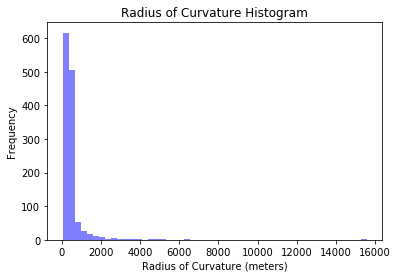

In [211]:
plot_curvature_histogram(curvatures, num_bins = 50)

In [212]:
np.mean(curvatures)

466.65537301758104

## Challenge Video

### Extract Frames 

In [194]:
video = 'challenge_video.mp4'
output_dir = '%s/challenge_video' % data_dir
extract_video_imgs(video, output_dir)

100%|██████████| 1259/1259 [01:15<00:00, 18.03it/s]


### Make Lane Line Images

In [195]:
lane_line_dir = '%s/lane_lines_challenge_video' % data_dir

In [ ]:
video_image_files = sorted(glob.glob('%s/*.jpg' % output_dir))

frame_files, curvatures = make_lane_line_frames(video_image_files, lane_line_dir, objpoints, imgpoints,
                                                max_n_fits=12, reinit_cnt=48, start_idx=0,
                                                min_lane_width=2.6, max_lane_width=3.5)

  0%|          | 0/1259 [00:00<?, ?it/s]

### 0
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


  0%|          | 1/1259 [00:02<59:17,  2.83s/it]

###lane_width 3.40752158688
### 1
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


  0%|          | 2/1259 [00:05<59:26,  2.84s/it]

###lane_width 3.41139194002
### 2
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 3/1259 [00:07<52:24,  2.50s/it]

###fit_lane - leftx 21530
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17889
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42565027915
### 3
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 4/1259 [00:09<47:59,  2.29s/it]

###fit_lane - leftx 21251
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18287
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.42594215555
### 4
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 5/1259 [00:11<45:42,  2.19s/it]

###fit_lane - leftx 21765
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17332
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.42345788954
### 5
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  0%|          | 6/1259 [00:14<50:50,  2.43s/it]

###fit_lane - leftx 21850
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16796
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.4181619603
### 6
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 7/1259 [00:16<48:17,  2.31s/it]

###fit_lane - leftx 23420
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16394
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40536016618
### 7
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 8/1259 [00:18<48:04,  2.31s/it]

###fit_lane - leftx 23344
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16008
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39770983768
### 8
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 9/1259 [00:20<43:58,  2.11s/it]

###fit_lane - leftx 22832
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15928
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.39529975372
### 9
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 10/1259 [00:22<42:24,  2.04s/it]

###fit_lane - leftx 22816
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15300
###fit_lane - right_min_y, right_max_y 58 719
###lane_width 3.39597948616
### 10
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 11/1259 [00:24<42:53,  2.06s/it]

###fit_lane - leftx 21619
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15259
###fit_lane - right_min_y, right_max_y 86 719
###lane_width 3.39889989431
### 11
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 12/1259 [00:25<40:07,  1.93s/it]

###fit_lane - leftx 23141
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15617
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39592796348
### 12
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 13/1259 [00:28<42:23,  2.04s/it]

###fit_lane - leftx 22981
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15795
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39589395857
### 13
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 14/1259 [00:29<41:11,  1.98s/it]

###fit_lane - leftx 22429
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17770
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39732393708
### 14
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|          | 15/1259 [00:32<43:23,  2.09s/it]

###fit_lane - leftx 22077
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18138
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39332856566
### 15
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|▏         | 16/1259 [00:34<42:27,  2.05s/it]

###fit_lane - leftx 21080
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18147
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3872206821
### 16
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  1%|▏         | 17/1259 [00:35<39:15,  1.90s/it]

###fit_lane - leftx 21369
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17517
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.38114788365
### 17
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21186
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16810
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.37637315925


  1%|▏         | 18/1259 [00:37<40:41,  1.97s/it]

### 18
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 19/1259 [00:39<39:16,  1.90s/it]

###fit_lane - leftx 22098
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16258
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.37871500267
### 19
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 20/1259 [00:41<37:29,  1.82s/it]

###fit_lane - leftx 22694
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15610
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.38415133085
### 20
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 21/1259 [00:43<37:58,  1.84s/it]

###fit_lane - leftx 22972
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15222
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38669006917
### 21
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 22/1259 [00:44<37:42,  1.83s/it]

###fit_lane - leftx 22974
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15362
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39067979637
### 22
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 23/1259 [00:46<37:34,  1.82s/it]

###fit_lane - leftx 22718
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14613
###fit_lane - right_min_y, right_max_y 53 719
###lane_width 3.39168599766
### 23
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 24/1259 [00:48<40:04,  1.95s/it]

###fit_lane - leftx 21659
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 14463
###fit_lane - right_min_y, right_max_y 108 719
###lane_width 3.39449800731
### 24
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 25/1259 [00:50<37:33,  1.83s/it]

###fit_lane - leftx 23847
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14773
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.39765187414
### 25
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 26/1259 [00:52<40:57,  1.99s/it]

###fit_lane - leftx 23594
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15169
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39431706107
### 26
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23100
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15933
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39837866046


  2%|▏         | 27/1259 [00:54<39:18,  1.91s/it]

### 27
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 28/1259 [00:56<39:28,  1.92s/it]

###fit_lane - leftx 21519
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16785
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.4053536492
### 28
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21920
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17693
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.40799158261


  2%|▏         | 29/1259 [00:58<38:49,  1.89s/it]

### 29
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  2%|▏         | 30/1259 [01:00<38:30,  1.88s/it]

###fit_lane - leftx 21959
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17369
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.41020453452
### 30
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22476
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16433
###fit_lane - right_min_y, right_max_y 81 719
###lane_width 3.41062840532


  2%|▏         | 31/1259 [01:03<44:20,  2.17s/it]

### 31
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 32/1259 [01:04<40:46,  1.99s/it]

###fit_lane - leftx 22525
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15937
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40926636471
### 32
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 33/1259 [01:07<43:20,  2.12s/it]

###fit_lane - leftx 24569
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15574
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.40345139277
### 33
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 34/1259 [01:08<38:38,  1.89s/it]

###fit_lane - leftx 23985
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15729
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.39825745303
### 34
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 35/1259 [01:10<37:09,  1.82s/it]

###fit_lane - leftx 22581
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14565
###fit_lane - right_min_y, right_max_y 54 719
###lane_width 3.39455556578
### 35
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 36/1259 [01:11<36:15,  1.78s/it]

###fit_lane - leftx 22498
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14523
###fit_lane - right_min_y, right_max_y 101 719
###lane_width 3.39351297513
### 36
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 37/1259 [01:13<36:04,  1.77s/it]

###fit_lane - leftx 24433
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15298
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38433129578
### 37
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 38/1259 [01:15<34:16,  1.68s/it]

###fit_lane - leftx 24332
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16121
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.38200509204
### 38
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 39/1259 [01:16<35:33,  1.75s/it]

###fit_lane - leftx 22334
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16482
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37629755579
### 39
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 40/1259 [01:18<37:06,  1.83s/it]

###fit_lane - leftx 22059
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17108
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37121874685
### 40
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 41/1259 [01:20<34:21,  1.69s/it]

###fit_lane - leftx 21100
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17665
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.37002011161
### 41
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 42/1259 [01:22<36:09,  1.78s/it]

###fit_lane - leftx 21137
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17466
###fit_lane - right_min_y, right_max_y 11 719
###lane_width 3.36849274166
### 42
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 43/1259 [01:23<34:30,  1.70s/it]

###fit_lane - leftx 21316
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17087
###fit_lane - right_min_y, right_max_y 44 719
###lane_width 3.36552043283
### 43
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  3%|▎         | 44/1259 [01:25<34:45,  1.72s/it]

###fit_lane - leftx 21107
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16772
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.36037007655
### 44
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▎         | 45/1259 [01:27<33:06,  1.64s/it]

###fit_lane - leftx 23902
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16753
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.35358532576
### 45
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▎         | 46/1259 [01:28<33:12,  1.64s/it]

###fit_lane - leftx 23435
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15785
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34317308723
### 46
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▎         | 47/1259 [01:30<31:14,  1.55s/it]

###fit_lane - leftx 22454
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15441
###fit_lane - right_min_y, right_max_y 8 719
###lane_width 3.33735058429
### 47
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 48/1259 [01:31<32:20,  1.60s/it]

###fit_lane - leftx 21867
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14708
###fit_lane - right_min_y, right_max_y 47 719
###lane_width 3.33460897576
### 48
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 49/1259 [01:33<32:57,  1.63s/it]

###fit_lane - leftx 21590
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14597
###fit_lane - right_min_y, right_max_y 95 719
###lane_width 3.33704928191
### 49
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


  4%|▍         | 50/1259 [01:37<45:21,  2.25s/it]

###lane_width 3.32918942725
### 50
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 51/1259 [01:38<41:55,  2.08s/it]

###fit_lane - leftx 23136
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16184
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32295277568
### 51
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 52/1259 [01:40<38:40,  1.92s/it]

###fit_lane - leftx 21452
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16797
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.32012496125
### 52
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 53/1259 [01:41<36:50,  1.83s/it]

###fit_lane - leftx 21391
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17326
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31614807436
### 53
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 54/1259 [01:43<35:12,  1.75s/it]

###fit_lane - leftx 21135
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18207
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31024471284
### 54
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 55/1259 [01:45<35:33,  1.77s/it]

###fit_lane - leftx 21178
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17675
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.30332366383
### 55
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  4%|▍         | 56/1259 [01:46<34:11,  1.71s/it]

###fit_lane - leftx 21404
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16778
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.29903434946
### 56
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 57/1259 [01:48<32:42,  1.63s/it]

###fit_lane - leftx 21445
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15943
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.29924269767
### 57
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 58/1259 [01:50<33:05,  1.65s/it]

###fit_lane - leftx 23912
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15713
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29279501496
### 58
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 59/1259 [01:51<31:52,  1.59s/it]

###fit_lane - leftx 23851
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15342
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.28597725227
### 59
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 60/1259 [01:53<31:10,  1.56s/it]

###fit_lane - leftx 22373
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14447
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.27772754029
### 60
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 61/1259 [01:54<31:29,  1.58s/it]

###fit_lane - leftx 21909
###fit_lane - left_min_y, left_max_y 0 717
###fit_lane - rightx 14398
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.26873584639
### 61
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▍         | 62/1259 [01:56<31:21,  1.57s/it]

###fit_lane - leftx 24396
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15520
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26057102633
### 62
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 63/1259 [01:57<31:45,  1.59s/it]

###fit_lane - leftx 24084
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16550
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.24985015648
### 63
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 64/1259 [01:59<33:18,  1.67s/it]

###fit_lane - leftx 23552
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17312
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23940043962
### 64
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 65/1259 [02:01<33:37,  1.69s/it]

###fit_lane - leftx 22577
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17585
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.23131293029
### 65
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 66/1259 [02:03<34:17,  1.72s/it]

###fit_lane - leftx 22042
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17916
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.22506886256
### 66
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 67/1259 [02:04<33:52,  1.71s/it]

###fit_lane - leftx 22157
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17337
###fit_lane - right_min_y, right_max_y 29 719
###lane_width 3.21979972386
### 67
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 68/1259 [02:06<34:20,  1.73s/it]

###fit_lane - leftx 22107
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16103
###fit_lane - right_min_y, right_max_y 82 719
###lane_width 3.21236238029
### 68
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  5%|▌         | 69/1259 [02:08<33:07,  1.67s/it]

###fit_lane - leftx 21680
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15489
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.20812983533
### 69
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 70/1259 [02:10<33:53,  1.71s/it]

###fit_lane - leftx 25210
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15567
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.20482009231
### 70
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 71/1259 [02:11<33:27,  1.69s/it]

###fit_lane - leftx 24128
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15584
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.19938866698
### 71
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 72/1259 [02:13<33:47,  1.71s/it]

###fit_lane - leftx 23423
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15243
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.19479147913
### 72
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 73/1259 [02:15<33:15,  1.68s/it]

###fit_lane - leftx 23247
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14643
###fit_lane - right_min_y, right_max_y 76 719
###lane_width 3.19047303239
### 73
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 74/1259 [02:16<32:52,  1.66s/it]

###fit_lane - leftx 22378
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14526
###fit_lane - right_min_y, right_max_y 114 719
###lane_width 3.1927913043
### 74
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 75/1259 [02:18<33:34,  1.70s/it]

###fit_lane - leftx 24576
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15356
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18769449626
### 75
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 76/1259 [02:20<33:12,  1.68s/it]

###fit_lane - leftx 24227
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15892
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18266065149
### 76
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 77/1259 [02:22<35:29,  1.80s/it]

###fit_lane - leftx 23812
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16866
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17988469919
### 77
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▌         | 78/1259 [02:23<33:49,  1.72s/it]

###fit_lane - leftx 22943
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16894
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17882588173
### 78
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▋         | 79/1259 [02:25<33:32,  1.71s/it]

###fit_lane - leftx 22346
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17440
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17616446829
### 79
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▋         | 80/1259 [02:26<32:23,  1.65s/it]

###fit_lane - leftx 22438
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17578
###fit_lane - right_min_y, right_max_y 4 719
###lane_width 3.17307812258
### 80
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  6%|▋         | 81/1259 [02:28<33:39,  1.71s/it]

###fit_lane - leftx 21956
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16590
###fit_lane - right_min_y, right_max_y 46 719
###lane_width 3.16792359928
### 81
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22255
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 15874
###fit_lane - right_min_y, right_max_y 96 719
###lane_width 3.16946462448


  7%|▋         | 82/1259 [02:31<39:31,  2.01s/it]

### 82
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 83/1259 [02:33<37:46,  1.93s/it]

###fit_lane - leftx 25387
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16559
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16509165544
### 83
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24155
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15356
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.160448868


  7%|▋         | 84/1259 [02:35<38:03,  1.94s/it]

### 84
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 85/1259 [02:36<35:03,  1.79s/it]

###fit_lane - leftx 23508
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15538
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15787562623
### 85
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 86/1259 [02:38<37:36,  1.92s/it]

###fit_lane - leftx 23182
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14305
###fit_lane - right_min_y, right_max_y 69 719
###lane_width 3.1573846804
### 86
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 87/1259 [02:40<35:09,  1.80s/it]

###fit_lane - leftx 25089
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15321
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.1549500152
### 87
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 88/1259 [02:42<35:23,  1.81s/it]

###fit_lane - leftx 24475
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15990
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15188318179
### 88
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 89/1259 [02:43<33:39,  1.73s/it]

###fit_lane - leftx 23295
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16924
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14908237793
### 89
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 90/1259 [02:45<32:54,  1.69s/it]

###fit_lane - leftx 22642
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17156
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14624329283
### 90
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 91/1259 [02:46<30:49,  1.58s/it]

###fit_lane - leftx 21552
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17039
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14990924372
### 91
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 92/1259 [02:48<31:51,  1.64s/it]

###fit_lane - leftx 22379
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17493
###fit_lane - right_min_y, right_max_y 13 719
###lane_width 3.14939812147
### 92
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 93/1259 [02:50<32:13,  1.66s/it]

###fit_lane - leftx 22122
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16607
###fit_lane - right_min_y, right_max_y 59 719
###lane_width 3.14836719799
### 93
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  7%|▋         | 94/1259 [02:51<32:36,  1.68s/it]

###fit_lane - leftx 22683
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15984
###fit_lane - right_min_y, right_max_y 97 719
###lane_width 3.14579854241
### 94
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 95/1259 [02:53<33:10,  1.71s/it]

###fit_lane - leftx 26347
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15857
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14277015928
### 95
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 96/1259 [02:55<33:10,  1.71s/it]

###fit_lane - leftx 25849
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15749
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14069404298
### 96
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 24366
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15226
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.13979122942


  8%|▊         | 97/1259 [02:56<32:27,  1.68s/it]

### 97
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8
###lane_width 3.14392674218


  8%|▊         | 98/1259 [02:59<35:01,  1.81s/it]

### 98
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22319
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14318
###fit_lane - right_min_y, right_max_y 105 719
###lane_width 3.15046302715


  8%|▊         | 99/1259 [03:00<35:01,  1.81s/it]

### 99
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 100/1259 [03:02<34:43,  1.80s/it]

###fit_lane - leftx 25489
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15374
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14967652426
### 100
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25245
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16397
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1495049853


  8%|▊         | 101/1259 [03:04<35:50,  1.86s/it]

### 101
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 102/1259 [03:06<35:01,  1.82s/it]

###fit_lane - leftx 24194
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17191
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15175826283
### 102
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 103/1259 [03:08<37:56,  1.97s/it]

###fit_lane - leftx 23421
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17434
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14946034552
### 103
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 104/1259 [03:10<35:27,  1.84s/it]

###fit_lane - leftx 21719
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17396
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15251924458
### 104
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 105/1259 [03:12<35:58,  1.87s/it]

###fit_lane - leftx 21830
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17822
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15578841721
### 105
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 106/1259 [03:14<36:15,  1.89s/it]

###fit_lane - leftx 22326
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17318
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.15789883323
### 106
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  8%|▊         | 107/1259 [03:15<35:43,  1.86s/it]

###fit_lane - leftx 22269
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16269
###fit_lane - right_min_y, right_max_y 92 719
###lane_width 3.16383375246
### 107
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 25373
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16245
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16412725106


  9%|▊         | 108/1259 [03:18<37:41,  1.96s/it]

### 108
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▊         | 109/1259 [03:20<38:49,  2.03s/it]

###fit_lane - leftx 25592
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15877
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15997988382
### 109
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▊         | 110/1259 [03:22<38:18,  2.00s/it]

###fit_lane - leftx 23915
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15606
###fit_lane - right_min_y, right_max_y 10 719
###lane_width 3.15210618476
### 110
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 111/1259 [03:24<37:14,  1.95s/it]

###fit_lane - leftx 22945
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14793
###fit_lane - right_min_y, right_max_y 40 719
###lane_width 3.15408961322
### 111
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 112/1259 [03:25<35:15,  1.84s/it]

###fit_lane - leftx 22305
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14437
###fit_lane - right_min_y, right_max_y 102 719
###lane_width 3.16189265032
### 112
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 113/1259 [03:27<33:08,  1.74s/it]

###fit_lane - leftx 25010
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15631
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16228933464
### 113
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 114/1259 [03:29<35:24,  1.86s/it]

###fit_lane - leftx 24856
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16021
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16411558852
### 114
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 115/1259 [03:30<33:01,  1.73s/it]

###fit_lane - leftx 23548
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16961
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.16788364895
### 115
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 116/1259 [03:32<34:22,  1.80s/it]

###fit_lane - leftx 22573
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17142
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17177991346
### 116
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 117/1259 [03:34<34:10,  1.80s/it]

###fit_lane - leftx 22551
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17743
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17349852566
### 117
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 118/1259 [03:36<33:36,  1.77s/it]

###fit_lane - leftx 22413
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17265
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.17494651071
### 118
###img min(), max() 0 255
###img (720, 1280, 3) uint8


  9%|▉         | 119/1259 [03:37<33:17,  1.75s/it]

###fit_lane - leftx 21809
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16372
###fit_lane - right_min_y, right_max_y 83 719
###lane_width 3.17570436323
### 119
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 120/1259 [03:39<33:48,  1.78s/it]

###fit_lane - leftx 21487
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15745
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.17878933376
### 120
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 121/1259 [03:41<32:30,  1.71s/it]

###fit_lane - leftx 24312
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16104
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18132807577
### 121
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 23114
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15664
###fit_lane - right_min_y, right_max_y 16 719
###lane_width 3.18203541899


 10%|▉         | 122/1259 [03:43<33:45,  1.78s/it]

### 122
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 123/1259 [03:44<33:11,  1.75s/it]

###fit_lane - leftx 22753
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14816
###fit_lane - right_min_y, right_max_y 64 719
###lane_width 3.1799706813
### 123
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 124/1259 [03:46<32:21,  1.71s/it]

###fit_lane - leftx 21800
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14236
###fit_lane - right_min_y, right_max_y 110 719
###lane_width 3.17850376367
### 124
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|▉         | 125/1259 [03:48<32:09,  1.70s/it]

###fit_lane - leftx 23848
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15394
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17832881872
### 125
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 126/1259 [03:49<32:04,  1.70s/it]

###fit_lane - leftx 23033
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16132
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.17882308297
### 126
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 127/1259 [03:51<30:56,  1.64s/it]

###fit_lane - leftx 22955
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17224
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18055998874
### 127
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 128/1259 [03:53<34:43,  1.84s/it]

###fit_lane - leftx 22020
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17625
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18044921376
### 128
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21023
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17811
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.18229460573


 10%|█         | 129/1259 [03:55<35:34,  1.89s/it]

### 129
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 130/1259 [03:57<34:29,  1.83s/it]

###fit_lane - leftx 21799
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17760
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.18026414655
### 130
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 131/1259 [03:59<36:23,  1.94s/it]

###fit_lane - leftx 22043
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17611
###fit_lane - right_min_y, right_max_y 81 719
###lane_width 3.1714816181
### 131
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 10%|█         | 132/1259 [04:01<34:28,  1.84s/it]

###fit_lane - leftx 22203
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 16594
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.16434327732
### 132
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 133/1259 [04:03<35:02,  1.87s/it]

###fit_lane - leftx 24832
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16540
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1609189703
### 133
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 134/1259 [04:04<33:06,  1.77s/it]

###fit_lane - leftx 24570
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16548
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15812141737
### 134
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 135/1259 [04:06<32:37,  1.74s/it]

###fit_lane - leftx 24212
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16059
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.15502661701
### 135
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22759
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14962
###fit_lane - right_min_y, right_max_y 74 719
###lane_width 3.15177676749


 11%|█         | 136/1259 [04:07<32:05,  1.71s/it]

### 136
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 137/1259 [04:09<32:29,  1.74s/it]

###fit_lane - leftx 21460
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14611
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.15639240577
### 137
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 138/1259 [04:11<31:08,  1.67s/it]

###fit_lane - leftx 25162
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15574
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.14867135373
### 138
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 139/1259 [04:13<33:48,  1.81s/it]

###fit_lane - leftx 24204
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15878
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1460844479
### 139
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 140/1259 [04:15<33:02,  1.77s/it]

###fit_lane - leftx 22764
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16901
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.14679384593
### 140
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█         | 141/1259 [04:16<32:29,  1.74s/it]

###fit_lane - leftx 21772
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 17289
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.1511522528
### 141
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█▏        | 142/1259 [04:18<31:32,  1.69s/it]

###fit_lane - leftx 21093
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17942
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.15784592376
### 142
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█▏        | 143/1259 [04:20<32:41,  1.76s/it]

###fit_lane - leftx 21699
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17496
###fit_lane - right_min_y, right_max_y 30 719
###lane_width 3.16875610443
### 143
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 11%|█▏        | 144/1259 [04:21<32:19,  1.74s/it]

###fit_lane - leftx 21642
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16833
###fit_lane - right_min_y, right_max_y 71 719
###lane_width 3.17928183474
### 144
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 145/1259 [04:24<34:35,  1.86s/it]

###fit_lane - leftx 21991
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15777
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.18698852502
### 145
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###basic_lane_lines_img min(), max() 0 204
###basic_lane_lines_img (720, 1280, 3) uint8


 12%|█▏        | 146/1259 [04:27<41:16,  2.22s/it]

###lane_width 3.25841358655
### 146
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 147/1259 [04:28<38:12,  2.06s/it]

###fit_lane - leftx 23880
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15916
###fit_lane - right_min_y, right_max_y 29 719
###lane_width 3.26647139497
### 147
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 148/1259 [04:30<36:46,  1.99s/it]

###fit_lane - leftx 22940
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14794
###fit_lane - right_min_y, right_max_y 72 719
###lane_width 3.27739211689
### 148
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 22576
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14514
###fit_lane - right_min_y, right_max_y 105 719
###lane_width 3.28550801035


 12%|█▏        | 149/1259 [04:32<37:10,  2.01s/it]

### 149
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 150/1259 [04:34<36:37,  1.98s/it]

###fit_lane - leftx 22853
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14781
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30158717948
### 150
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 151/1259 [04:36<36:15,  1.96s/it]

###fit_lane - leftx 22746
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15670
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31824970136
### 151
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 152/1259 [04:38<34:40,  1.88s/it]

###fit_lane - leftx 22611
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17319
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.33245625839
### 152
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 153/1259 [04:40<33:51,  1.84s/it]

###fit_lane - leftx 22124
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17788
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.34298127608
### 153
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 154/1259 [04:41<32:17,  1.75s/it]

###fit_lane - leftx 21218
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18172
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.35299458615
### 154
###img min(), max() 0 255
###img (720, 1280, 3) uint8
###fit_lane - leftx 21760
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 18221
###fit_lane - right_min_y, right_max_y 9 719
###lane_width 3.36319117345


 12%|█▏        | 155/1259 [04:44<36:25,  1.98s/it]

### 155
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 156/1259 [04:45<34:15,  1.86s/it]

###fit_lane - leftx 21828
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17241
###fit_lane - right_min_y, right_max_y 56 719
###lane_width 3.37263307026
### 156
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 12%|█▏        | 157/1259 [04:47<32:11,  1.75s/it]

###fit_lane - leftx 22474
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16361
###fit_lane - right_min_y, right_max_y 109 719
###lane_width 3.38164313157
### 157
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 158/1259 [04:48<31:54,  1.74s/it]

###fit_lane - leftx 25023
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16458
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.32094470575
### 158
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 159/1259 [04:50<33:02,  1.80s/it]

###fit_lane - leftx 24233
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16314
###fit_lane - right_min_y, right_max_y 1 719
###lane_width 3.3249009605
### 159
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 160/1259 [04:53<36:33,  2.00s/it]

###fit_lane - leftx 23652
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15677
###fit_lane - right_min_y, right_max_y 33 719
###lane_width 3.3280074699
### 160
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 161/1259 [04:55<35:20,  1.93s/it]

###fit_lane - leftx 22754
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14875
###fit_lane - right_min_y, right_max_y 77 719
###lane_width 3.33140959863
### 161
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 162/1259 [04:56<34:04,  1.86s/it]

###fit_lane - leftx 21884
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14695
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.33546046623
### 162
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 163/1259 [04:58<32:36,  1.79s/it]

###fit_lane - leftx 25040
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15939
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.3262980644
### 163
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 164/1259 [04:59<31:25,  1.72s/it]

###fit_lane - leftx 24558
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17198
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.31483828428
### 164
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 165/1259 [05:02<33:42,  1.85s/it]

###fit_lane - leftx 23324
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17463
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30791962734
### 165
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 166/1259 [05:03<33:55,  1.86s/it]

###fit_lane - leftx 21989
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17637
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.30197335368
### 166
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 167/1259 [05:05<32:18,  1.77s/it]

###fit_lane - leftx 22147
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 18125
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.29810310459
### 167
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 168/1259 [05:07<31:19,  1.72s/it]

###fit_lane - leftx 22408
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 17474
###fit_lane - right_min_y, right_max_y 32 719
###lane_width 3.29516021042
### 168
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 13%|█▎        | 169/1259 [05:08<30:10,  1.66s/it]

###fit_lane - leftx 22307
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16823
###fit_lane - right_min_y, right_max_y 70 719
###lane_width 3.29301700548
### 169
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 170/1259 [05:10<28:34,  1.57s/it]

###fit_lane - leftx 23431
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 16019
###fit_lane - right_min_y, right_max_y 113 719
###lane_width 3.29604058766
### 170
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 171/1259 [05:12<30:55,  1.71s/it]

###fit_lane - leftx 24368
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15633
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.2932283379
### 171
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 172/1259 [05:13<30:08,  1.66s/it]

###fit_lane - leftx 23937
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15586
###fit_lane - right_min_y, right_max_y 3 719
###lane_width 3.28854713149
### 172
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▎        | 173/1259 [05:15<30:25,  1.68s/it]

###fit_lane - leftx 24207
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 14656
###fit_lane - right_min_y, right_max_y 65 719
###lane_width 3.28084230242
### 173
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 174/1259 [05:17<30:31,  1.69s/it]

###fit_lane - leftx 22535
###fit_lane - left_min_y, left_max_y 0 718
###fit_lane - rightx 14289
###fit_lane - right_min_y, right_max_y 115 719
###lane_width 3.27296841433
### 174
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 175/1259 [05:19<33:39,  1.86s/it]

###fit_lane - leftx 25045
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15771
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26489231725
### 175
###img min(), max() 0 255
###img (720, 1280, 3) uint8


 14%|█▍        | 176/1259 [05:21<33:50,  1.87s/it]

###fit_lane - leftx 24320
###fit_lane - left_min_y, left_max_y 0 719
###fit_lane - rightx 15945
###fit_lane - right_min_y, right_max_y 0 719
###lane_width 3.26024247019
### 176
###img min(), max() 0 255
###img (720, 1280, 3) uint8
